### Medium story link (https://medium.com/@denizdoruknuholu/airbnb-in-two-cities-seattle-vs-boston-66fba22fc1c1)

In [1]:
#Make necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
from re import sub
from decimal import Decimal
from matplotlib import pyplot as plt
import datetime
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize, WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tests as t
import re
import nltk
from sklearn.preprocessing import OneHotEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Business Understanding

#### AirBnB Kaggle data has three main files. Calendar data for both cities has pricing and availability over time that can be very useful in analyzing changes in these factors throughout the year. We could look into the means for both cities over time to generate insights and comparisons.

#### Listings data has another vitally important information for us, which is the review scores rating. I am thinking that looking at the correlation between words used in the comments for the listing, could give us great insights.

## 2. Data Understanding

In [2]:
#Read Listing and Calendar files for Boston & Seattle datasets
boston_listings = pd.read_csv('boston/listings.csv')
seattle_listings = pd.read_csv('seattle/listings.csv')
boston_calendar = pd.read_csv('boston/calendar.csv', parse_dates=['date'])
seattle_calendar = pd.read_csv('seattle/calendar.csv', parse_dates=['date'])
boston_review = pd.read_csv('boston/reviews.csv')
seattle_review = pd.read_csv('seattle/reviews.csv')

# Drop columns found in boston dataset that are not in seattle dataset.
boston_drop_columns = [column for column in boston_listings.columns if column not in seattle_listings.columns]

for column in boston_drop_columns:
    boston_listings.drop(column,axis=1,inplace=True)

In [3]:
#Clean up the data
#Function converts price in a string in currency format to float
def clean_price(price):
    """Take in a string and return a float without the currency sign"""
    try:
        return float(sub(r'[^\d.]', '', price))
    except:
        return float(price)

seattle_calendar['price'] = seattle_calendar['price'].map(clean_price)
boston_calendar['price'] = boston_calendar['price'].map(clean_price)
seattle_calendar['day_of_year'] = seattle_calendar['date'].map(lambda x: x.timetuple().tm_yday)
boston_calendar['day_of_year'] = boston_calendar['date'].map(lambda x: x.timetuple().tm_yday)
seattle_calendar['available'] = seattle_calendar['available'].apply(lambda x: True if x == 't' else False)
boston_calendar['available'] = boston_calendar['available'].apply(lambda x: True if x == 't' else False)
avg_price_day_s = seattle_calendar.drop('listing_id',axis=1).groupby('day_of_year').mean()
avg_price_day_b = boston_calendar.drop('listing_id',axis=1).groupby('day_of_year').mean()
avg_price_date_s = seattle_calendar.drop(['listing_id','day_of_year'],axis=1).groupby('date').mean()
avg_price_date_b = boston_calendar.drop(['listing_id','day_of_year'],axis=1).groupby('date').mean()

In [4]:
print('The median house price in Boston is ${}'.format(int(boston_calendar['price'].median())))
print('The median house price in Seattle is ${}'.format(int(seattle_calendar['price'].median())))

The median house price in Boston is $150
The median house price in Seattle is $109


### Question 1: How are the pricing of the properties in Boston and Seattle? Do they have seasonality? Are there any events that cause jumps in price?

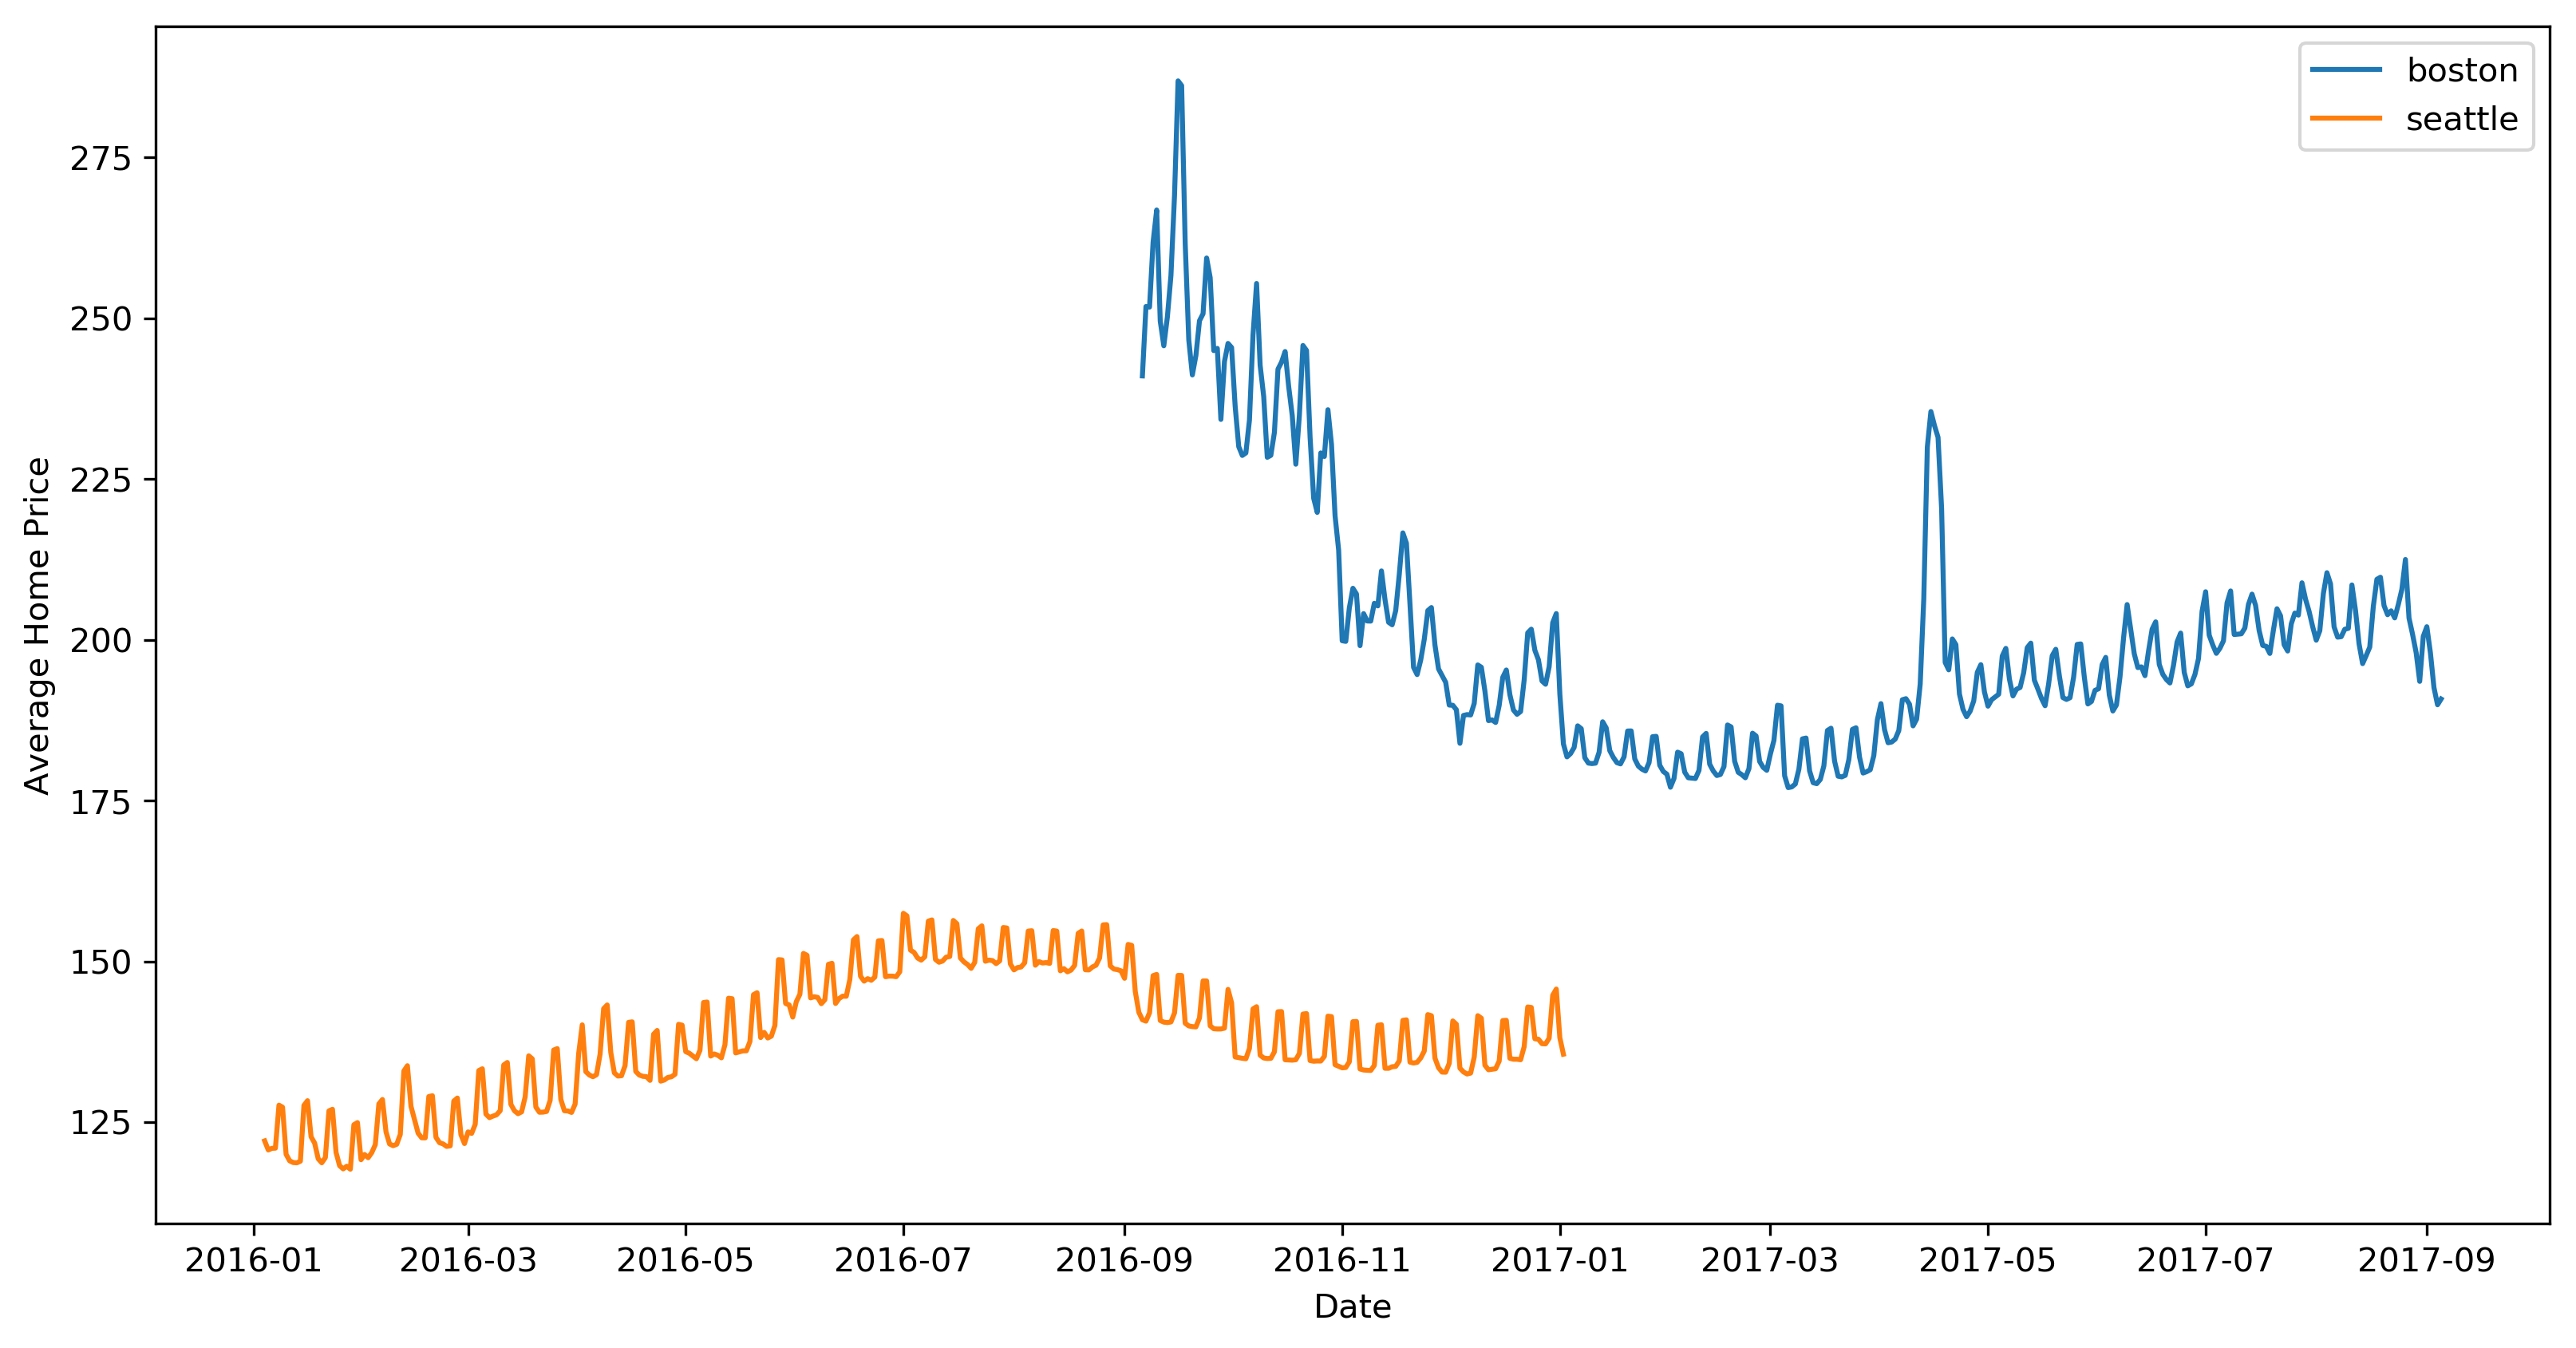

In [5]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(avg_price_date_b['price'], label='boston')
ax.plot(avg_price_date_s['price'], label='seattle')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Average Home Price');
fig.savefig('png\PriceVsDate.png', bbox_inches='tight')

In [6]:
'The average price during the Boston Marathon period in 2017 was ${}'.format(int(avg_price_date_b.loc['2017-04-14':'2017-04-17','price'].mean()))

'The average price during the Boston Marathon period in 2017 was $232'

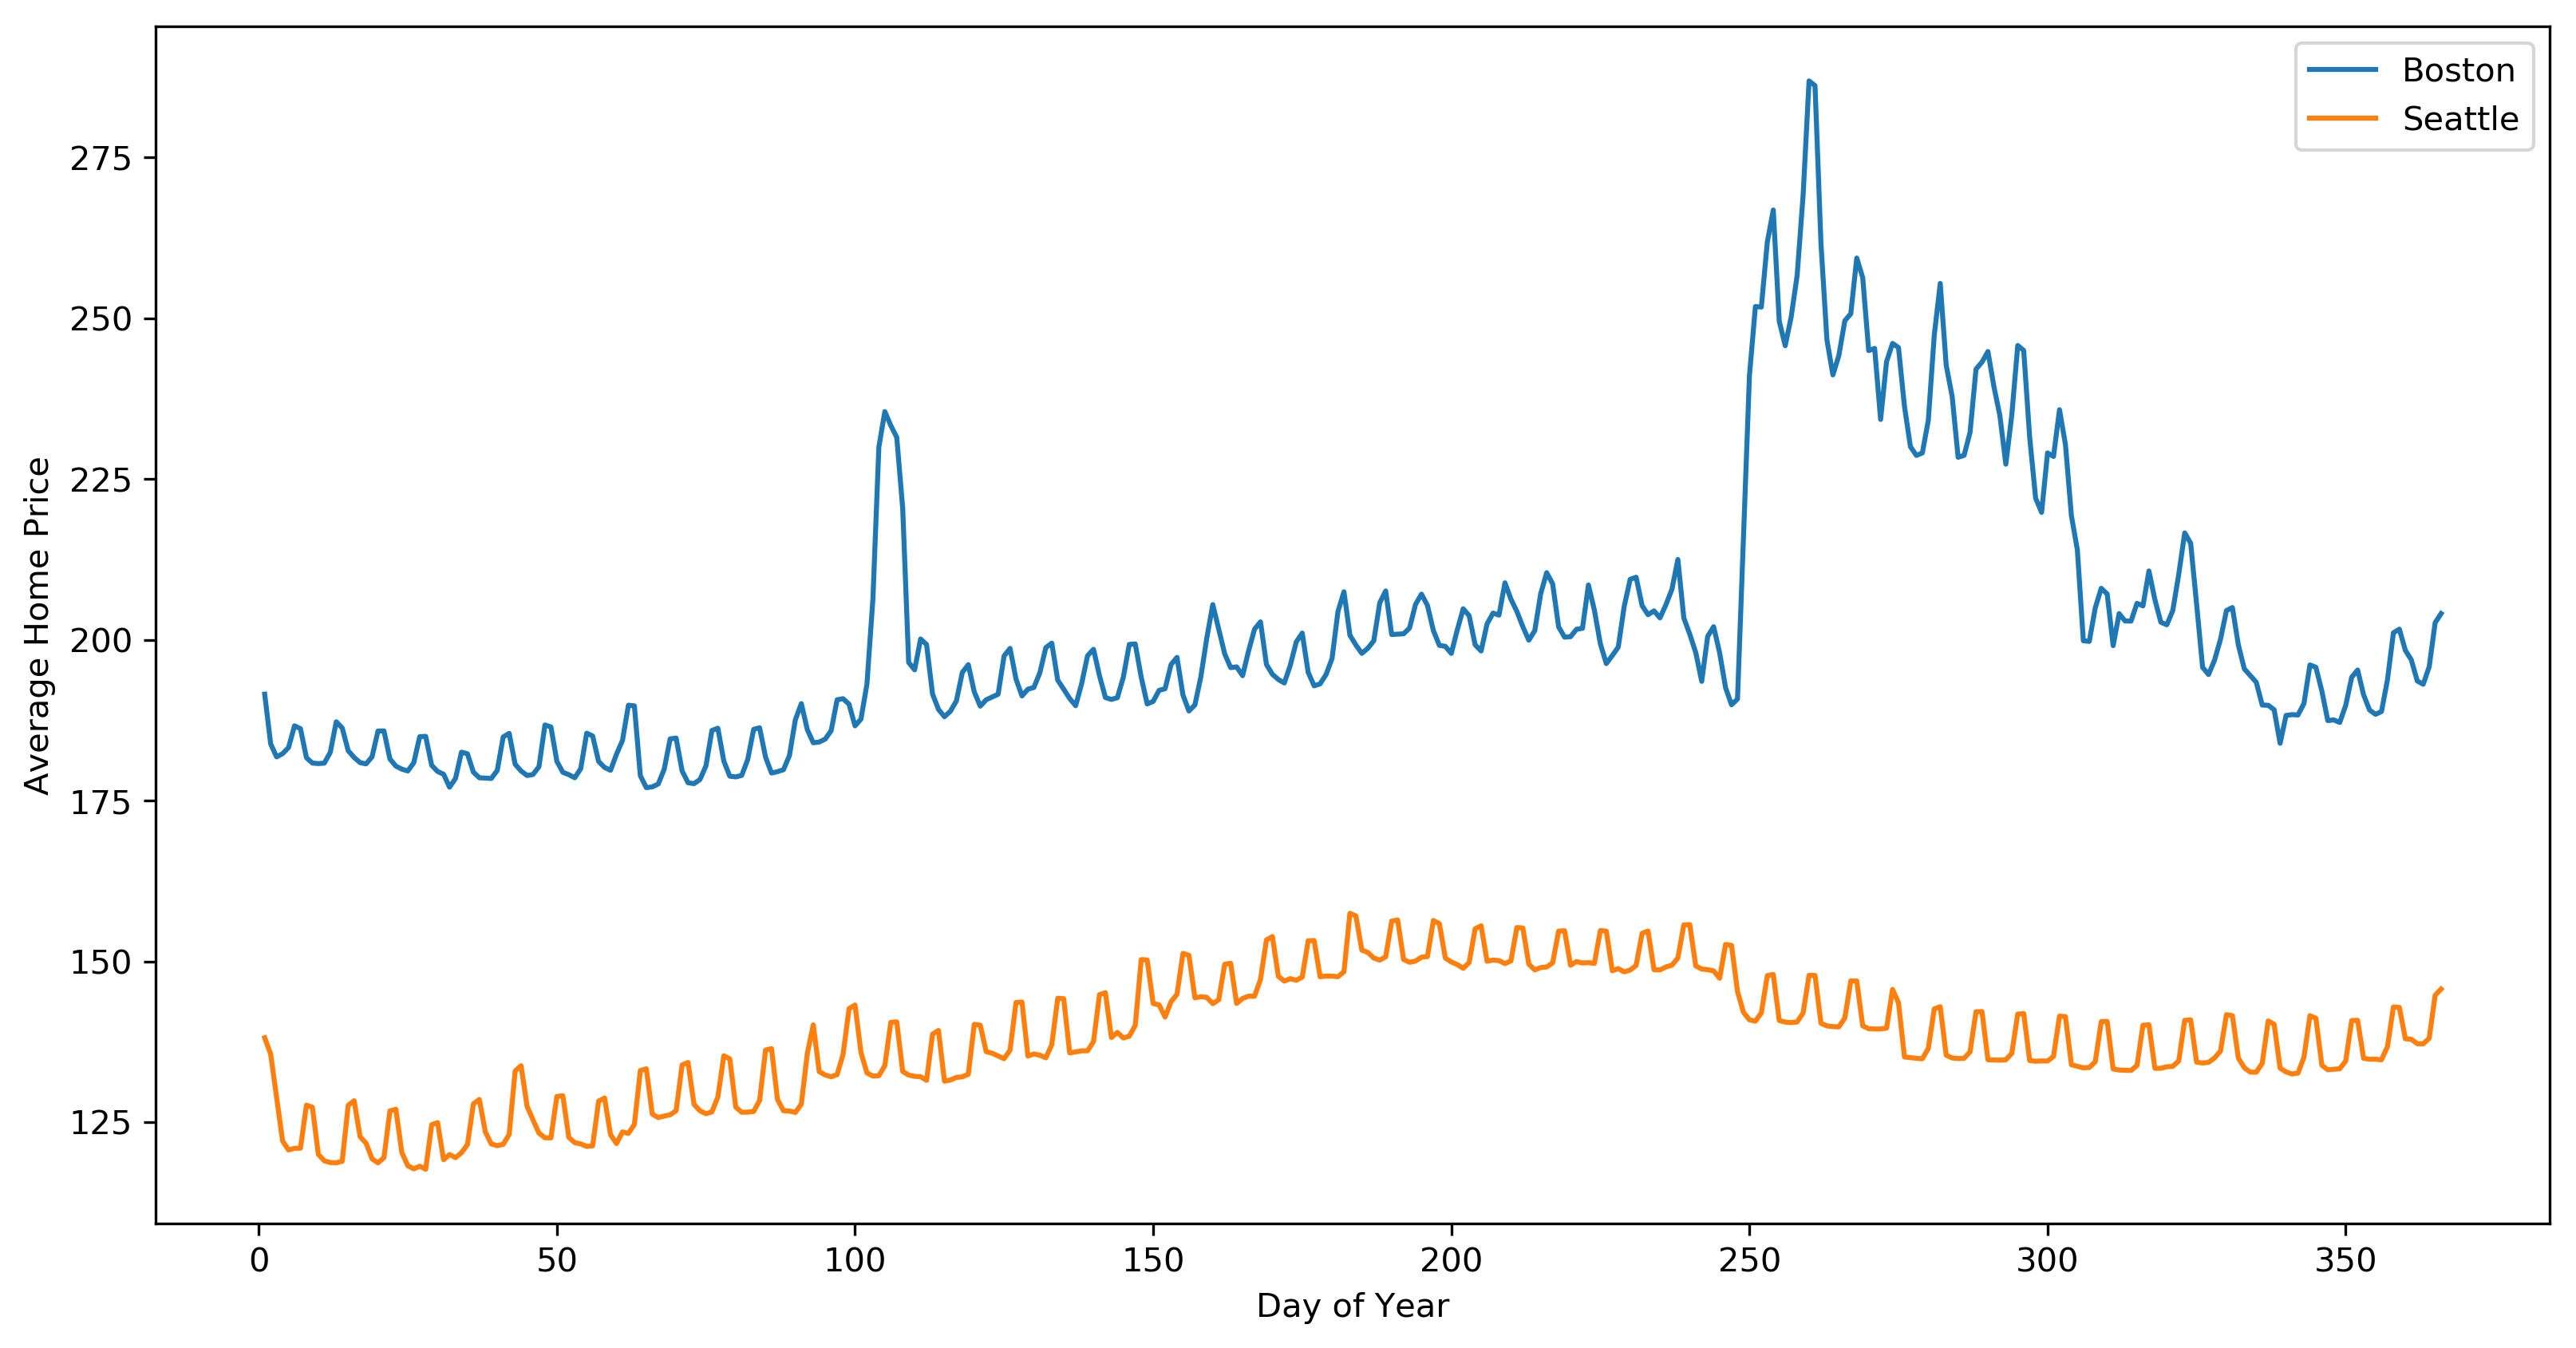

In [7]:
fig2 = plt.figure(figsize=(10,5),dpi=300)
ax2 = fig2.add_axes([0,0,1,1])
ax2.plot(avg_price_day_b['price'], label='Boston')
ax2.plot(avg_price_day_s['price'], label='Seattle');
ax2.legend()
ax2.set_xlabel('Day of Year')
ax2.set_ylabel('Average Home Price')
fig2.savefig('png\PricevsDay.png', bbox_inches='tight')

### Question 2: How is the availability of the properties in both cities throughout the year

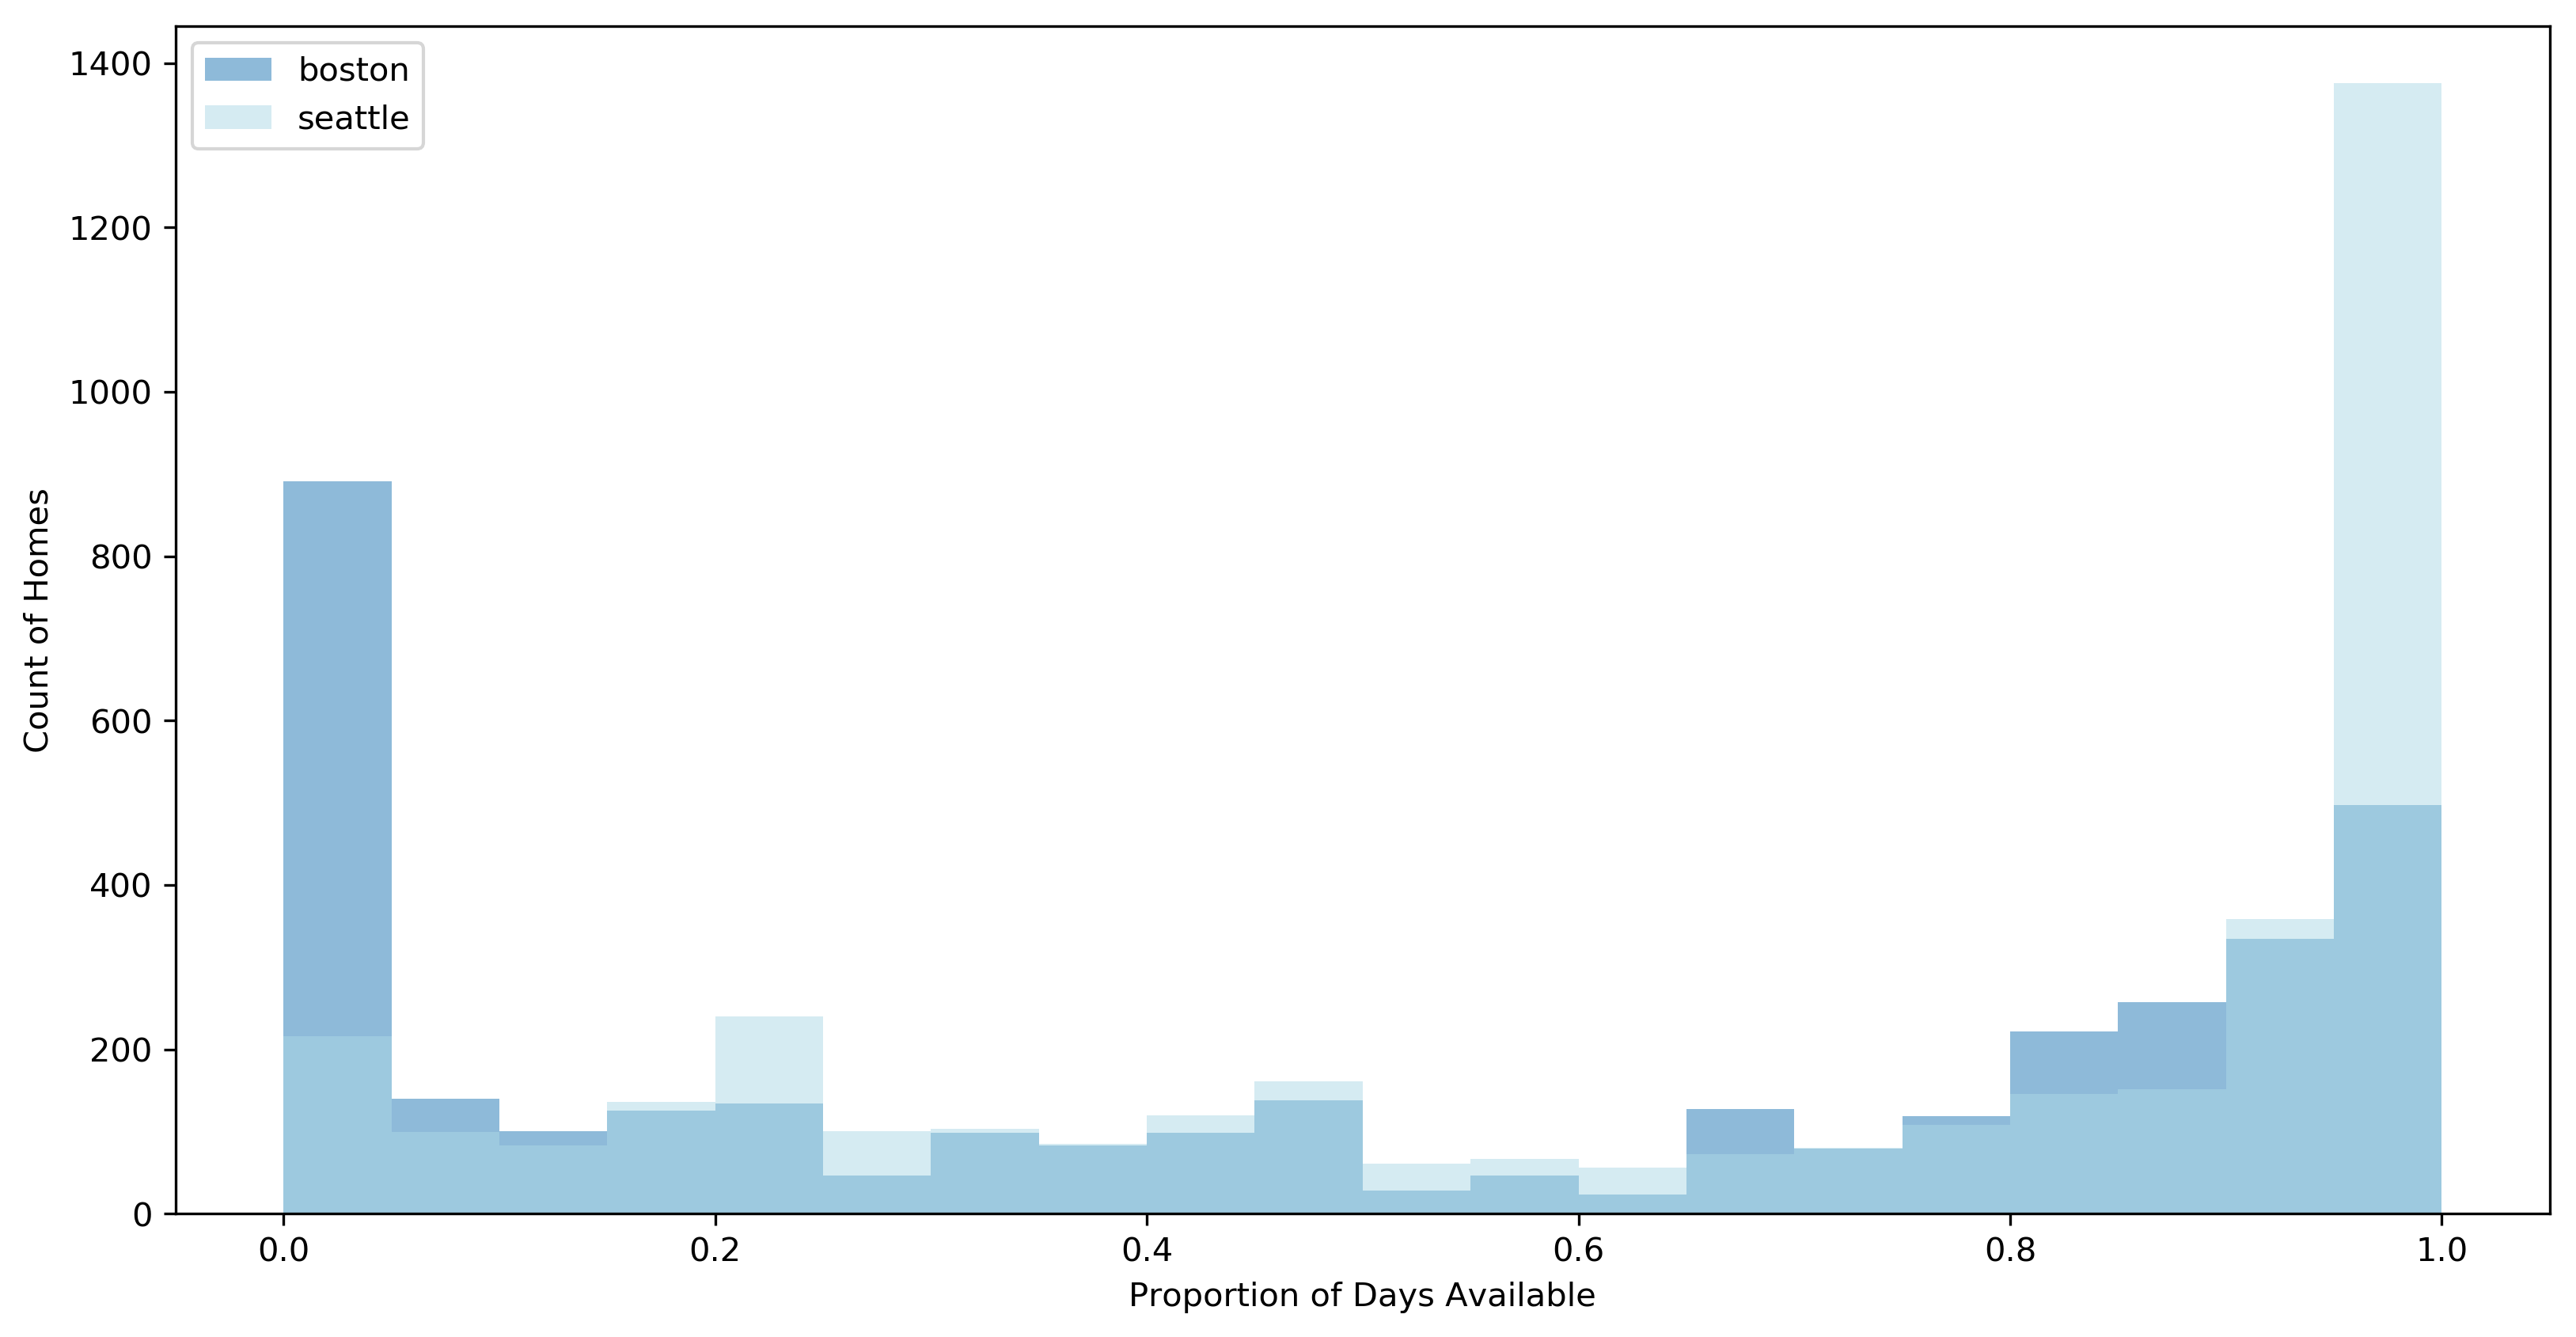

In [8]:
fig3 = plt.figure(figsize=(10,5),dpi=300)
ax3 = fig3.add_axes([0,0,1,1])
ax3.hist(boston_calendar.groupby('listing_id').mean()['available'],bins=20,alpha=0.5, label='boston');
ax3.hist(seattle_calendar.groupby('listing_id').mean()['available'],bins=20,alpha=0.5, label='seattle', color='lightblue')
ax3.legend()
ax3.set_xlabel('Proportion of Days Available')
ax3.set_ylabel('Count of Homes')
fig3.savefig('png\PropDaysAvailable.png', bbox_inches='tight')

In [9]:
'In Boston, at any given time, there is a %{} chance that a house is available, while in Seattle this figure is much higher at %{}'.format(int(boston_calendar['available'].mean()*100), int(seattle_calendar['available'].mean()*100))

'In Boston, at any given time, there is a %49 chance that a house is available, while in Seattle this figure is much higher at %67'

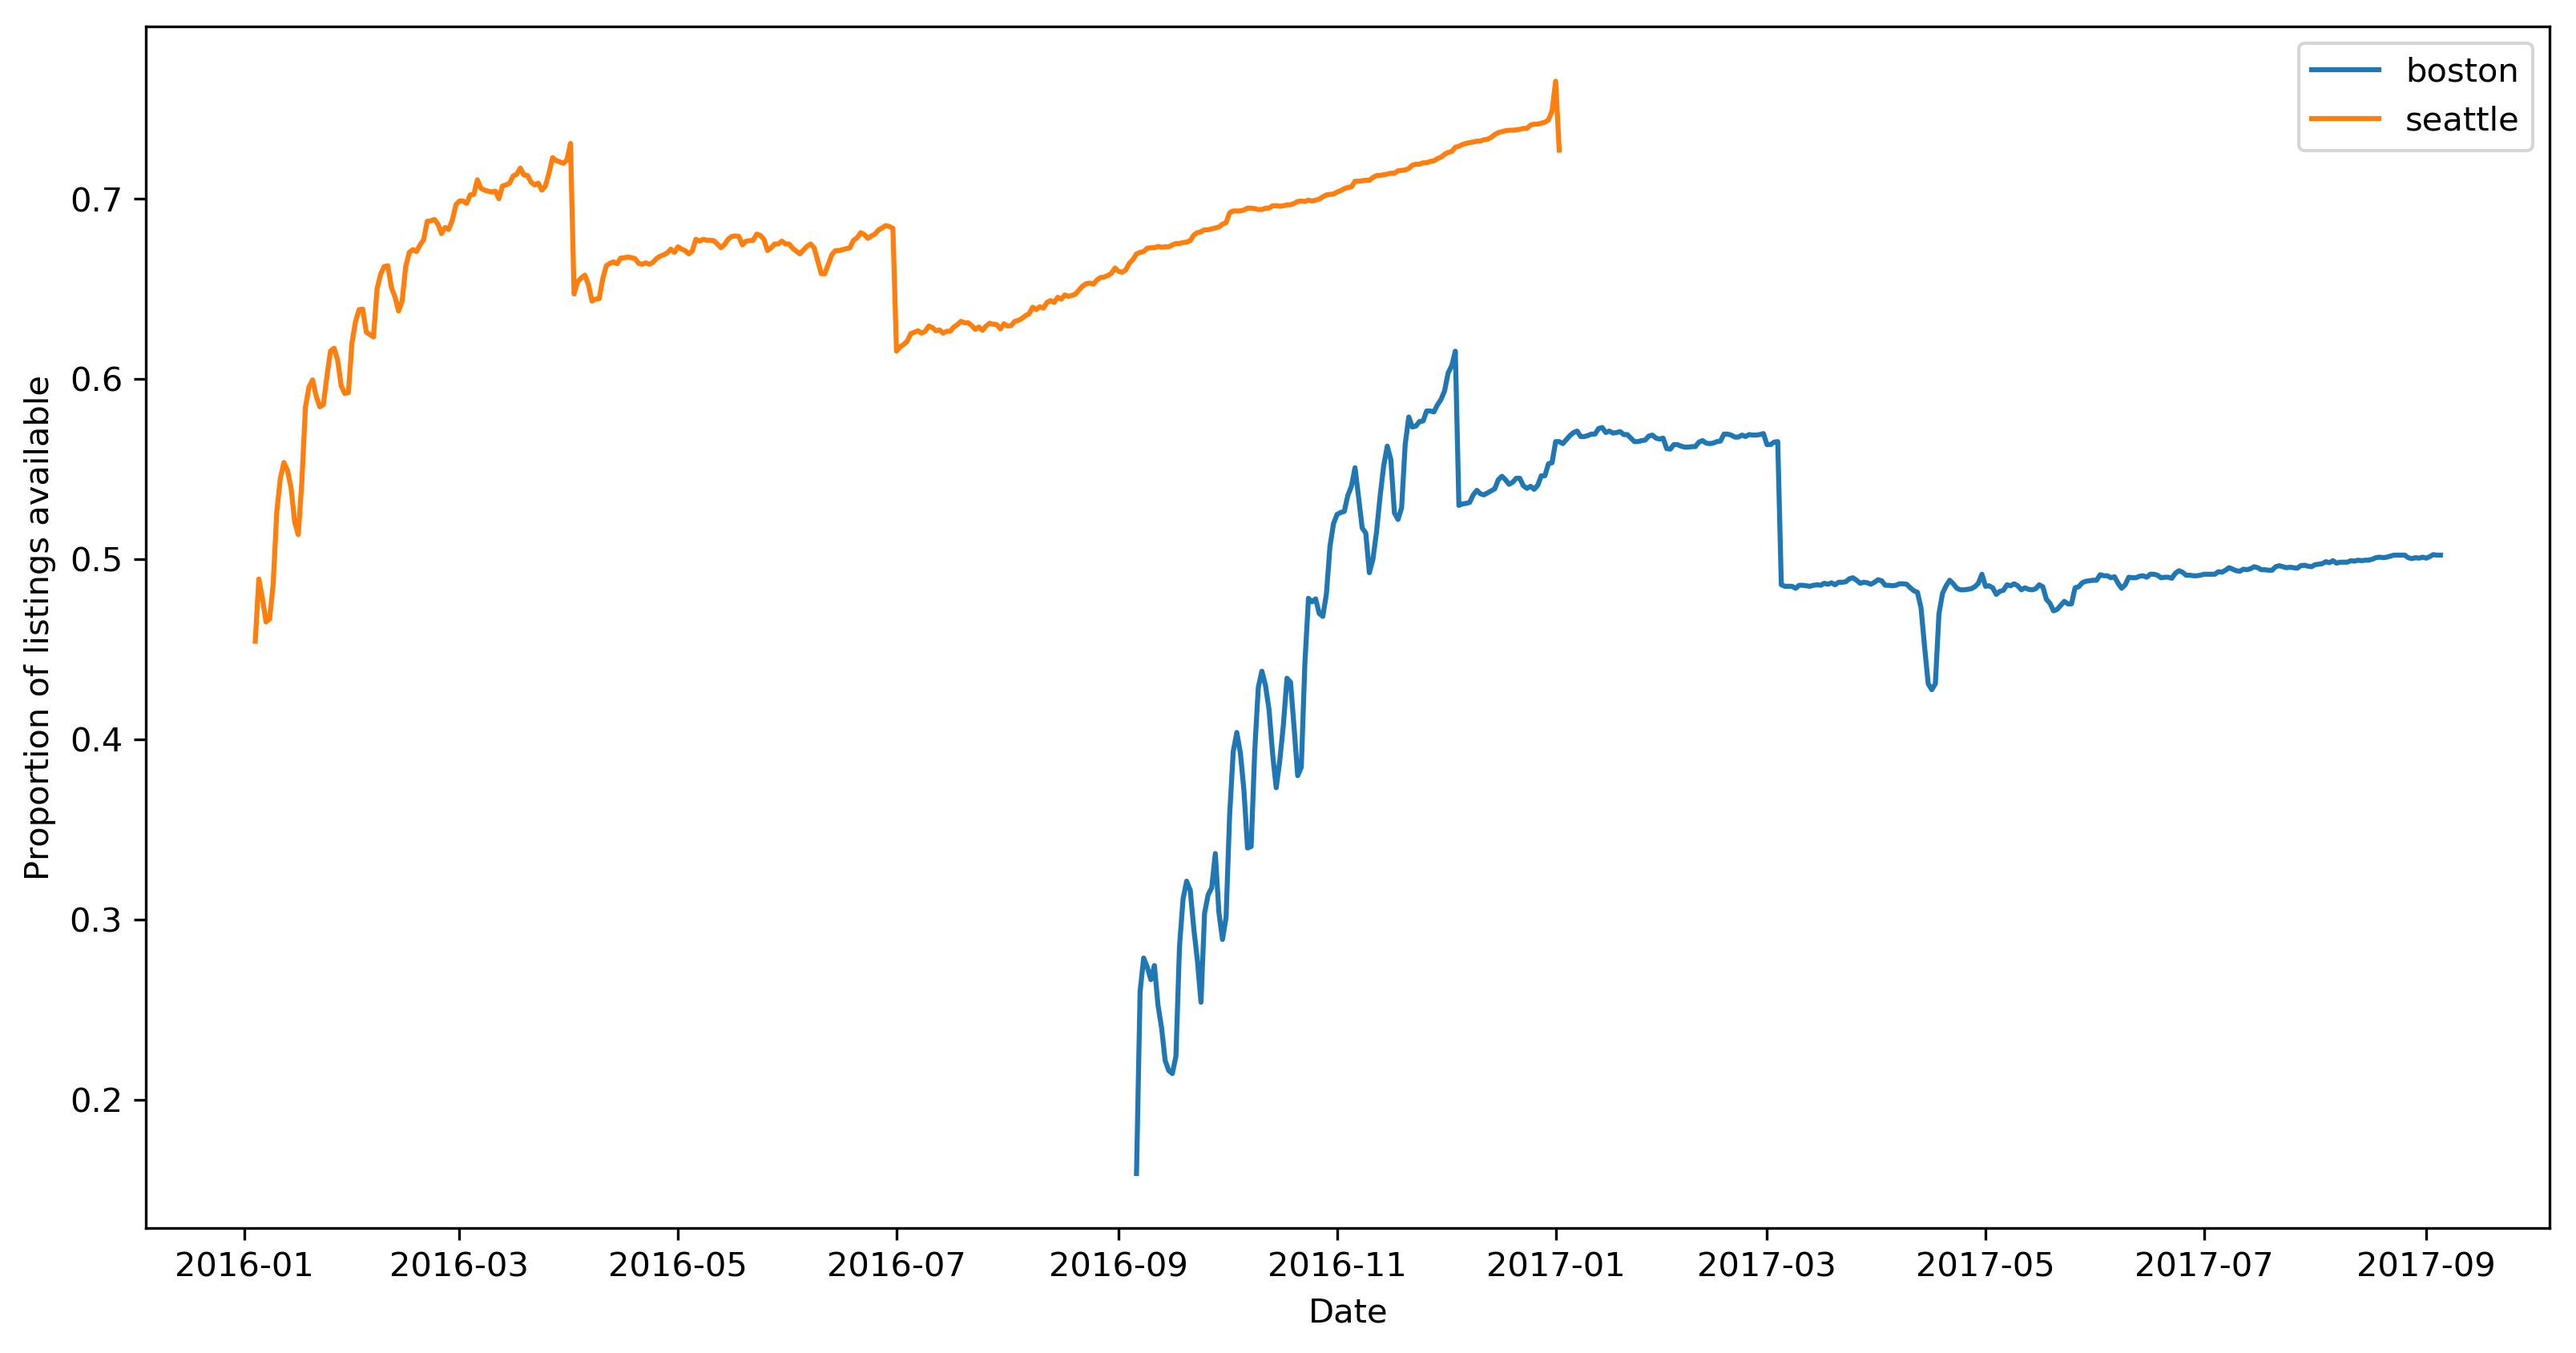

In [10]:
fig4 = plt.figure(figsize=(10,5),dpi=300)
ax4 = fig4.add_axes([0,0,1,1])
ax4.plot(boston_calendar.drop(['listing_id','price','day_of_year'],axis=1).groupby('date').mean(),label='boston')
ax4.plot(seattle_calendar.drop(['listing_id','price','day_of_year'],axis=1).groupby('date').mean(),label='seattle')
ax4.legend()
ax4.set_xlabel('Date')
ax4.set_ylabel('Proportion of listings available')
fig4.savefig('png\ListingsAvailableByDate.png', bbox_inches='tight')

### Question 3: Can we predict the review score from comments using regression? Do the comments of the visitors on a listing give us enough information for us to guess the review score of that listing

In [11]:
# Assess Seattle reviews table
seattle_review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [12]:
# Assess Seattle listings table
seattle_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [13]:
# Assess Seattle review-specific columns of the reviews table
seattle_listings.loc[:,[column for column in seattle_listings.columns if 'review' in column]].head()

,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,4.07
1,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.48
2,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1.15
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0.89


In [14]:
####  Below I create a reviews dataframe that concatenates all review strings into one per listing. Boston and Seattle data are also merged into one.

In [15]:
reviews = pd.DataFrame(columns=['comments'])

for item in seattle_review['listing_id'].unique():
        reviews.loc[item,'comments'] = seattle_review[seattle_review['listing_id']==item]['comments'].str.cat()

for item in boston_review['listing_id'].unique():
        reviews.loc[item,'comments'] = boston_review[boston_review['listing_id']==item]['comments'].str.cat()
        
review_score_rating = pd.concat([seattle_listings.loc[:,['id','review_scores_rating']],boston_listings.loc[:,['id','review_scores_rating']]])
reviews['review_scores_rating'] = reviews.index.map(review_score_rating.set_index('id')['review_scores_rating'])

In [16]:
# of listings without a valid review score
reviews.isnull().sum()

comments                 0
review_scores_rating    77
dtype: int64

In [17]:
# of listings without a valid review score that have a 'automated host cancellation message'
len([comment for comment in (reviews[reviews.isnull()['review_scores_rating']])['comments'] if 'auto' in comment])

76

## 3. Data Preparation

#### I will be dropping any reviews that have an NA value in either comments or scores for simplicity. There are 77 reviews with na review score, and 76 of them have been auto generated by system due to cancellation by the host.

#### Due to the low number of NA values, dropping these will not affect the data adversely.

In [18]:
reviews.dropna(inplace=True)

In [19]:
def preprocessor(text):
    """Takes in text, removes punctuation and returns it
    
    text (str) : Text to be preprocessed. Punctuation will be removed from the string and string will be returned.
    
    Returns:
    str: Text without any punctuation
    
    """
      
    text = re.sub(r"[^a-zA-Z0-9]"," ", text)
    text = re.sub(r"'","", text)
    return text

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## Define tokenizer, splitting text into tokens, while also removing stopwords, applying stemming and lemmatization as well
def tokenizer(text):
    """Splits text into tokens, removes stopwords, lemmatizes and stems, then returns resulting tokens
    
    text (str) : String to be tokenized. Firstly the string will be split into tokens. Then, it will be stripped from stop words.
    Finally, lemmatization and stemming will be applied to each token
    
    Returns:
    list : Tokenized text in list format
    
    """
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens]
    return tokens

#Initialize Vectorizers
CV = CountVectorizer(stop_words=None, tokenizer=tokenizer, preprocessor=preprocessor, lowercase=True)
TFIDF = TfidfVectorizer(stop_words=None, tokenizer = tokenizer, preprocessor=preprocessor, lowercase=True)

## 4. Modeling

In [20]:
#Initialize TFIDF Vectorizer with custom preprocessor and tokenizer
TFIDF = TfidfVectorizer(stop_words=None, tokenizer = tokenizer, preprocessor=preprocessor, max_features=1000)

#Create intermediate set which contains our train and validation sets, as well as
X_intermediate, X_test, y_intermediate, y_test = train_test_split(reviews['comments'], reviews['review_scores_rating'],
                                                                  shuffle=True,
                                                                  test_size=0.2)
#Set alphas and learning_rates to GridSearch upon for SGDR, XGBR and CatBoostReg
alphas = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
learning_rates = [1,0.1,0.01,0.001,0.0001,0.00001,0.000001]

kf = KFold(3, shuffle=True, random_state=21)

train_errors_sgdr = {a:[] for a in alphas}
val_errors_sgdr = {a:[] for a in alphas}
train_errors_xgb = {n:[] for n in learning_rates}
val_errors_xgb = {n:[] for n in learning_rates}
train_errors_cat = {n:[] for n in learning_rates}
val_errors_cat = {n:[] for n in learning_rates}


for train_index, val_index in kf.split(X_intermediate, y_intermediate):
    
    X_train, X_val = X_intermediate[X_intermediate.index[train_index]], X_intermediate[X_intermediate.index[val_index]]
    y_train, y_val = y_intermediate[y_intermediate.index[train_index]], y_intermediate[y_intermediate.index[val_index]]
    
    X_train = pd.DataFrame(TFIDF.fit_transform(X_train).toarray(), X_train.index)
    X_val = pd.DataFrame(TFIDF.transform(X_val).toarray(), X_val.index)
    
    #Stochastic Gradient Descent
    for alpha in alphas:
        #instantiate Stochastic Gradient Descent model and fit it
        sgdr = SGDRegressor(alpha=alpha, random_state=21).fit(X_train, y_train)
    
        #calculate errors
        yhat_train = sgdr.predict(X_train)
        yhat_val = sgdr.predict(X_val)
        train_error, val_error = mean_squared_error(y_train, yhat_train), mean_squared_error(y_val, yhat_val)
        train_errors_sgdr[alpha].append(train_error)
        val_errors_sgdr[alpha].append(val_error)
    
    for lr in learning_rates:
        
        # CatBoost Regressor
        cat = CatBoostRegressor(learning_rate=lr,random_seed=21,thread_count=4).fit(X_train, y_train)
        train_error_cat, val_error_cat = mean_squared_error(cat.predict(X_train), y_train), mean_squared_error(cat.predict(X_val), y_val)
        train_errors_cat[lr].append(train_error_cat)
        val_errors_cat[lr].append(val_error_cat)
        
        # XGBoost Regressor
        xgb = XGBRegressor(learning_rate=lr,random_seed=21,n_jobs=-1).fit(X_train, y_train)
        train_error_xgb, val_error_xgb = mean_squared_error(xgb.predict(X_train), y_train), mean_squared_error(xgb.predict(X_val), y_val)
        train_errors_xgb[lr].append(train_error_xgb)
        val_errors_xgb[lr].append(val_error_xgb)

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol

0:	learn: 9.9120273	total: 479ms	remaining: 7m 58s
1:	learn: 9.3703967	total: 790ms	remaining: 6m 34s
2:	learn: 8.9477146	total: 1.1s	remaining: 6m 7s
3:	learn: 8.5095862	total: 1.45s	remaining: 6m 1s
4:	learn: 8.4071119	total: 1.77s	remaining: 5m 51s
5:	learn: 8.3542900	total: 2.08s	remaining: 5m 45s
6:	learn: 7.9634062	total: 2.42s	remaining: 5m 43s
7:	learn: 7.9195563	total: 2.73s	remaining: 5m 38s
8:	learn: 7.8825489	total: 3.06s	remaining: 5m 37s
9:	learn: 7.7672579	total: 3.44s	remaining: 5m 40s
10:	learn: 7.3491277	total: 3.76s	remaining: 5m 38s
11:	learn: 7.0688091	total: 4.08s	remaining: 5m 36s
12:	learn: 7.0177396	total: 4.41s	remaining: 5m 34s
13:	learn: 6.9679603	total: 4.73s	remaining: 5m 32s
14:	learn: 6.9353352	total: 5.04s	remaining: 5m 31s
15:	learn: 6.9193686	total: 5.35s	remaining: 5m 29s
16:	learn: 6.8855140	total: 5.67s	remaining: 5m 27s
17:	learn: 6.7462388	total: 5.98s	remaining: 5m 26s
18:	learn: 6.7063728	total: 6.29s	remaining: 5m 24s
19:	learn: 6.6793264	tota

158:	learn: 4.7592603	total: 49.8s	remaining: 4m 23s
159:	learn: 4.7571218	total: 50.1s	remaining: 4m 23s
160:	learn: 4.7437250	total: 50.4s	remaining: 4m 22s
161:	learn: 4.7179864	total: 50.7s	remaining: 4m 22s
162:	learn: 4.7106763	total: 51s	remaining: 4m 22s
163:	learn: 4.7071745	total: 51.3s	remaining: 4m 21s
164:	learn: 4.7066525	total: 51.6s	remaining: 4m 21s
165:	learn: 4.7016279	total: 51.9s	remaining: 4m 20s
166:	learn: 4.6976742	total: 52.3s	remaining: 4m 20s
167:	learn: 4.6934597	total: 52.6s	remaining: 4m 20s
168:	learn: 4.6886988	total: 52.9s	remaining: 4m 19s
169:	learn: 4.6838865	total: 53.2s	remaining: 4m 19s
170:	learn: 4.6762956	total: 53.5s	remaining: 4m 19s
171:	learn: 4.6648361	total: 53.8s	remaining: 4m 18s
172:	learn: 4.6341916	total: 54.1s	remaining: 4m 18s
173:	learn: 4.6221522	total: 54.4s	remaining: 4m 18s
174:	learn: 4.6155439	total: 54.7s	remaining: 4m 17s
175:	learn: 4.6115611	total: 55s	remaining: 4m 17s
176:	learn: 4.6022745	total: 55.3s	remaining: 4m 1

313:	learn: 3.9912527	total: 1m 37s	remaining: 3m 33s
314:	learn: 3.9903128	total: 1m 37s	remaining: 3m 32s
315:	learn: 3.9770713	total: 1m 38s	remaining: 3m 32s
316:	learn: 3.9731675	total: 1m 38s	remaining: 3m 32s
317:	learn: 3.9716179	total: 1m 38s	remaining: 3m 31s
318:	learn: 3.9673126	total: 1m 39s	remaining: 3m 31s
319:	learn: 3.9638268	total: 1m 39s	remaining: 3m 31s
320:	learn: 3.9630542	total: 1m 39s	remaining: 3m 31s
321:	learn: 3.9620261	total: 1m 40s	remaining: 3m 30s
322:	learn: 3.9583188	total: 1m 40s	remaining: 3m 30s
323:	learn: 3.9573865	total: 1m 40s	remaining: 3m 30s
324:	learn: 3.9552516	total: 1m 40s	remaining: 3m 29s
325:	learn: 3.9513405	total: 1m 41s	remaining: 3m 29s
326:	learn: 3.9498766	total: 1m 41s	remaining: 3m 29s
327:	learn: 3.9478333	total: 1m 41s	remaining: 3m 28s
328:	learn: 3.9475552	total: 1m 42s	remaining: 3m 28s
329:	learn: 3.9458298	total: 1m 42s	remaining: 3m 28s
330:	learn: 3.9391970	total: 1m 42s	remaining: 3m 27s
331:	learn: 3.9376767	total:

467:	learn: 3.4679035	total: 2m 25s	remaining: 2m 45s
468:	learn: 3.4659673	total: 2m 25s	remaining: 2m 44s
469:	learn: 3.4655896	total: 2m 25s	remaining: 2m 44s
470:	learn: 3.4649319	total: 2m 26s	remaining: 2m 44s
471:	learn: 3.4549983	total: 2m 26s	remaining: 2m 44s
472:	learn: 3.4548900	total: 2m 26s	remaining: 2m 43s
473:	learn: 3.4536617	total: 2m 27s	remaining: 2m 43s
474:	learn: 3.4500019	total: 2m 27s	remaining: 2m 43s
475:	learn: 3.4435962	total: 2m 27s	remaining: 2m 42s
476:	learn: 3.4376963	total: 2m 28s	remaining: 2m 42s
477:	learn: 3.4360856	total: 2m 28s	remaining: 2m 42s
478:	learn: 3.4349999	total: 2m 28s	remaining: 2m 41s
479:	learn: 3.4340936	total: 2m 29s	remaining: 2m 41s
480:	learn: 3.4333105	total: 2m 29s	remaining: 2m 41s
481:	learn: 3.4329686	total: 2m 29s	remaining: 2m 40s
482:	learn: 3.4315744	total: 2m 30s	remaining: 2m 40s
483:	learn: 3.4309084	total: 2m 30s	remaining: 2m 40s
484:	learn: 3.4307713	total: 2m 30s	remaining: 2m 39s
485:	learn: 3.4281355	total:

621:	learn: 3.0793774	total: 3m 13s	remaining: 1m 57s
622:	learn: 3.0792060	total: 3m 13s	remaining: 1m 57s
623:	learn: 3.0714861	total: 3m 13s	remaining: 1m 56s
624:	learn: 3.0688496	total: 3m 14s	remaining: 1m 56s
625:	learn: 3.0686379	total: 3m 14s	remaining: 1m 56s
626:	learn: 3.0682470	total: 3m 14s	remaining: 1m 55s
627:	learn: 3.0676801	total: 3m 15s	remaining: 1m 55s
628:	learn: 3.0657834	total: 3m 15s	remaining: 1m 55s
629:	learn: 3.0642754	total: 3m 15s	remaining: 1m 54s
630:	learn: 3.0619920	total: 3m 16s	remaining: 1m 54s
631:	learn: 3.0583133	total: 3m 16s	remaining: 1m 54s
632:	learn: 3.0570093	total: 3m 16s	remaining: 1m 54s
633:	learn: 3.0541222	total: 3m 16s	remaining: 1m 53s
634:	learn: 3.0515629	total: 3m 17s	remaining: 1m 53s
635:	learn: 3.0492755	total: 3m 17s	remaining: 1m 53s
636:	learn: 3.0450188	total: 3m 17s	remaining: 1m 52s
637:	learn: 3.0444876	total: 3m 18s	remaining: 1m 52s
638:	learn: 3.0435566	total: 3m 18s	remaining: 1m 52s
639:	learn: 3.0401043	total:

773:	learn: 2.7160754	total: 4m	remaining: 1m 10s
774:	learn: 2.7143292	total: 4m	remaining: 1m 9s
775:	learn: 2.7121439	total: 4m 1s	remaining: 1m 9s
776:	learn: 2.7107891	total: 4m 1s	remaining: 1m 9s
777:	learn: 2.7099473	total: 4m 1s	remaining: 1m 8s
778:	learn: 2.7097384	total: 4m 2s	remaining: 1m 8s
779:	learn: 2.7091854	total: 4m 2s	remaining: 1m 8s
780:	learn: 2.7090623	total: 4m 2s	remaining: 1m 8s
781:	learn: 2.7084039	total: 4m 3s	remaining: 1m 7s
782:	learn: 2.7078932	total: 4m 3s	remaining: 1m 7s
783:	learn: 2.7070516	total: 4m 3s	remaining: 1m 7s
784:	learn: 2.7048067	total: 4m 3s	remaining: 1m 6s
785:	learn: 2.7034228	total: 4m 4s	remaining: 1m 6s
786:	learn: 2.7027448	total: 4m 4s	remaining: 1m 6s
787:	learn: 2.7015654	total: 4m 4s	remaining: 1m 5s
788:	learn: 2.6980275	total: 4m 5s	remaining: 1m 5s
789:	learn: 2.6962284	total: 4m 5s	remaining: 1m 5s
790:	learn: 2.6953391	total: 4m 5s	remaining: 1m 4s
791:	learn: 2.6882733	total: 4m 6s	remaining: 1m 4s
792:	learn: 2.687

929:	learn: 2.5268440	total: 4m 48s	remaining: 21.7s
930:	learn: 2.5262872	total: 4m 48s	remaining: 21.4s
931:	learn: 2.5210097	total: 4m 49s	remaining: 21.1s
932:	learn: 2.5154223	total: 4m 49s	remaining: 20.8s
933:	learn: 2.5134018	total: 4m 49s	remaining: 20.5s
934:	learn: 2.5126306	total: 4m 50s	remaining: 20.2s
935:	learn: 2.5122980	total: 4m 50s	remaining: 19.9s
936:	learn: 2.5117377	total: 4m 50s	remaining: 19.5s
937:	learn: 2.5114956	total: 4m 51s	remaining: 19.2s
938:	learn: 2.5107961	total: 4m 51s	remaining: 18.9s
939:	learn: 2.5099873	total: 4m 51s	remaining: 18.6s
940:	learn: 2.5099057	total: 4m 51s	remaining: 18.3s
941:	learn: 2.5095460	total: 4m 52s	remaining: 18s
942:	learn: 2.5012281	total: 4m 52s	remaining: 17.7s
943:	learn: 2.5006329	total: 4m 52s	remaining: 17.4s
944:	learn: 2.4971223	total: 4m 53s	remaining: 17.1s
945:	learn: 2.4965494	total: 4m 53s	remaining: 16.8s
946:	learn: 2.4964858	total: 4m 53s	remaining: 16.4s
947:	learn: 2.4960946	total: 4m 54s	remaining: 1

87:	learn: 6.1168103	total: 28.2s	remaining: 4m 52s
88:	learn: 6.0982244	total: 28.5s	remaining: 4m 52s
89:	learn: 6.0728324	total: 28.9s	remaining: 4m 51s
90:	learn: 6.0437296	total: 29.2s	remaining: 4m 51s
91:	learn: 6.0218074	total: 29.5s	remaining: 4m 51s
92:	learn: 6.0121125	total: 29.8s	remaining: 4m 50s
93:	learn: 5.9867475	total: 30.1s	remaining: 4m 50s
94:	learn: 5.9661787	total: 30.5s	remaining: 4m 50s
95:	learn: 5.9307158	total: 30.8s	remaining: 4m 49s
96:	learn: 5.9169473	total: 31.1s	remaining: 4m 49s
97:	learn: 5.9015223	total: 31.4s	remaining: 4m 49s
98:	learn: 5.8796636	total: 31.7s	remaining: 4m 48s
99:	learn: 5.8598402	total: 32.1s	remaining: 4m 48s
100:	learn: 5.8415967	total: 32.4s	remaining: 4m 48s
101:	learn: 5.8187829	total: 32.7s	remaining: 4m 47s
102:	learn: 5.8023731	total: 33s	remaining: 4m 47s
103:	learn: 5.7808669	total: 33.3s	remaining: 4m 47s
104:	learn: 5.7677052	total: 33.6s	remaining: 4m 46s
105:	learn: 5.7536882	total: 34s	remaining: 4m 46s
106:	learn

243:	learn: 4.7942451	total: 1m 16s	remaining: 3m 58s
244:	learn: 4.7926695	total: 1m 17s	remaining: 3m 57s
245:	learn: 4.7897025	total: 1m 17s	remaining: 3m 57s
246:	learn: 4.7851822	total: 1m 17s	remaining: 3m 57s
247:	learn: 4.7780660	total: 1m 18s	remaining: 3m 56s
248:	learn: 4.7763698	total: 1m 18s	remaining: 3m 56s
249:	learn: 4.7750123	total: 1m 18s	remaining: 3m 56s
250:	learn: 4.7716175	total: 1m 19s	remaining: 3m 55s
251:	learn: 4.7657528	total: 1m 19s	remaining: 3m 55s
252:	learn: 4.7642654	total: 1m 19s	remaining: 3m 55s
253:	learn: 4.7581040	total: 1m 20s	remaining: 3m 54s
254:	learn: 4.7511770	total: 1m 20s	remaining: 3m 54s
255:	learn: 4.7495906	total: 1m 20s	remaining: 3m 54s
256:	learn: 4.7460092	total: 1m 20s	remaining: 3m 53s
257:	learn: 4.7436381	total: 1m 21s	remaining: 3m 53s
258:	learn: 4.7407444	total: 1m 21s	remaining: 3m 53s
259:	learn: 4.7399620	total: 1m 21s	remaining: 3m 52s
260:	learn: 4.7243687	total: 1m 22s	remaining: 3m 52s
261:	learn: 4.7223282	total:

396:	learn: 4.3966895	total: 2m 4s	remaining: 3m 8s
397:	learn: 4.3959052	total: 2m 4s	remaining: 3m 8s
398:	learn: 4.3932414	total: 2m 4s	remaining: 3m 8s
399:	learn: 4.3924353	total: 2m 5s	remaining: 3m 7s
400:	learn: 4.3921945	total: 2m 5s	remaining: 3m 7s
401:	learn: 4.3902934	total: 2m 5s	remaining: 3m 7s
402:	learn: 4.3878547	total: 2m 6s	remaining: 3m 6s
403:	learn: 4.3870708	total: 2m 6s	remaining: 3m 6s
404:	learn: 4.3853177	total: 2m 6s	remaining: 3m 6s
405:	learn: 4.3845183	total: 2m 6s	remaining: 3m 5s
406:	learn: 4.3840132	total: 2m 7s	remaining: 3m 5s
407:	learn: 4.3838255	total: 2m 7s	remaining: 3m 5s
408:	learn: 4.3834485	total: 2m 7s	remaining: 3m 4s
409:	learn: 4.3815536	total: 2m 8s	remaining: 3m 4s
410:	learn: 4.3805013	total: 2m 8s	remaining: 3m 4s
411:	learn: 4.3750583	total: 2m 8s	remaining: 3m 3s
412:	learn: 4.3692984	total: 2m 9s	remaining: 3m 3s
413:	learn: 4.3664672	total: 2m 9s	remaining: 3m 3s
414:	learn: 4.3651594	total: 2m 9s	remaining: 3m 2s
415:	learn: 

549:	learn: 4.1317192	total: 2m 51s	remaining: 2m 20s
550:	learn: 4.1313199	total: 2m 51s	remaining: 2m 20s
551:	learn: 4.1281432	total: 2m 52s	remaining: 2m 19s
552:	learn: 4.1275377	total: 2m 52s	remaining: 2m 19s
553:	learn: 4.1268611	total: 2m 52s	remaining: 2m 19s
554:	learn: 4.1253185	total: 2m 53s	remaining: 2m 18s
555:	learn: 4.1247502	total: 2m 53s	remaining: 2m 18s
556:	learn: 4.1242118	total: 2m 53s	remaining: 2m 18s
557:	learn: 4.1235262	total: 2m 54s	remaining: 2m 17s
558:	learn: 4.1232139	total: 2m 54s	remaining: 2m 17s
559:	learn: 4.1227926	total: 2m 54s	remaining: 2m 17s
560:	learn: 4.1214495	total: 2m 54s	remaining: 2m 16s
561:	learn: 4.1210073	total: 2m 55s	remaining: 2m 16s
562:	learn: 4.1203904	total: 2m 55s	remaining: 2m 16s
563:	learn: 4.1151680	total: 2m 55s	remaining: 2m 15s
564:	learn: 4.1149801	total: 2m 56s	remaining: 2m 15s
565:	learn: 4.1148622	total: 2m 56s	remaining: 2m 15s
566:	learn: 4.1146382	total: 2m 56s	remaining: 2m 15s
567:	learn: 4.1140923	total:

703:	learn: 3.9500336	total: 3m 39s	remaining: 1m 32s
704:	learn: 3.9497967	total: 3m 39s	remaining: 1m 31s
705:	learn: 3.9493375	total: 3m 39s	remaining: 1m 31s
706:	learn: 3.9484680	total: 3m 39s	remaining: 1m 31s
707:	learn: 3.9479681	total: 3m 40s	remaining: 1m 30s
708:	learn: 3.9404376	total: 3m 40s	remaining: 1m 30s
709:	learn: 3.9388008	total: 3m 40s	remaining: 1m 30s
710:	learn: 3.9386244	total: 3m 41s	remaining: 1m 29s
711:	learn: 3.9373980	total: 3m 41s	remaining: 1m 29s
712:	learn: 3.9346618	total: 3m 41s	remaining: 1m 29s
713:	learn: 3.9333576	total: 3m 42s	remaining: 1m 28s
714:	learn: 3.9308422	total: 3m 42s	remaining: 1m 28s
715:	learn: 3.9303592	total: 3m 42s	remaining: 1m 28s
716:	learn: 3.9299659	total: 3m 43s	remaining: 1m 28s
717:	learn: 3.9293138	total: 3m 43s	remaining: 1m 27s
718:	learn: 3.9284610	total: 3m 43s	remaining: 1m 27s
719:	learn: 3.9281213	total: 3m 43s	remaining: 1m 27s
720:	learn: 3.9266424	total: 3m 44s	remaining: 1m 26s
721:	learn: 3.9265194	total:

858:	learn: 3.7927305	total: 4m 27s	remaining: 43.9s
859:	learn: 3.7926980	total: 4m 27s	remaining: 43.6s
860:	learn: 3.7923165	total: 4m 28s	remaining: 43.3s
861:	learn: 3.7921744	total: 4m 28s	remaining: 43s
862:	learn: 3.7883312	total: 4m 28s	remaining: 42.6s
863:	learn: 3.7881865	total: 4m 28s	remaining: 42.3s
864:	learn: 3.7878493	total: 4m 29s	remaining: 42s
865:	learn: 3.7877344	total: 4m 29s	remaining: 41.7s
866:	learn: 3.7872826	total: 4m 29s	remaining: 41.4s
867:	learn: 3.7855193	total: 4m 30s	remaining: 41.1s
868:	learn: 3.7853323	total: 4m 30s	remaining: 40.8s
869:	learn: 3.7842085	total: 4m 30s	remaining: 40.5s
870:	learn: 3.7839527	total: 4m 31s	remaining: 40.2s
871:	learn: 3.7764473	total: 4m 31s	remaining: 39.8s
872:	learn: 3.7758208	total: 4m 31s	remaining: 39.5s
873:	learn: 3.7742911	total: 4m 32s	remaining: 39.2s
874:	learn: 3.7741128	total: 4m 32s	remaining: 38.9s
875:	learn: 3.7738302	total: 4m 32s	remaining: 38.6s
876:	learn: 3.7737465	total: 4m 33s	remaining: 38.

15:	learn: 80.0082840	total: 5.29s	remaining: 5m 25s
16:	learn: 79.2269836	total: 5.6s	remaining: 5m 24s
17:	learn: 78.4621567	total: 5.93s	remaining: 5m 23s
18:	learn: 77.7025557	total: 6.25s	remaining: 5m 22s
19:	learn: 76.9485719	total: 6.58s	remaining: 5m 22s
20:	learn: 76.2095697	total: 6.9s	remaining: 5m 21s
21:	learn: 75.4625163	total: 7.21s	remaining: 5m 20s
22:	learn: 74.7288746	total: 7.54s	remaining: 5m 20s
23:	learn: 74.0055443	total: 7.86s	remaining: 5m 19s
24:	learn: 73.2941770	total: 8.18s	remaining: 5m 18s
25:	learn: 72.5826208	total: 8.49s	remaining: 5m 18s
26:	learn: 71.8800611	total: 8.81s	remaining: 5m 17s
27:	learn: 71.1822456	total: 9.13s	remaining: 5m 16s
28:	learn: 70.4911301	total: 9.44s	remaining: 5m 16s
29:	learn: 69.8050466	total: 9.76s	remaining: 5m 15s
30:	learn: 69.1243281	total: 10.1s	remaining: 5m 14s
31:	learn: 68.4572235	total: 10.4s	remaining: 5m 14s
32:	learn: 67.7905459	total: 10.7s	remaining: 5m 13s
33:	learn: 67.1365134	total: 11s	remaining: 5m 1

170:	learn: 18.9219128	total: 54s	remaining: 4m 21s
171:	learn: 18.7664687	total: 54.3s	remaining: 4m 21s
172:	learn: 18.6132530	total: 54.6s	remaining: 4m 21s
173:	learn: 18.4621944	total: 54.9s	remaining: 4m 20s
174:	learn: 18.3125216	total: 55.2s	remaining: 4m 20s
175:	learn: 18.1636623	total: 55.6s	remaining: 4m 20s
176:	learn: 18.0162293	total: 55.9s	remaining: 4m 19s
177:	learn: 17.8706664	total: 56.2s	remaining: 4m 19s
178:	learn: 17.7271755	total: 56.5s	remaining: 4m 19s
179:	learn: 17.5855407	total: 56.8s	remaining: 4m 18s
180:	learn: 17.4464800	total: 57.1s	remaining: 4m 18s
181:	learn: 17.3093085	total: 57.4s	remaining: 4m 18s
182:	learn: 17.1711418	total: 57.8s	remaining: 4m 17s
183:	learn: 17.0359741	total: 58.1s	remaining: 4m 17s
184:	learn: 16.9027322	total: 58.4s	remaining: 4m 17s
185:	learn: 16.7708655	total: 58.7s	remaining: 4m 16s
186:	learn: 16.6399717	total: 59s	remaining: 4m 16s
187:	learn: 16.5108450	total: 59.4s	remaining: 4m 16s
188:	learn: 16.3842124	total: 59

322:	learn: 8.2781370	total: 1m 42s	remaining: 3m 34s
323:	learn: 8.2594909	total: 1m 42s	remaining: 3m 34s
324:	learn: 8.2404175	total: 1m 42s	remaining: 3m 33s
325:	learn: 8.2196971	total: 1m 43s	remaining: 3m 33s
326:	learn: 8.1982973	total: 1m 43s	remaining: 3m 33s
327:	learn: 8.1805355	total: 1m 43s	remaining: 3m 32s
328:	learn: 8.1593649	total: 1m 44s	remaining: 3m 32s
329:	learn: 8.1413057	total: 1m 44s	remaining: 3m 32s
330:	learn: 8.1227493	total: 1m 44s	remaining: 3m 31s
331:	learn: 8.1043221	total: 1m 45s	remaining: 3m 31s
332:	learn: 8.0851863	total: 1m 45s	remaining: 3m 31s
333:	learn: 8.0673645	total: 1m 45s	remaining: 3m 31s
334:	learn: 8.0489408	total: 1m 46s	remaining: 3m 30s
335:	learn: 8.0306262	total: 1m 46s	remaining: 3m 30s
336:	learn: 8.0140816	total: 1m 46s	remaining: 3m 30s
337:	learn: 7.9987979	total: 1m 47s	remaining: 3m 29s
338:	learn: 7.9801827	total: 1m 47s	remaining: 3m 29s
339:	learn: 7.9625345	total: 1m 47s	remaining: 3m 29s
340:	learn: 7.9443126	total:

476:	learn: 6.7545466	total: 2m 31s	remaining: 2m 45s
477:	learn: 6.7496032	total: 2m 31s	remaining: 2m 45s
478:	learn: 6.7471213	total: 2m 31s	remaining: 2m 45s
479:	learn: 6.7419469	total: 2m 32s	remaining: 2m 44s
480:	learn: 6.7376561	total: 2m 32s	remaining: 2m 44s
481:	learn: 6.7341445	total: 2m 32s	remaining: 2m 44s
482:	learn: 6.7304996	total: 2m 32s	remaining: 2m 43s
483:	learn: 6.7258918	total: 2m 33s	remaining: 2m 43s
484:	learn: 6.7219847	total: 2m 33s	remaining: 2m 43s
485:	learn: 6.7200616	total: 2m 33s	remaining: 2m 42s
486:	learn: 6.7161997	total: 2m 34s	remaining: 2m 42s
487:	learn: 6.7116606	total: 2m 34s	remaining: 2m 42s
488:	learn: 6.7054988	total: 2m 34s	remaining: 2m 41s
489:	learn: 6.7012963	total: 2m 35s	remaining: 2m 41s
490:	learn: 6.6971655	total: 2m 35s	remaining: 2m 41s
491:	learn: 6.6943546	total: 2m 35s	remaining: 2m 40s
492:	learn: 6.6908646	total: 2m 36s	remaining: 2m 40s
493:	learn: 6.6878813	total: 2m 36s	remaining: 2m 40s
494:	learn: 6.6839816	total:

630:	learn: 6.3361934	total: 3m 19s	remaining: 1m 56s
631:	learn: 6.3336973	total: 3m 19s	remaining: 1m 56s
632:	learn: 6.3329791	total: 3m 19s	remaining: 1m 55s
633:	learn: 6.3320817	total: 3m 20s	remaining: 1m 55s
634:	learn: 6.3305358	total: 3m 20s	remaining: 1m 55s
635:	learn: 6.3297010	total: 3m 20s	remaining: 1m 54s
636:	learn: 6.3286633	total: 3m 21s	remaining: 1m 54s
637:	learn: 6.3265316	total: 3m 21s	remaining: 1m 54s
638:	learn: 6.3249182	total: 3m 21s	remaining: 1m 53s
639:	learn: 6.3232921	total: 3m 22s	remaining: 1m 53s
640:	learn: 6.3219844	total: 3m 22s	remaining: 1m 53s
641:	learn: 6.3192063	total: 3m 22s	remaining: 1m 53s
642:	learn: 6.3179465	total: 3m 22s	remaining: 1m 52s
643:	learn: 6.3159790	total: 3m 23s	remaining: 1m 52s
644:	learn: 6.3121957	total: 3m 23s	remaining: 1m 52s
645:	learn: 6.3112391	total: 3m 23s	remaining: 1m 51s
646:	learn: 6.3104653	total: 3m 24s	remaining: 1m 51s
647:	learn: 6.3098148	total: 3m 24s	remaining: 1m 51s
648:	learn: 6.3088843	total:

783:	learn: 6.1277239	total: 4m 6s	remaining: 1m 7s
784:	learn: 6.1259816	total: 4m 6s	remaining: 1m 7s
785:	learn: 6.1254036	total: 4m 6s	remaining: 1m 7s
786:	learn: 6.1237888	total: 4m 7s	remaining: 1m 6s
787:	learn: 6.1231311	total: 4m 7s	remaining: 1m 6s
788:	learn: 6.1194898	total: 4m 7s	remaining: 1m 6s
789:	learn: 6.1170463	total: 4m 8s	remaining: 1m 5s
790:	learn: 6.1157374	total: 4m 8s	remaining: 1m 5s
791:	learn: 6.1144948	total: 4m 8s	remaining: 1m 5s
792:	learn: 6.1140069	total: 4m 9s	remaining: 1m 5s
793:	learn: 6.1137150	total: 4m 9s	remaining: 1m 4s
794:	learn: 6.1132676	total: 4m 9s	remaining: 1m 4s
795:	learn: 6.1115630	total: 4m 9s	remaining: 1m 4s
796:	learn: 6.1112583	total: 4m 10s	remaining: 1m 3s
797:	learn: 6.1098688	total: 4m 10s	remaining: 1m 3s
798:	learn: 6.1091591	total: 4m 10s	remaining: 1m 3s
799:	learn: 6.1082359	total: 4m 11s	remaining: 1m 2s
800:	learn: 6.1058209	total: 4m 11s	remaining: 1m 2s
801:	learn: 6.1051616	total: 4m 11s	remaining: 1m 2s
802:	l

939:	learn: 5.8688434	total: 4m 54s	remaining: 18.8s
940:	learn: 5.8670892	total: 4m 54s	remaining: 18.5s
941:	learn: 5.8639746	total: 4m 55s	remaining: 18.2s
942:	learn: 5.8626194	total: 4m 55s	remaining: 17.9s
943:	learn: 5.8612346	total: 4m 55s	remaining: 17.5s
944:	learn: 5.8581769	total: 4m 55s	remaining: 17.2s
945:	learn: 5.8563397	total: 4m 56s	remaining: 16.9s
946:	learn: 5.8547881	total: 4m 56s	remaining: 16.6s
947:	learn: 5.8534007	total: 4m 56s	remaining: 16.3s
948:	learn: 5.8509156	total: 4m 57s	remaining: 16s
949:	learn: 5.8500155	total: 4m 57s	remaining: 15.7s
950:	learn: 5.8489892	total: 4m 57s	remaining: 15.3s
951:	learn: 5.8474082	total: 4m 58s	remaining: 15s
952:	learn: 5.8456782	total: 4m 58s	remaining: 14.7s
953:	learn: 5.8440357	total: 4m 58s	remaining: 14.4s
954:	learn: 5.8429049	total: 4m 59s	remaining: 14.1s
955:	learn: 5.8415621	total: 4m 59s	remaining: 13.8s
956:	learn: 5.8402721	total: 4m 59s	remaining: 13.5s
957:	learn: 5.8380301	total: 4m 59s	remaining: 13.

96:	learn: 85.1320885	total: 30.9s	remaining: 4m 47s
97:	learn: 85.0498341	total: 31.2s	remaining: 4m 47s
98:	learn: 84.9666694	total: 31.5s	remaining: 4m 46s
99:	learn: 84.8838908	total: 31.8s	remaining: 4m 46s
100:	learn: 84.8010397	total: 32.1s	remaining: 4m 46s
101:	learn: 84.7183721	total: 32.5s	remaining: 4m 45s
102:	learn: 84.6357259	total: 32.8s	remaining: 4m 45s
103:	learn: 84.5534811	total: 33.1s	remaining: 4m 45s
104:	learn: 84.4704873	total: 33.4s	remaining: 4m 44s
105:	learn: 84.3879779	total: 33.7s	remaining: 4m 44s
106:	learn: 84.3056047	total: 34s	remaining: 4m 43s
107:	learn: 84.2241948	total: 34.4s	remaining: 4m 43s
108:	learn: 84.1419463	total: 34.7s	remaining: 4m 43s
109:	learn: 84.0598582	total: 35s	remaining: 4m 43s
110:	learn: 83.9784685	total: 35.4s	remaining: 4m 43s
111:	learn: 83.8962917	total: 35.7s	remaining: 4m 42s
112:	learn: 83.8146967	total: 36s	remaining: 4m 42s
113:	learn: 83.7337215	total: 36.3s	remaining: 4m 42s
114:	learn: 83.6527164	total: 36.6s	re

249:	learn: 73.3692468	total: 1m 18s	remaining: 3m 56s
250:	learn: 73.2980226	total: 1m 19s	remaining: 3m 56s
251:	learn: 73.2267869	total: 1m 19s	remaining: 3m 55s
252:	learn: 73.1553192	total: 1m 19s	remaining: 3m 55s
253:	learn: 73.0839818	total: 1m 20s	remaining: 3m 55s
254:	learn: 73.0126040	total: 1m 20s	remaining: 3m 54s
255:	learn: 72.9412211	total: 1m 20s	remaining: 3m 54s
256:	learn: 72.8702732	total: 1m 21s	remaining: 3m 54s
257:	learn: 72.7992528	total: 1m 21s	remaining: 3m 53s
258:	learn: 72.7286505	total: 1m 21s	remaining: 3m 53s
259:	learn: 72.6575984	total: 1m 21s	remaining: 3m 53s
260:	learn: 72.5870759	total: 1m 22s	remaining: 3m 52s
261:	learn: 72.5169301	total: 1m 22s	remaining: 3m 52s
262:	learn: 72.4463321	total: 1m 22s	remaining: 3m 52s
263:	learn: 72.3759704	total: 1m 23s	remaining: 3m 51s
264:	learn: 72.3058705	total: 1m 23s	remaining: 3m 51s
265:	learn: 72.2357265	total: 1m 23s	remaining: 3m 51s
266:	learn: 72.1657319	total: 1m 24s	remaining: 3m 51s
267:	learn

399:	learn: 63.4427479	total: 2m 6s	remaining: 3m 9s
400:	learn: 63.3809617	total: 2m 6s	remaining: 3m 9s
401:	learn: 63.3201841	total: 2m 6s	remaining: 3m 8s
402:	learn: 63.2590002	total: 2m 7s	remaining: 3m 8s
403:	learn: 63.1979395	total: 2m 7s	remaining: 3m 8s
404:	learn: 63.1370740	total: 2m 7s	remaining: 3m 7s
405:	learn: 63.0767797	total: 2m 8s	remaining: 3m 7s
406:	learn: 63.0154381	total: 2m 8s	remaining: 3m 7s
407:	learn: 62.9544875	total: 2m 8s	remaining: 3m 6s
408:	learn: 62.8935591	total: 2m 9s	remaining: 3m 6s
409:	learn: 62.8330340	total: 2m 9s	remaining: 3m 6s
410:	learn: 62.7724745	total: 2m 9s	remaining: 3m 5s
411:	learn: 62.7115216	total: 2m 9s	remaining: 3m 5s
412:	learn: 62.6506263	total: 2m 10s	remaining: 3m 5s
413:	learn: 62.5903787	total: 2m 10s	remaining: 3m 4s
414:	learn: 62.5298044	total: 2m 10s	remaining: 3m 4s
415:	learn: 62.4699620	total: 2m 11s	remaining: 3m 4s
416:	learn: 62.4096896	total: 2m 11s	remaining: 3m 3s
417:	learn: 62.3493168	total: 2m 11s	rema

549:	learn: 54.9021849	total: 2m 53s	remaining: 2m 21s
550:	learn: 54.8494577	total: 2m 53s	remaining: 2m 21s
551:	learn: 54.7965736	total: 2m 53s	remaining: 2m 21s
552:	learn: 54.7438701	total: 2m 54s	remaining: 2m 20s
553:	learn: 54.6911731	total: 2m 54s	remaining: 2m 20s
554:	learn: 54.6388983	total: 2m 54s	remaining: 2m 20s
555:	learn: 54.5860742	total: 2m 55s	remaining: 2m 19s
556:	learn: 54.5335614	total: 2m 55s	remaining: 2m 19s
557:	learn: 54.4810047	total: 2m 55s	remaining: 2m 19s
558:	learn: 54.4291497	total: 2m 56s	remaining: 2m 18s
559:	learn: 54.3766061	total: 2m 56s	remaining: 2m 18s
560:	learn: 54.3244472	total: 2m 56s	remaining: 2m 18s
561:	learn: 54.2720989	total: 2m 56s	remaining: 2m 17s
562:	learn: 54.2197306	total: 2m 57s	remaining: 2m 17s
563:	learn: 54.1676985	total: 2m 57s	remaining: 2m 17s
564:	learn: 54.1153912	total: 2m 57s	remaining: 2m 16s
565:	learn: 54.0631274	total: 2m 58s	remaining: 2m 16s
566:	learn: 54.0111548	total: 2m 58s	remaining: 2m 16s
567:	learn

700:	learn: 47.5084059	total: 3m 40s	remaining: 1m 34s
701:	learn: 47.4633924	total: 3m 40s	remaining: 1m 33s
702:	learn: 47.4181038	total: 3m 41s	remaining: 1m 33s
703:	learn: 47.3727034	total: 3m 41s	remaining: 1m 33s
704:	learn: 47.3277109	total: 3m 41s	remaining: 1m 32s
705:	learn: 47.2827202	total: 3m 42s	remaining: 1m 32s
706:	learn: 47.2376226	total: 3m 42s	remaining: 1m 32s
707:	learn: 47.1923863	total: 3m 42s	remaining: 1m 31s
708:	learn: 47.1474484	total: 3m 43s	remaining: 1m 31s
709:	learn: 47.1027096	total: 3m 43s	remaining: 1m 31s
710:	learn: 47.0575181	total: 3m 43s	remaining: 1m 30s
711:	learn: 47.0125168	total: 3m 44s	remaining: 1m 30s
712:	learn: 46.9673454	total: 3m 44s	remaining: 1m 30s
713:	learn: 46.9224276	total: 3m 44s	remaining: 1m 29s
714:	learn: 46.8773310	total: 3m 44s	remaining: 1m 29s
715:	learn: 46.8322202	total: 3m 45s	remaining: 1m 29s
716:	learn: 46.7873967	total: 3m 45s	remaining: 1m 29s
717:	learn: 46.7427976	total: 3m 45s	remaining: 1m 28s
718:	learn

852:	learn: 41.1185332	total: 4m 28s	remaining: 46.2s
853:	learn: 41.0799496	total: 4m 28s	remaining: 45.9s
854:	learn: 41.0417495	total: 4m 28s	remaining: 45.6s
855:	learn: 41.0028247	total: 4m 29s	remaining: 45.3s
856:	learn: 40.9638676	total: 4m 29s	remaining: 45s
857:	learn: 40.9250444	total: 4m 29s	remaining: 44.7s
858:	learn: 40.8867455	total: 4m 30s	remaining: 44.3s
859:	learn: 40.8484023	total: 4m 30s	remaining: 44s
860:	learn: 40.8095835	total: 4m 30s	remaining: 43.7s
861:	learn: 40.7711660	total: 4m 31s	remaining: 43.4s
862:	learn: 40.7325792	total: 4m 31s	remaining: 43.1s
863:	learn: 40.6943319	total: 4m 31s	remaining: 42.8s
864:	learn: 40.6557426	total: 4m 32s	remaining: 42.5s
865:	learn: 40.6176077	total: 4m 32s	remaining: 42.1s
866:	learn: 40.5790384	total: 4m 32s	remaining: 41.8s
867:	learn: 40.5404069	total: 4m 32s	remaining: 41.5s
868:	learn: 40.5023130	total: 4m 33s	remaining: 41.2s
869:	learn: 40.4638188	total: 4m 33s	remaining: 40.9s
870:	learn: 40.4255571	total: 4m

6:	learn: 93.5001424	total: 2.38s	remaining: 5m 38s
7:	learn: 93.4910361	total: 2.71s	remaining: 5m 35s
8:	learn: 93.4820233	total: 3.03s	remaining: 5m 33s
9:	learn: 93.4728713	total: 3.35s	remaining: 5m 32s
10:	learn: 93.4637271	total: 3.67s	remaining: 5m 30s
11:	learn: 93.4546441	total: 3.99s	remaining: 5m 28s
12:	learn: 93.4455863	total: 4.32s	remaining: 5m 27s
13:	learn: 93.4364695	total: 4.63s	remaining: 5m 26s
14:	learn: 93.4273521	total: 4.95s	remaining: 5m 25s
15:	learn: 93.4181839	total: 5.27s	remaining: 5m 24s
16:	learn: 93.4090377	total: 5.59s	remaining: 5m 23s
17:	learn: 93.3999945	total: 5.92s	remaining: 5m 22s
18:	learn: 93.3909249	total: 6.24s	remaining: 5m 22s
19:	learn: 93.3818335	total: 6.56s	remaining: 5m 21s
20:	learn: 93.3728339	total: 6.88s	remaining: 5m 20s
21:	learn: 93.3636553	total: 7.2s	remaining: 5m 19s
22:	learn: 93.3545449	total: 7.52s	remaining: 5m 19s
23:	learn: 93.3454713	total: 7.84s	remaining: 5m 18s
24:	learn: 93.3364602	total: 8.16s	remaining: 5m 18

161:	learn: 92.0990734	total: 51.7s	remaining: 4m 27s
162:	learn: 92.0900500	total: 52s	remaining: 4m 27s
163:	learn: 92.0810601	total: 52.3s	remaining: 4m 26s
164:	learn: 92.0721436	total: 52.6s	remaining: 4m 26s
165:	learn: 92.0632305	total: 53s	remaining: 4m 26s
166:	learn: 92.0543618	total: 53.3s	remaining: 4m 25s
167:	learn: 92.0453735	total: 53.6s	remaining: 4m 25s
168:	learn: 92.0364251	total: 53.9s	remaining: 4m 25s
169:	learn: 92.0275037	total: 54.2s	remaining: 4m 24s
170:	learn: 92.0185624	total: 54.5s	remaining: 4m 24s
171:	learn: 92.0095852	total: 54.9s	remaining: 4m 24s
172:	learn: 92.0005836	total: 55.2s	remaining: 4m 23s
173:	learn: 91.9916466	total: 55.5s	remaining: 4m 23s
174:	learn: 91.9827762	total: 55.8s	remaining: 4m 23s
175:	learn: 91.9738247	total: 56.1s	remaining: 4m 22s
176:	learn: 91.9648325	total: 56.4s	remaining: 4m 22s
177:	learn: 91.9558243	total: 56.8s	remaining: 4m 22s
178:	learn: 91.9468272	total: 57.1s	remaining: 4m 21s
179:	learn: 91.9378165	total: 57

313:	learn: 90.7454684	total: 1m 39s	remaining: 3m 37s
314:	learn: 90.7365749	total: 1m 39s	remaining: 3m 36s
315:	learn: 90.7277503	total: 1m 40s	remaining: 3m 36s
316:	learn: 90.7189009	total: 1m 40s	remaining: 3m 36s
317:	learn: 90.7101134	total: 1m 40s	remaining: 3m 35s
318:	learn: 90.7012622	total: 1m 40s	remaining: 3m 35s
319:	learn: 90.6924159	total: 1m 41s	remaining: 3m 35s
320:	learn: 90.6836312	total: 1m 41s	remaining: 3m 34s
321:	learn: 90.6748100	total: 1m 41s	remaining: 3m 34s
322:	learn: 90.6660539	total: 1m 42s	remaining: 3m 34s
323:	learn: 90.6571995	total: 1m 42s	remaining: 3m 34s
324:	learn: 90.6484317	total: 1m 42s	remaining: 3m 33s
325:	learn: 90.6395625	total: 1m 43s	remaining: 3m 33s
326:	learn: 90.6307710	total: 1m 43s	remaining: 3m 33s
327:	learn: 90.6218941	total: 1m 43s	remaining: 3m 32s
328:	learn: 90.6131035	total: 1m 44s	remaining: 3m 32s
329:	learn: 90.6042808	total: 1m 44s	remaining: 3m 32s
330:	learn: 90.5955503	total: 1m 44s	remaining: 3m 31s
331:	learn

464:	learn: 89.4212246	total: 2m 26s	remaining: 2m 48s
465:	learn: 89.4125505	total: 2m 27s	remaining: 2m 48s
466:	learn: 89.4038999	total: 2m 27s	remaining: 2m 48s
467:	learn: 89.3951621	total: 2m 27s	remaining: 2m 47s
468:	learn: 89.3864502	total: 2m 28s	remaining: 2m 47s
469:	learn: 89.3777273	total: 2m 28s	remaining: 2m 47s
470:	learn: 89.3691173	total: 2m 28s	remaining: 2m 47s
471:	learn: 89.3603973	total: 2m 29s	remaining: 2m 46s
472:	learn: 89.3517154	total: 2m 29s	remaining: 2m 46s
473:	learn: 89.3429931	total: 2m 29s	remaining: 2m 46s
474:	learn: 89.3342847	total: 2m 30s	remaining: 2m 45s
475:	learn: 89.3255647	total: 2m 30s	remaining: 2m 45s
476:	learn: 89.3168599	total: 2m 30s	remaining: 2m 45s
477:	learn: 89.3082323	total: 2m 31s	remaining: 2m 44s
478:	learn: 89.2995973	total: 2m 31s	remaining: 2m 44s
479:	learn: 89.2909265	total: 2m 31s	remaining: 2m 44s
480:	learn: 89.2822599	total: 2m 31s	remaining: 2m 43s
481:	learn: 89.2735258	total: 2m 32s	remaining: 2m 43s
482:	learn

615:	learn: 88.1173724	total: 3m 14s	remaining: 2m 1s
616:	learn: 88.1087954	total: 3m 15s	remaining: 2m 1s
617:	learn: 88.1001621	total: 3m 15s	remaining: 2m
618:	learn: 88.0915666	total: 3m 15s	remaining: 2m
619:	learn: 88.0830068	total: 3m 15s	remaining: 2m
620:	learn: 88.0744110	total: 3m 16s	remaining: 1m 59s
621:	learn: 88.0658615	total: 3m 16s	remaining: 1m 59s
622:	learn: 88.0572563	total: 3m 16s	remaining: 1m 59s
623:	learn: 88.0486403	total: 3m 17s	remaining: 1m 58s
624:	learn: 88.0400985	total: 3m 17s	remaining: 1m 58s
625:	learn: 88.0315698	total: 3m 17s	remaining: 1m 58s
626:	learn: 88.0229582	total: 3m 18s	remaining: 1m 57s
627:	learn: 88.0144650	total: 3m 18s	remaining: 1m 57s
628:	learn: 88.0058948	total: 3m 18s	remaining: 1m 57s
629:	learn: 87.9973900	total: 3m 19s	remaining: 1m 56s
630:	learn: 87.9887972	total: 3m 19s	remaining: 1m 56s
631:	learn: 87.9803043	total: 3m 19s	remaining: 1m 56s
632:	learn: 87.9717056	total: 3m 20s	remaining: 1m 55s
633:	learn: 87.9630798	t

765:	learn: 86.8410503	total: 4m 1s	remaining: 1m 13s
766:	learn: 86.8326488	total: 4m 2s	remaining: 1m 13s
767:	learn: 86.8242545	total: 4m 2s	remaining: 1m 13s
768:	learn: 86.8157713	total: 4m 2s	remaining: 1m 12s
769:	learn: 86.8073034	total: 4m 3s	remaining: 1m 12s
770:	learn: 86.7988494	total: 4m 3s	remaining: 1m 12s
771:	learn: 86.7904271	total: 4m 3s	remaining: 1m 11s
772:	learn: 86.7819853	total: 4m 3s	remaining: 1m 11s
773:	learn: 86.7735742	total: 4m 4s	remaining: 1m 11s
774:	learn: 86.7651491	total: 4m 4s	remaining: 1m 11s
775:	learn: 86.7566477	total: 4m 4s	remaining: 1m 10s
776:	learn: 86.7482044	total: 4m 5s	remaining: 1m 10s
777:	learn: 86.7398591	total: 4m 5s	remaining: 1m 10s
778:	learn: 86.7314747	total: 4m 5s	remaining: 1m 9s
779:	learn: 86.7230710	total: 4m 6s	remaining: 1m 9s
780:	learn: 86.7147452	total: 4m 6s	remaining: 1m 9s
781:	learn: 86.7063413	total: 4m 6s	remaining: 1m 8s
782:	learn: 86.6979013	total: 4m 7s	remaining: 1m 8s
783:	learn: 86.6894529	total: 4m 

918:	learn: 85.5594377	total: 4m 50s	remaining: 25.6s
919:	learn: 85.5510674	total: 4m 50s	remaining: 25.3s
920:	learn: 85.5427573	total: 4m 50s	remaining: 25s
921:	learn: 85.5344087	total: 4m 51s	remaining: 24.6s
922:	learn: 85.5261663	total: 4m 51s	remaining: 24.3s
923:	learn: 85.5177771	total: 4m 51s	remaining: 24s
924:	learn: 85.5095076	total: 4m 52s	remaining: 23.7s
925:	learn: 85.5011789	total: 4m 52s	remaining: 23.4s
926:	learn: 85.4929351	total: 4m 52s	remaining: 23.1s
927:	learn: 85.4847074	total: 4m 53s	remaining: 22.7s
928:	learn: 85.4763403	total: 4m 53s	remaining: 22.4s
929:	learn: 85.4679953	total: 4m 53s	remaining: 22.1s
930:	learn: 85.4596955	total: 4m 54s	remaining: 21.8s
931:	learn: 85.4513567	total: 4m 54s	remaining: 21.5s
932:	learn: 85.4430839	total: 4m 54s	remaining: 21.2s
933:	learn: 85.4348871	total: 4m 54s	remaining: 20.8s
934:	learn: 85.4265743	total: 4m 55s	remaining: 20.5s
935:	learn: 85.4182438	total: 4m 55s	remaining: 20.2s
936:	learn: 85.4099924	total: 4m

74:	learn: 93.4956534	total: 24.2s	remaining: 4m 58s
75:	learn: 93.4947449	total: 24.5s	remaining: 4m 58s
76:	learn: 93.4938352	total: 24.9s	remaining: 4m 57s
77:	learn: 93.4929317	total: 25.2s	remaining: 4m 57s
78:	learn: 93.4920206	total: 25.5s	remaining: 4m 57s
79:	learn: 93.4911116	total: 25.8s	remaining: 4m 56s
80:	learn: 93.4902018	total: 26.1s	remaining: 4m 56s
81:	learn: 93.4892852	total: 26.4s	remaining: 4m 55s
82:	learn: 93.4883699	total: 26.7s	remaining: 4m 55s
83:	learn: 93.4874656	total: 27.1s	remaining: 4m 55s
84:	learn: 93.4865595	total: 27.4s	remaining: 4m 54s
85:	learn: 93.4856463	total: 27.7s	remaining: 4m 54s
86:	learn: 93.4847403	total: 28s	remaining: 4m 53s
87:	learn: 93.4838271	total: 28.3s	remaining: 4m 53s
88:	learn: 93.4829184	total: 28.6s	remaining: 4m 53s
89:	learn: 93.4819997	total: 28.9s	remaining: 4m 52s
90:	learn: 93.4810977	total: 29.3s	remaining: 4m 52s
91:	learn: 93.4801827	total: 29.6s	remaining: 4m 51s
92:	learn: 93.4792705	total: 29.9s	remaining: 4m

227:	learn: 93.3564512	total: 1m 12s	remaining: 4m 5s
228:	learn: 93.3555386	total: 1m 12s	remaining: 4m 5s
229:	learn: 93.3546326	total: 1m 13s	remaining: 4m 4s
230:	learn: 93.3537243	total: 1m 13s	remaining: 4m 4s
231:	learn: 93.3528093	total: 1m 13s	remaining: 4m 4s
232:	learn: 93.3518988	total: 1m 14s	remaining: 4m 3s
233:	learn: 93.3509951	total: 1m 14s	remaining: 4m 3s
234:	learn: 93.3500823	total: 1m 14s	remaining: 4m 3s
235:	learn: 93.3491697	total: 1m 15s	remaining: 4m 2s
236:	learn: 93.3482684	total: 1m 15s	remaining: 4m 2s
237:	learn: 93.3473528	total: 1m 15s	remaining: 4m 2s
238:	learn: 93.3464434	total: 1m 16s	remaining: 4m 1s
239:	learn: 93.3455258	total: 1m 16s	remaining: 4m 1s
240:	learn: 93.3446111	total: 1m 16s	remaining: 4m 1s
241:	learn: 93.3437061	total: 1m 16s	remaining: 4m 1s
242:	learn: 93.3427905	total: 1m 17s	remaining: 4m
243:	learn: 93.3418893	total: 1m 17s	remaining: 4m
244:	learn: 93.3409802	total: 1m 17s	remaining: 4m
245:	learn: 93.3400745	total: 1m 18s	

377:	learn: 93.2200442	total: 1m 59s	remaining: 3m 17s
378:	learn: 93.2191333	total: 2m	remaining: 3m 17s
379:	learn: 93.2182243	total: 2m	remaining: 3m 16s
380:	learn: 93.2173156	total: 2m	remaining: 3m 16s
381:	learn: 93.2164055	total: 2m 1s	remaining: 3m 16s
382:	learn: 93.2155020	total: 2m 1s	remaining: 3m 15s
383:	learn: 93.2145978	total: 2m 1s	remaining: 3m 15s
384:	learn: 93.2136906	total: 2m 2s	remaining: 3m 15s
385:	learn: 93.2127817	total: 2m 2s	remaining: 3m 14s
386:	learn: 93.2118756	total: 2m 2s	remaining: 3m 14s
387:	learn: 93.2109662	total: 2m 3s	remaining: 3m 14s
388:	learn: 93.2100583	total: 2m 3s	remaining: 3m 13s
389:	learn: 93.2091479	total: 2m 3s	remaining: 3m 13s
390:	learn: 93.2082358	total: 2m 4s	remaining: 3m 13s
391:	learn: 93.2073281	total: 2m 4s	remaining: 3m 12s
392:	learn: 93.2064259	total: 2m 4s	remaining: 3m 12s
393:	learn: 93.2055207	total: 2m 4s	remaining: 3m 12s
394:	learn: 93.2046130	total: 2m 5s	remaining: 3m 11s
395:	learn: 93.2036961	total: 2m 5s	

528:	learn: 93.0830849	total: 2m 47s	remaining: 2m 29s
529:	learn: 93.0821737	total: 2m 47s	remaining: 2m 28s
530:	learn: 93.0812709	total: 2m 47s	remaining: 2m 28s
531:	learn: 93.0803635	total: 2m 48s	remaining: 2m 28s
532:	learn: 93.0794549	total: 2m 48s	remaining: 2m 27s
533:	learn: 93.0785445	total: 2m 48s	remaining: 2m 27s
534:	learn: 93.0776415	total: 2m 49s	remaining: 2m 27s
535:	learn: 93.0767383	total: 2m 49s	remaining: 2m 26s
536:	learn: 93.0758282	total: 2m 49s	remaining: 2m 26s
537:	learn: 93.0749155	total: 2m 50s	remaining: 2m 26s
538:	learn: 93.0740064	total: 2m 50s	remaining: 2m 25s
539:	learn: 93.0731083	total: 2m 50s	remaining: 2m 25s
540:	learn: 93.0721959	total: 2m 51s	remaining: 2m 25s
541:	learn: 93.0712911	total: 2m 51s	remaining: 2m 24s
542:	learn: 93.0703815	total: 2m 51s	remaining: 2m 24s
543:	learn: 93.0694733	total: 2m 52s	remaining: 2m 24s
544:	learn: 93.0685737	total: 2m 52s	remaining: 2m 23s
545:	learn: 93.0676592	total: 2m 52s	remaining: 2m 23s
546:	learn

679:	learn: 92.9464067	total: 3m 34s	remaining: 1m 41s
680:	learn: 92.9454963	total: 3m 35s	remaining: 1m 40s
681:	learn: 92.9445906	total: 3m 35s	remaining: 1m 40s
682:	learn: 92.9436815	total: 3m 35s	remaining: 1m 40s
683:	learn: 92.9427805	total: 3m 36s	remaining: 1m 39s
684:	learn: 92.9418771	total: 3m 36s	remaining: 1m 39s
685:	learn: 92.9409725	total: 3m 36s	remaining: 1m 39s
686:	learn: 92.9400589	total: 3m 37s	remaining: 1m 38s
687:	learn: 92.9391543	total: 3m 37s	remaining: 1m 38s
688:	learn: 92.9382452	total: 3m 37s	remaining: 1m 38s
689:	learn: 92.9373408	total: 3m 37s	remaining: 1m 37s
690:	learn: 92.9364420	total: 3m 38s	remaining: 1m 37s
691:	learn: 92.9355374	total: 3m 38s	remaining: 1m 37s
692:	learn: 92.9346256	total: 3m 38s	remaining: 1m 36s
693:	learn: 92.9337172	total: 3m 39s	remaining: 1m 36s
694:	learn: 92.9328144	total: 3m 39s	remaining: 1m 36s
695:	learn: 92.9319179	total: 3m 39s	remaining: 1m 36s
696:	learn: 92.9310078	total: 3m 40s	remaining: 1m 35s
697:	learn

830:	learn: 92.8099098	total: 4m 22s	remaining: 53.3s
831:	learn: 92.8090010	total: 4m 22s	remaining: 53s
832:	learn: 92.8080932	total: 4m 22s	remaining: 52.7s
833:	learn: 92.8071926	total: 4m 23s	remaining: 52.4s
834:	learn: 92.8062834	total: 4m 23s	remaining: 52.1s
835:	learn: 92.8053785	total: 4m 23s	remaining: 51.8s
836:	learn: 92.8044793	total: 4m 24s	remaining: 51.4s
837:	learn: 92.8035726	total: 4m 24s	remaining: 51.1s
838:	learn: 92.8026690	total: 4m 24s	remaining: 50.8s
839:	learn: 92.8017599	total: 4m 25s	remaining: 50.5s
840:	learn: 92.8008608	total: 4m 25s	remaining: 50.2s
841:	learn: 92.7999630	total: 4m 25s	remaining: 49.9s
842:	learn: 92.7990605	total: 4m 26s	remaining: 49.5s
843:	learn: 92.7981524	total: 4m 26s	remaining: 49.2s
844:	learn: 92.7972531	total: 4m 26s	remaining: 48.9s
845:	learn: 92.7963535	total: 4m 27s	remaining: 48.6s
846:	learn: 92.7954470	total: 4m 27s	remaining: 48.3s
847:	learn: 92.7945471	total: 4m 27s	remaining: 48s
848:	learn: 92.7936502	total: 4m

984:	learn: 92.6709486	total: 5m 10s	remaining: 4.74s
985:	learn: 92.6700449	total: 5m 11s	remaining: 4.42s
986:	learn: 92.6691407	total: 5m 11s	remaining: 4.1s
987:	learn: 92.6682307	total: 5m 11s	remaining: 3.79s
988:	learn: 92.6673316	total: 5m 12s	remaining: 3.47s
989:	learn: 92.6664252	total: 5m 12s	remaining: 3.16s
990:	learn: 92.6655210	total: 5m 12s	remaining: 2.84s
991:	learn: 92.6646268	total: 5m 13s	remaining: 2.52s
992:	learn: 92.6637270	total: 5m 13s	remaining: 2.21s
993:	learn: 92.6628253	total: 5m 13s	remaining: 1.89s
994:	learn: 92.6619203	total: 5m 14s	remaining: 1.58s
995:	learn: 92.6610158	total: 5m 14s	remaining: 1.26s
996:	learn: 92.6601109	total: 5m 14s	remaining: 947ms
997:	learn: 92.6592140	total: 5m 15s	remaining: 631ms
998:	learn: 92.6583082	total: 5m 15s	remaining: 316ms
999:	learn: 92.6574032	total: 5m 15s	remaining: 0us
0:	learn: 93.5638903	total: 410ms	remaining: 6m 49s
1:	learn: 93.5637996	total: 738ms	remaining: 6m 8s
2:	learn: 93.5637084	total: 1.08s	re

140:	learn: 93.5511313	total: 44.6s	remaining: 4m 31s
141:	learn: 93.5510400	total: 44.9s	remaining: 4m 31s
142:	learn: 93.5509485	total: 45.2s	remaining: 4m 30s
143:	learn: 93.5508575	total: 45.5s	remaining: 4m 30s
144:	learn: 93.5507660	total: 45.8s	remaining: 4m 30s
145:	learn: 93.5506753	total: 46.1s	remaining: 4m 29s
146:	learn: 93.5505850	total: 46.5s	remaining: 4m 29s
147:	learn: 93.5504936	total: 46.8s	remaining: 4m 29s
148:	learn: 93.5504017	total: 47.1s	remaining: 4m 28s
149:	learn: 93.5503113	total: 47.4s	remaining: 4m 28s
150:	learn: 93.5502199	total: 47.7s	remaining: 4m 28s
151:	learn: 93.5501296	total: 48s	remaining: 4m 27s
152:	learn: 93.5500383	total: 48.4s	remaining: 4m 27s
153:	learn: 93.5499465	total: 48.7s	remaining: 4m 27s
154:	learn: 93.5498551	total: 49s	remaining: 4m 26s
155:	learn: 93.5497633	total: 49.3s	remaining: 4m 26s
156:	learn: 93.5496719	total: 49.6s	remaining: 4m 26s
157:	learn: 93.5495805	total: 49.9s	remaining: 4m 25s
158:	learn: 93.5494907	total: 50

292:	learn: 93.5372762	total: 1m 32s	remaining: 3m 42s
293:	learn: 93.5371850	total: 1m 32s	remaining: 3m 42s
294:	learn: 93.5370935	total: 1m 32s	remaining: 3m 41s
295:	learn: 93.5370032	total: 1m 33s	remaining: 3m 41s
296:	learn: 93.5369115	total: 1m 33s	remaining: 3m 41s
297:	learn: 93.5368198	total: 1m 33s	remaining: 3m 40s
298:	learn: 93.5367290	total: 1m 34s	remaining: 3m 40s
299:	learn: 93.5366376	total: 1m 34s	remaining: 3m 40s
300:	learn: 93.5365476	total: 1m 34s	remaining: 3m 39s
301:	learn: 93.5364567	total: 1m 34s	remaining: 3m 39s
302:	learn: 93.5363655	total: 1m 35s	remaining: 3m 39s
303:	learn: 93.5362755	total: 1m 35s	remaining: 3m 38s
304:	learn: 93.5361838	total: 1m 35s	remaining: 3m 38s
305:	learn: 93.5360924	total: 1m 36s	remaining: 3m 38s
306:	learn: 93.5360010	total: 1m 36s	remaining: 3m 37s
307:	learn: 93.5359098	total: 1m 36s	remaining: 3m 37s
308:	learn: 93.5358191	total: 1m 37s	remaining: 3m 37s
309:	learn: 93.5357278	total: 1m 37s	remaining: 3m 36s
310:	learn

443:	learn: 93.5235206	total: 2m 19s	remaining: 2m 54s
444:	learn: 93.5234303	total: 2m 19s	remaining: 2m 54s
445:	learn: 93.5233391	total: 2m 20s	remaining: 2m 54s
446:	learn: 93.5232479	total: 2m 20s	remaining: 2m 53s
447:	learn: 93.5231574	total: 2m 20s	remaining: 2m 53s
448:	learn: 93.5230664	total: 2m 21s	remaining: 2m 53s
449:	learn: 93.5229755	total: 2m 21s	remaining: 2m 52s
450:	learn: 93.5228845	total: 2m 21s	remaining: 2m 52s
451:	learn: 93.5227936	total: 2m 22s	remaining: 2m 52s
452:	learn: 93.5227032	total: 2m 22s	remaining: 2m 52s
453:	learn: 93.5226128	total: 2m 22s	remaining: 2m 51s
454:	learn: 93.5225211	total: 2m 23s	remaining: 2m 51s
455:	learn: 93.5224304	total: 2m 23s	remaining: 2m 51s
456:	learn: 93.5223390	total: 2m 23s	remaining: 2m 50s
457:	learn: 93.5222471	total: 2m 24s	remaining: 2m 50s
458:	learn: 93.5221554	total: 2m 24s	remaining: 2m 50s
459:	learn: 93.5220648	total: 2m 24s	remaining: 2m 49s
460:	learn: 93.5219730	total: 2m 24s	remaining: 2m 49s
461:	learn

593:	learn: 93.5098627	total: 3m 6s	remaining: 2m 7s
594:	learn: 93.5097721	total: 3m 6s	remaining: 2m 7s
595:	learn: 93.5096804	total: 3m 7s	remaining: 2m 6s
596:	learn: 93.5095890	total: 3m 7s	remaining: 2m 6s
597:	learn: 93.5094988	total: 3m 7s	remaining: 2m 6s
598:	learn: 93.5094076	total: 3m 8s	remaining: 2m 5s
599:	learn: 93.5093159	total: 3m 8s	remaining: 2m 5s
600:	learn: 93.5092262	total: 3m 8s	remaining: 2m 5s
601:	learn: 93.5091351	total: 3m 9s	remaining: 2m 5s
602:	learn: 93.5090439	total: 3m 9s	remaining: 2m 4s
603:	learn: 93.5089524	total: 3m 9s	remaining: 2m 4s
604:	learn: 93.5088605	total: 3m 10s	remaining: 2m 4s
605:	learn: 93.5087689	total: 3m 10s	remaining: 2m 3s
606:	learn: 93.5086776	total: 3m 10s	remaining: 2m 3s
607:	learn: 93.5085863	total: 3m 10s	remaining: 2m 3s
608:	learn: 93.5084967	total: 3m 11s	remaining: 2m 2s
609:	learn: 93.5084060	total: 3m 11s	remaining: 2m 2s
610:	learn: 93.5083145	total: 3m 11s	remaining: 2m 2s
611:	learn: 93.5082242	total: 3m 12s	re

743:	learn: 93.4962066	total: 3m 53s	remaining: 1m 20s
744:	learn: 93.4961160	total: 3m 53s	remaining: 1m 20s
745:	learn: 93.4960250	total: 3m 54s	remaining: 1m 19s
746:	learn: 93.4959336	total: 3m 54s	remaining: 1m 19s
747:	learn: 93.4958424	total: 3m 54s	remaining: 1m 19s
748:	learn: 93.4957509	total: 3m 55s	remaining: 1m 18s
749:	learn: 93.4956596	total: 3m 55s	remaining: 1m 18s
750:	learn: 93.4955689	total: 3m 55s	remaining: 1m 18s
751:	learn: 93.4954783	total: 3m 56s	remaining: 1m 17s
752:	learn: 93.4953866	total: 3m 56s	remaining: 1m 17s
753:	learn: 93.4952961	total: 3m 56s	remaining: 1m 17s
754:	learn: 93.4952046	total: 3m 56s	remaining: 1m 16s
755:	learn: 93.4951138	total: 3m 57s	remaining: 1m 16s
756:	learn: 93.4950228	total: 3m 57s	remaining: 1m 16s
757:	learn: 93.4949329	total: 3m 57s	remaining: 1m 15s
758:	learn: 93.4948419	total: 3m 58s	remaining: 1m 15s
759:	learn: 93.4947508	total: 3m 58s	remaining: 1m 15s
760:	learn: 93.4946601	total: 3m 58s	remaining: 1m 15s
761:	learn

896:	learn: 93.4822897	total: 4m 41s	remaining: 32.3s
897:	learn: 93.4821988	total: 4m 41s	remaining: 32s
898:	learn: 93.4821091	total: 4m 42s	remaining: 31.7s
899:	learn: 93.4820174	total: 4m 42s	remaining: 31.4s
900:	learn: 93.4819272	total: 4m 42s	remaining: 31.1s
901:	learn: 93.4818369	total: 4m 43s	remaining: 30.8s
902:	learn: 93.4817459	total: 4m 43s	remaining: 30.4s
903:	learn: 93.4816553	total: 4m 43s	remaining: 30.1s
904:	learn: 93.4815646	total: 4m 44s	remaining: 29.8s
905:	learn: 93.4814740	total: 4m 44s	remaining: 29.5s
906:	learn: 93.4813825	total: 4m 44s	remaining: 29.2s
907:	learn: 93.4812927	total: 4m 44s	remaining: 28.9s
908:	learn: 93.4812012	total: 4m 45s	remaining: 28.6s
909:	learn: 93.4811105	total: 4m 45s	remaining: 28.2s
910:	learn: 93.4810203	total: 4m 45s	remaining: 27.9s
911:	learn: 93.4809291	total: 4m 46s	remaining: 27.6s
912:	learn: 93.4808375	total: 4m 46s	remaining: 27.3s
913:	learn: 93.4807471	total: 4m 46s	remaining: 27s
914:	learn: 93.4806555	total: 4m

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol

0:	learn: 9.5584716	total: 403ms	remaining: 6m 42s
1:	learn: 9.1141412	total: 715ms	remaining: 5m 56s
2:	learn: 8.5803533	total: 1.02s	remaining: 5m 40s
3:	learn: 7.9819814	total: 1.38s	remaining: 5m 44s
4:	learn: 7.5983045	total: 1.69s	remaining: 5m 37s
5:	learn: 7.5290403	total: 2s	remaining: 5m 31s
6:	learn: 7.4861738	total: 2.34s	remaining: 5m 32s
7:	learn: 7.3716463	total: 2.66s	remaining: 5m 29s
8:	learn: 7.2676003	total: 2.96s	remaining: 5m 26s
9:	learn: 7.2277201	total: 3.35s	remaining: 5m 31s
10:	learn: 7.0643706	total: 3.68s	remaining: 5m 30s
11:	learn: 7.0463594	total: 4s	remaining: 5m 29s
12:	learn: 6.9992669	total: 4.32s	remaining: 5m 27s
13:	learn: 6.8680354	total: 4.62s	remaining: 5m 25s
14:	learn: 6.7644876	total: 4.94s	remaining: 5m 24s
15:	learn: 6.6996739	total: 5.25s	remaining: 5m 23s
16:	learn: 6.6846319	total: 5.55s	remaining: 5m 21s
17:	learn: 6.6286802	total: 5.86s	remaining: 5m 19s
18:	learn: 6.5804454	total: 6.17s	remaining: 5m 18s
19:	learn: 6.3765895	total: 

158:	learn: 4.7262777	total: 49.4s	remaining: 4m 21s
159:	learn: 4.7242637	total: 49.7s	remaining: 4m 20s
160:	learn: 4.7098844	total: 50s	remaining: 4m 20s
161:	learn: 4.7060734	total: 50.3s	remaining: 4m 20s
162:	learn: 4.7023064	total: 50.6s	remaining: 4m 19s
163:	learn: 4.7003307	total: 50.9s	remaining: 4m 19s
164:	learn: 4.6922678	total: 51.2s	remaining: 4m 19s
165:	learn: 4.6797566	total: 51.5s	remaining: 4m 18s
166:	learn: 4.6160622	total: 51.9s	remaining: 4m 18s
167:	learn: 4.5987957	total: 52.2s	remaining: 4m 18s
168:	learn: 4.5985514	total: 52.5s	remaining: 4m 18s
169:	learn: 4.5961909	total: 52.8s	remaining: 4m 17s
170:	learn: 4.5904086	total: 53.1s	remaining: 4m 17s
171:	learn: 4.5830469	total: 53.4s	remaining: 4m 17s
172:	learn: 4.5680007	total: 53.7s	remaining: 4m 16s
173:	learn: 4.5640388	total: 54s	remaining: 4m 16s
174:	learn: 4.5610049	total: 54.3s	remaining: 4m 16s
175:	learn: 4.5576168	total: 54.6s	remaining: 4m 15s
176:	learn: 4.5526435	total: 54.9s	remaining: 4m 1

312:	learn: 3.9287484	total: 1m 36s	remaining: 3m 32s
313:	learn: 3.9228768	total: 1m 37s	remaining: 3m 32s
314:	learn: 3.9210988	total: 1m 37s	remaining: 3m 31s
315:	learn: 3.9193689	total: 1m 37s	remaining: 3m 31s
316:	learn: 3.9181726	total: 1m 38s	remaining: 3m 31s
317:	learn: 3.9179697	total: 1m 38s	remaining: 3m 30s
318:	learn: 3.9111724	total: 1m 38s	remaining: 3m 30s
319:	learn: 3.9106099	total: 1m 38s	remaining: 3m 30s
320:	learn: 3.9069822	total: 1m 39s	remaining: 3m 29s
321:	learn: 3.9061790	total: 1m 39s	remaining: 3m 29s
322:	learn: 3.9037841	total: 1m 39s	remaining: 3m 29s
323:	learn: 3.9037549	total: 1m 40s	remaining: 3m 28s
324:	learn: 3.9015943	total: 1m 40s	remaining: 3m 28s
325:	learn: 3.9007931	total: 1m 40s	remaining: 3m 28s
326:	learn: 3.8987502	total: 1m 41s	remaining: 3m 27s
327:	learn: 3.8941084	total: 1m 41s	remaining: 3m 27s
328:	learn: 3.8871371	total: 1m 41s	remaining: 3m 27s
329:	learn: 3.8786623	total: 1m 41s	remaining: 3m 27s
330:	learn: 3.8780125	total:

466:	learn: 3.4810079	total: 2m 24s	remaining: 2m 44s
467:	learn: 3.4753895	total: 2m 24s	remaining: 2m 44s
468:	learn: 3.4746166	total: 2m 24s	remaining: 2m 43s
469:	learn: 3.4713761	total: 2m 25s	remaining: 2m 43s
470:	learn: 3.4696504	total: 2m 25s	remaining: 2m 43s
471:	learn: 3.4686266	total: 2m 25s	remaining: 2m 43s
472:	learn: 3.4677068	total: 2m 26s	remaining: 2m 42s
473:	learn: 3.4664774	total: 2m 26s	remaining: 2m 42s
474:	learn: 3.4662727	total: 2m 26s	remaining: 2m 42s
475:	learn: 3.4648451	total: 2m 26s	remaining: 2m 41s
476:	learn: 3.4635165	total: 2m 27s	remaining: 2m 41s
477:	learn: 3.4618601	total: 2m 27s	remaining: 2m 41s
478:	learn: 3.4611109	total: 2m 27s	remaining: 2m 40s
479:	learn: 3.4489553	total: 2m 28s	remaining: 2m 40s
480:	learn: 3.4400421	total: 2m 28s	remaining: 2m 40s
481:	learn: 3.4388924	total: 2m 28s	remaining: 2m 39s
482:	learn: 3.4367894	total: 2m 29s	remaining: 2m 39s
483:	learn: 3.4357958	total: 2m 29s	remaining: 2m 39s
484:	learn: 3.4329131	total:

620:	learn: 3.1323364	total: 3m 11s	remaining: 1m 56s
621:	learn: 3.1316794	total: 3m 11s	remaining: 1m 56s
622:	learn: 3.1303977	total: 3m 12s	remaining: 1m 56s
623:	learn: 3.1297911	total: 3m 12s	remaining: 1m 55s
624:	learn: 3.1285230	total: 3m 12s	remaining: 1m 55s
625:	learn: 3.1282146	total: 3m 12s	remaining: 1m 55s
626:	learn: 3.1277238	total: 3m 13s	remaining: 1m 54s
627:	learn: 3.1259330	total: 3m 13s	remaining: 1m 54s
628:	learn: 3.1201148	total: 3m 13s	remaining: 1m 54s
629:	learn: 3.1184935	total: 3m 14s	remaining: 1m 54s
630:	learn: 3.1182039	total: 3m 14s	remaining: 1m 53s
631:	learn: 3.1171742	total: 3m 14s	remaining: 1m 53s
632:	learn: 3.1169963	total: 3m 15s	remaining: 1m 53s
633:	learn: 3.1139229	total: 3m 15s	remaining: 1m 52s
634:	learn: 3.1123189	total: 3m 15s	remaining: 1m 52s
635:	learn: 3.1029698	total: 3m 16s	remaining: 1m 52s
636:	learn: 3.1028453	total: 3m 16s	remaining: 1m 51s
637:	learn: 3.1020417	total: 3m 16s	remaining: 1m 51s
638:	learn: 3.1020034	total:

772:	learn: 2.8785529	total: 3m 58s	remaining: 1m 10s
773:	learn: 2.8772509	total: 3m 58s	remaining: 1m 9s
774:	learn: 2.8761343	total: 3m 58s	remaining: 1m 9s
775:	learn: 2.8753702	total: 3m 59s	remaining: 1m 9s
776:	learn: 2.8731930	total: 3m 59s	remaining: 1m 8s
777:	learn: 2.8728364	total: 3m 59s	remaining: 1m 8s
778:	learn: 2.8726668	total: 4m	remaining: 1m 8s
779:	learn: 2.8699158	total: 4m	remaining: 1m 7s
780:	learn: 2.8696409	total: 4m	remaining: 1m 7s
781:	learn: 2.8693814	total: 4m 1s	remaining: 1m 7s
782:	learn: 2.8687772	total: 4m 1s	remaining: 1m 6s
783:	learn: 2.8683162	total: 4m 1s	remaining: 1m 6s
784:	learn: 2.8679493	total: 4m 2s	remaining: 1m 6s
785:	learn: 2.8621774	total: 4m 2s	remaining: 1m 5s
786:	learn: 2.8606030	total: 4m 2s	remaining: 1m 5s
787:	learn: 2.8605199	total: 4m 2s	remaining: 1m 5s
788:	learn: 2.8601179	total: 4m 3s	remaining: 1m 5s
789:	learn: 2.8597533	total: 4m 3s	remaining: 1m 4s
790:	learn: 2.8564204	total: 4m 3s	remaining: 1m 4s
791:	learn: 2.

929:	learn: 2.6683747	total: 4m 46s	remaining: 21.6s
930:	learn: 2.6641371	total: 4m 46s	remaining: 21.3s
931:	learn: 2.6640890	total: 4m 47s	remaining: 20.9s
932:	learn: 2.6639074	total: 4m 47s	remaining: 20.6s
933:	learn: 2.6637801	total: 4m 47s	remaining: 20.3s
934:	learn: 2.6636429	total: 4m 48s	remaining: 20s
935:	learn: 2.6628270	total: 4m 48s	remaining: 19.7s
936:	learn: 2.6619808	total: 4m 48s	remaining: 19.4s
937:	learn: 2.6608682	total: 4m 48s	remaining: 19.1s
938:	learn: 2.6590710	total: 4m 49s	remaining: 18.8s
939:	learn: 2.6587869	total: 4m 49s	remaining: 18.5s
940:	learn: 2.6584731	total: 4m 49s	remaining: 18.2s
941:	learn: 2.6568175	total: 4m 50s	remaining: 17.9s
942:	learn: 2.6565131	total: 4m 50s	remaining: 17.6s
943:	learn: 2.6563157	total: 4m 50s	remaining: 17.3s
944:	learn: 2.6552717	total: 4m 51s	remaining: 16.9s
945:	learn: 2.6552230	total: 4m 51s	remaining: 16.6s
946:	learn: 2.6549075	total: 4m 51s	remaining: 16.3s
947:	learn: 2.6506098	total: 4m 52s	remaining: 1

87:	learn: 6.3022445	total: 27.9s	remaining: 4m 49s
88:	learn: 6.2788308	total: 28.2s	remaining: 4m 49s
89:	learn: 6.2705798	total: 28.6s	remaining: 4m 48s
90:	learn: 6.2234350	total: 28.9s	remaining: 4m 48s
91:	learn: 6.2013577	total: 29.2s	remaining: 4m 48s
92:	learn: 6.1855907	total: 29.5s	remaining: 4m 47s
93:	learn: 6.1594958	total: 29.8s	remaining: 4m 47s
94:	learn: 6.1215363	total: 30.1s	remaining: 4m 46s
95:	learn: 6.1038855	total: 30.4s	remaining: 4m 46s
96:	learn: 6.0740366	total: 30.7s	remaining: 4m 46s
97:	learn: 6.0624260	total: 31s	remaining: 4m 45s
98:	learn: 6.0291849	total: 31.4s	remaining: 4m 45s
99:	learn: 6.0153696	total: 31.7s	remaining: 4m 44s
100:	learn: 6.0012127	total: 32s	remaining: 4m 44s
101:	learn: 5.9945884	total: 32.3s	remaining: 4m 44s
102:	learn: 5.9782445	total: 32.6s	remaining: 4m 43s
103:	learn: 5.9623927	total: 32.9s	remaining: 4m 43s
104:	learn: 5.9482512	total: 33.2s	remaining: 4m 43s
105:	learn: 5.9114142	total: 33.6s	remaining: 4m 43s
106:	learn

243:	learn: 4.7377094	total: 1m 16s	remaining: 3m 56s
244:	learn: 4.7347861	total: 1m 16s	remaining: 3m 56s
245:	learn: 4.7322415	total: 1m 16s	remaining: 3m 55s
246:	learn: 4.7307885	total: 1m 17s	remaining: 3m 55s
247:	learn: 4.7281485	total: 1m 17s	remaining: 3m 55s
248:	learn: 4.7228300	total: 1m 17s	remaining: 3m 54s
249:	learn: 4.7183334	total: 1m 18s	remaining: 3m 54s
250:	learn: 4.7168144	total: 1m 18s	remaining: 3m 54s
251:	learn: 4.7152562	total: 1m 18s	remaining: 3m 53s
252:	learn: 4.7055189	total: 1m 19s	remaining: 3m 53s
253:	learn: 4.7035634	total: 1m 19s	remaining: 3m 53s
254:	learn: 4.7017006	total: 1m 19s	remaining: 3m 52s
255:	learn: 4.6971409	total: 1m 19s	remaining: 3m 52s
256:	learn: 4.6946876	total: 1m 20s	remaining: 3m 52s
257:	learn: 4.6883046	total: 1m 20s	remaining: 3m 51s
258:	learn: 4.6859833	total: 1m 20s	remaining: 3m 51s
259:	learn: 4.6841846	total: 1m 21s	remaining: 3m 51s
260:	learn: 4.6824245	total: 1m 21s	remaining: 3m 50s
261:	learn: 4.6803916	total:

396:	learn: 4.3812135	total: 2m 3s	remaining: 3m 8s
397:	learn: 4.3800423	total: 2m 4s	remaining: 3m 7s
398:	learn: 4.3759721	total: 2m 4s	remaining: 3m 7s
399:	learn: 4.3716739	total: 2m 4s	remaining: 3m 7s
400:	learn: 4.3714994	total: 2m 5s	remaining: 3m 6s
401:	learn: 4.3711251	total: 2m 5s	remaining: 3m 6s
402:	learn: 4.3697270	total: 2m 5s	remaining: 3m 6s
403:	learn: 4.3687189	total: 2m 5s	remaining: 3m 5s
404:	learn: 4.3677138	total: 2m 6s	remaining: 3m 5s
405:	learn: 4.3670721	total: 2m 6s	remaining: 3m 5s
406:	learn: 4.3666169	total: 2m 6s	remaining: 3m 4s
407:	learn: 4.3662333	total: 2m 7s	remaining: 3m 4s
408:	learn: 4.3653525	total: 2m 7s	remaining: 3m 4s
409:	learn: 4.3635670	total: 2m 7s	remaining: 3m 3s
410:	learn: 4.3619375	total: 2m 8s	remaining: 3m 3s
411:	learn: 4.3581976	total: 2m 8s	remaining: 3m 3s
412:	learn: 4.3578760	total: 2m 8s	remaining: 3m 2s
413:	learn: 4.3564796	total: 2m 9s	remaining: 3m 2s
414:	learn: 4.3555300	total: 2m 9s	remaining: 3m 2s
415:	learn: 

549:	learn: 4.1463655	total: 2m 50s	remaining: 2m 19s
550:	learn: 4.1456400	total: 2m 51s	remaining: 2m 19s
551:	learn: 4.1440116	total: 2m 51s	remaining: 2m 19s
552:	learn: 4.1427801	total: 2m 51s	remaining: 2m 18s
553:	learn: 4.1423059	total: 2m 52s	remaining: 2m 18s
554:	learn: 4.1421909	total: 2m 52s	remaining: 2m 18s
555:	learn: 4.1418615	total: 2m 52s	remaining: 2m 17s
556:	learn: 4.1413544	total: 2m 53s	remaining: 2m 17s
557:	learn: 4.1411401	total: 2m 53s	remaining: 2m 17s
558:	learn: 4.1407739	total: 2m 53s	remaining: 2m 17s
559:	learn: 4.1399537	total: 2m 54s	remaining: 2m 16s
560:	learn: 4.1397383	total: 2m 54s	remaining: 2m 16s
561:	learn: 4.1370646	total: 2m 54s	remaining: 2m 16s
562:	learn: 4.1364797	total: 2m 54s	remaining: 2m 15s
563:	learn: 4.1358546	total: 2m 55s	remaining: 2m 15s
564:	learn: 4.1272981	total: 2m 55s	remaining: 2m 15s
565:	learn: 4.1267823	total: 2m 55s	remaining: 2m 14s
566:	learn: 4.1255655	total: 2m 56s	remaining: 2m 14s
567:	learn: 4.1247600	total:

703:	learn: 3.9706475	total: 3m 38s	remaining: 1m 31s
704:	learn: 3.9695137	total: 3m 38s	remaining: 1m 31s
705:	learn: 3.9691866	total: 3m 39s	remaining: 1m 31s
706:	learn: 3.9689537	total: 3m 39s	remaining: 1m 30s
707:	learn: 3.9683860	total: 3m 39s	remaining: 1m 30s
708:	learn: 3.9675610	total: 3m 39s	remaining: 1m 30s
709:	learn: 3.9668363	total: 3m 40s	remaining: 1m 29s
710:	learn: 3.9650811	total: 3m 40s	remaining: 1m 29s
711:	learn: 3.9649195	total: 3m 40s	remaining: 1m 29s
712:	learn: 3.9649012	total: 3m 41s	remaining: 1m 29s
713:	learn: 3.9646999	total: 3m 41s	remaining: 1m 28s
714:	learn: 3.9645757	total: 3m 41s	remaining: 1m 28s
715:	learn: 3.9641096	total: 3m 42s	remaining: 1m 28s
716:	learn: 3.9631786	total: 3m 42s	remaining: 1m 27s
717:	learn: 3.9629168	total: 3m 42s	remaining: 1m 27s
718:	learn: 3.9624280	total: 3m 43s	remaining: 1m 27s
719:	learn: 3.9620117	total: 3m 43s	remaining: 1m 26s
720:	learn: 3.9615899	total: 3m 43s	remaining: 1m 26s
721:	learn: 3.9610735	total:

858:	learn: 3.8535570	total: 4m 26s	remaining: 43.7s
859:	learn: 3.8530219	total: 4m 26s	remaining: 43.4s
860:	learn: 3.8529735	total: 4m 26s	remaining: 43.1s
861:	learn: 3.8524424	total: 4m 27s	remaining: 42.8s
862:	learn: 3.8509757	total: 4m 27s	remaining: 42.5s
863:	learn: 3.8506793	total: 4m 27s	remaining: 42.2s
864:	learn: 3.8479679	total: 4m 28s	remaining: 41.9s
865:	learn: 3.8476980	total: 4m 28s	remaining: 41.5s
866:	learn: 3.8471717	total: 4m 28s	remaining: 41.2s
867:	learn: 3.8468051	total: 4m 29s	remaining: 40.9s
868:	learn: 3.8462529	total: 4m 29s	remaining: 40.6s
869:	learn: 3.8427867	total: 4m 29s	remaining: 40.3s
870:	learn: 3.8426506	total: 4m 30s	remaining: 40s
871:	learn: 3.8425019	total: 4m 30s	remaining: 39.7s
872:	learn: 3.8419145	total: 4m 30s	remaining: 39.4s
873:	learn: 3.8410963	total: 4m 30s	remaining: 39.1s
874:	learn: 3.8385669	total: 4m 31s	remaining: 38.8s
875:	learn: 3.8384547	total: 4m 31s	remaining: 38.4s
876:	learn: 3.8381799	total: 4m 31s	remaining: 3

15:	learn: 80.0930455	total: 5.27s	remaining: 5m 24s
16:	learn: 79.3098619	total: 5.59s	remaining: 5m 23s
17:	learn: 78.5436151	total: 5.91s	remaining: 5m 22s
18:	learn: 77.7875423	total: 6.23s	remaining: 5m 21s
19:	learn: 77.0283636	total: 6.56s	remaining: 5m 21s
20:	learn: 76.2773555	total: 6.88s	remaining: 5m 20s
21:	learn: 75.5336978	total: 7.2s	remaining: 5m 20s
22:	learn: 74.7927743	total: 7.52s	remaining: 5m 19s
23:	learn: 74.0690877	total: 7.84s	remaining: 5m 18s
24:	learn: 73.3537504	total: 8.15s	remaining: 5m 18s
25:	learn: 72.6397553	total: 8.47s	remaining: 5m 17s
26:	learn: 71.9330558	total: 8.79s	remaining: 5m 16s
27:	learn: 71.2335754	total: 9.1s	remaining: 5m 15s
28:	learn: 70.5447413	total: 9.42s	remaining: 5m 15s
29:	learn: 69.8569829	total: 9.73s	remaining: 5m 14s
30:	learn: 69.1726366	total: 10s	remaining: 5m 13s
31:	learn: 68.4990913	total: 10.4s	remaining: 5m 13s
32:	learn: 67.8335527	total: 10.7s	remaining: 5m 12s
33:	learn: 67.1772503	total: 11s	remaining: 5m 12s

170:	learn: 18.9887981	total: 54.4s	remaining: 4m 23s
171:	learn: 18.8338817	total: 54.7s	remaining: 4m 23s
172:	learn: 18.6806486	total: 55s	remaining: 4m 23s
173:	learn: 18.5295856	total: 55.4s	remaining: 4m 22s
174:	learn: 18.3811206	total: 55.7s	remaining: 4m 22s
175:	learn: 18.2325674	total: 56s	remaining: 4m 22s
176:	learn: 18.0865471	total: 56.3s	remaining: 4m 21s
177:	learn: 17.9425800	total: 56.6s	remaining: 4m 21s
178:	learn: 17.7996711	total: 56.9s	remaining: 4m 21s
179:	learn: 17.6583615	total: 57.2s	remaining: 4m 20s
180:	learn: 17.5196969	total: 57.5s	remaining: 4m 20s
181:	learn: 17.3829333	total: 57.9s	remaining: 4m 20s
182:	learn: 17.2466960	total: 58.2s	remaining: 4m 19s
183:	learn: 17.1119410	total: 58.5s	remaining: 4m 19s
184:	learn: 16.9800993	total: 58.8s	remaining: 4m 19s
185:	learn: 16.8495706	total: 59.1s	remaining: 4m 18s
186:	learn: 16.7203081	total: 59.4s	remaining: 4m 18s
187:	learn: 16.5916320	total: 59.8s	remaining: 4m 18s
188:	learn: 16.4644854	total: 1m

322:	learn: 8.4692956	total: 1m 42s	remaining: 3m 34s
323:	learn: 8.4479793	total: 1m 42s	remaining: 3m 33s
324:	learn: 8.4277640	total: 1m 42s	remaining: 3m 33s
325:	learn: 8.4045011	total: 1m 43s	remaining: 3m 33s
326:	learn: 8.3831933	total: 1m 43s	remaining: 3m 32s
327:	learn: 8.3654697	total: 1m 43s	remaining: 3m 32s
328:	learn: 8.3489477	total: 1m 44s	remaining: 3m 32s
329:	learn: 8.3326776	total: 1m 44s	remaining: 3m 31s
330:	learn: 8.3144173	total: 1m 44s	remaining: 3m 31s
331:	learn: 8.2931998	total: 1m 45s	remaining: 3m 31s
332:	learn: 8.2713057	total: 1m 45s	remaining: 3m 31s
333:	learn: 8.2514575	total: 1m 45s	remaining: 3m 30s
334:	learn: 8.2346586	total: 1m 45s	remaining: 3m 30s
335:	learn: 8.2149860	total: 1m 46s	remaining: 3m 30s
336:	learn: 8.1985113	total: 1m 46s	remaining: 3m 29s
337:	learn: 8.1825878	total: 1m 46s	remaining: 3m 29s
338:	learn: 8.1660174	total: 1m 47s	remaining: 3m 29s
339:	learn: 8.1519772	total: 1m 47s	remaining: 3m 28s
340:	learn: 8.1334308	total:

476:	learn: 6.9450997	total: 2m 30s	remaining: 2m 45s
477:	learn: 6.9391899	total: 2m 31s	remaining: 2m 45s
478:	learn: 6.9345306	total: 2m 31s	remaining: 2m 44s
479:	learn: 6.9292046	total: 2m 31s	remaining: 2m 44s
480:	learn: 6.9248075	total: 2m 32s	remaining: 2m 44s
481:	learn: 6.9229546	total: 2m 32s	remaining: 2m 43s
482:	learn: 6.9184306	total: 2m 32s	remaining: 2m 43s
483:	learn: 6.9138035	total: 2m 33s	remaining: 2m 43s
484:	learn: 6.9099873	total: 2m 33s	remaining: 2m 42s
485:	learn: 6.9057926	total: 2m 33s	remaining: 2m 42s
486:	learn: 6.9013094	total: 2m 34s	remaining: 2m 42s
487:	learn: 6.8943996	total: 2m 34s	remaining: 2m 41s
488:	learn: 6.8912692	total: 2m 34s	remaining: 2m 41s
489:	learn: 6.8862486	total: 2m 35s	remaining: 2m 41s
490:	learn: 6.8813936	total: 2m 35s	remaining: 2m 41s
491:	learn: 6.8774603	total: 2m 35s	remaining: 2m 40s
492:	learn: 6.8750935	total: 2m 35s	remaining: 2m 40s
493:	learn: 6.8722730	total: 2m 36s	remaining: 2m 40s
494:	learn: 6.8687209	total:

630:	learn: 6.5228698	total: 3m 19s	remaining: 1m 56s
631:	learn: 6.5209273	total: 3m 19s	remaining: 1m 56s
632:	learn: 6.5198855	total: 3m 19s	remaining: 1m 55s
633:	learn: 6.5179592	total: 3m 20s	remaining: 1m 55s
634:	learn: 6.5164614	total: 3m 20s	remaining: 1m 55s
635:	learn: 6.5156861	total: 3m 20s	remaining: 1m 54s
636:	learn: 6.5124732	total: 3m 21s	remaining: 1m 54s
637:	learn: 6.5103527	total: 3m 21s	remaining: 1m 54s
638:	learn: 6.5094603	total: 3m 21s	remaining: 1m 53s
639:	learn: 6.5079926	total: 3m 21s	remaining: 1m 53s
640:	learn: 6.5055514	total: 3m 22s	remaining: 1m 53s
641:	learn: 6.5045211	total: 3m 22s	remaining: 1m 52s
642:	learn: 6.5028451	total: 3m 22s	remaining: 1m 52s
643:	learn: 6.5019185	total: 3m 23s	remaining: 1m 52s
644:	learn: 6.5000175	total: 3m 23s	remaining: 1m 51s
645:	learn: 6.4980944	total: 3m 23s	remaining: 1m 51s
646:	learn: 6.4962012	total: 3m 24s	remaining: 1m 51s
647:	learn: 6.4950375	total: 3m 24s	remaining: 1m 51s
648:	learn: 6.4933531	total:

783:	learn: 6.2962400	total: 4m 6s	remaining: 1m 7s
784:	learn: 6.2942783	total: 4m 6s	remaining: 1m 7s
785:	learn: 6.2919495	total: 4m 6s	remaining: 1m 7s
786:	learn: 6.2898816	total: 4m 6s	remaining: 1m 6s
787:	learn: 6.2874005	total: 4m 7s	remaining: 1m 6s
788:	learn: 6.2864699	total: 4m 7s	remaining: 1m 6s
789:	learn: 6.2850375	total: 4m 7s	remaining: 1m 5s
790:	learn: 6.2838167	total: 4m 8s	remaining: 1m 5s
791:	learn: 6.2827908	total: 4m 8s	remaining: 1m 5s
792:	learn: 6.2821109	total: 4m 8s	remaining: 1m 4s
793:	learn: 6.2812396	total: 4m 9s	remaining: 1m 4s
794:	learn: 6.2800655	total: 4m 9s	remaining: 1m 4s
795:	learn: 6.2794057	total: 4m 9s	remaining: 1m 3s
796:	learn: 6.2780514	total: 4m 10s	remaining: 1m 3s
797:	learn: 6.2765990	total: 4m 10s	remaining: 1m 3s
798:	learn: 6.2755156	total: 4m 10s	remaining: 1m 3s
799:	learn: 6.2749954	total: 4m 10s	remaining: 1m 2s
800:	learn: 6.2732832	total: 4m 11s	remaining: 1m 2s
801:	learn: 6.2725423	total: 4m 11s	remaining: 1m 2s
802:	l

939:	learn: 5.9899947	total: 4m 54s	remaining: 18.8s
940:	learn: 5.9880074	total: 4m 54s	remaining: 18.5s
941:	learn: 5.9866432	total: 4m 54s	remaining: 18.2s
942:	learn: 5.9850268	total: 4m 55s	remaining: 17.8s
943:	learn: 5.9833464	total: 4m 55s	remaining: 17.5s
944:	learn: 5.9822256	total: 4m 55s	remaining: 17.2s
945:	learn: 5.9797853	total: 4m 56s	remaining: 16.9s
946:	learn: 5.9757859	total: 4m 56s	remaining: 16.6s
947:	learn: 5.9738374	total: 4m 56s	remaining: 16.3s
948:	learn: 5.9709792	total: 4m 57s	remaining: 16s
949:	learn: 5.9683141	total: 4m 57s	remaining: 15.7s
950:	learn: 5.9662828	total: 4m 57s	remaining: 15.3s
951:	learn: 5.9652893	total: 4m 57s	remaining: 15s
952:	learn: 5.9641347	total: 4m 58s	remaining: 14.7s
953:	learn: 5.9610366	total: 4m 58s	remaining: 14.4s
954:	learn: 5.9572089	total: 4m 58s	remaining: 14.1s
955:	learn: 5.9554218	total: 4m 59s	remaining: 13.8s
956:	learn: 5.9536221	total: 4m 59s	remaining: 13.5s
957:	learn: 5.9509658	total: 4m 59s	remaining: 13.

96:	learn: 85.2014159	total: 30.8s	remaining: 4m 47s
97:	learn: 85.1186010	total: 31.1s	remaining: 4m 46s
98:	learn: 85.0360448	total: 31.5s	remaining: 4m 46s
99:	learn: 84.9531688	total: 31.8s	remaining: 4m 45s
100:	learn: 84.8701750	total: 32.1s	remaining: 4m 45s
101:	learn: 84.7876602	total: 32.4s	remaining: 4m 45s
102:	learn: 84.7045952	total: 32.7s	remaining: 4m 44s
103:	learn: 84.6221275	total: 33s	remaining: 4m 44s
104:	learn: 84.5393702	total: 33.3s	remaining: 4m 44s
105:	learn: 84.4575372	total: 33.6s	remaining: 4m 43s
106:	learn: 84.3758266	total: 34s	remaining: 4m 43s
107:	learn: 84.2929478	total: 34.3s	remaining: 4m 43s
108:	learn: 84.2111910	total: 34.6s	remaining: 4m 42s
109:	learn: 84.1288519	total: 34.9s	remaining: 4m 42s
110:	learn: 84.0472489	total: 35.2s	remaining: 4m 41s
111:	learn: 83.9649678	total: 35.5s	remaining: 4m 41s
112:	learn: 83.8828681	total: 35.9s	remaining: 4m 41s
113:	learn: 83.8016800	total: 36.2s	remaining: 4m 41s
114:	learn: 83.7206355	total: 36.5s	

249:	learn: 73.4333907	total: 1m 18s	remaining: 3m 56s
250:	learn: 73.3621124	total: 1m 19s	remaining: 3m 56s
251:	learn: 73.2912854	total: 1m 19s	remaining: 3m 56s
252:	learn: 73.2198109	total: 1m 19s	remaining: 3m 55s
253:	learn: 73.1494614	total: 1m 20s	remaining: 3m 55s
254:	learn: 73.0780544	total: 1m 20s	remaining: 3m 55s
255:	learn: 73.0065956	total: 1m 20s	remaining: 3m 55s
256:	learn: 72.9356792	total: 1m 21s	remaining: 3m 54s
257:	learn: 72.8653089	total: 1m 21s	remaining: 3m 54s
258:	learn: 72.7948600	total: 1m 21s	remaining: 3m 54s
259:	learn: 72.7238918	total: 1m 22s	remaining: 3m 53s
260:	learn: 72.6530631	total: 1m 22s	remaining: 3m 53s
261:	learn: 72.5822450	total: 1m 22s	remaining: 3m 53s
262:	learn: 72.5114907	total: 1m 23s	remaining: 3m 52s
263:	learn: 72.4412566	total: 1m 23s	remaining: 3m 52s
264:	learn: 72.3709719	total: 1m 23s	remaining: 3m 52s
265:	learn: 72.3001341	total: 1m 24s	remaining: 3m 51s
266:	learn: 72.2306045	total: 1m 24s	remaining: 3m 51s
267:	learn

399:	learn: 63.5018367	total: 2m 6s	remaining: 3m 9s
400:	learn: 63.4407681	total: 2m 6s	remaining: 3m 8s
401:	learn: 63.3797615	total: 2m 6s	remaining: 3m 8s
402:	learn: 63.3183821	total: 2m 7s	remaining: 3m 8s
403:	learn: 63.2573552	total: 2m 7s	remaining: 3m 7s
404:	learn: 63.1963492	total: 2m 7s	remaining: 3m 7s
405:	learn: 63.1350664	total: 2m 8s	remaining: 3m 7s
406:	learn: 63.0740759	total: 2m 8s	remaining: 3m 6s
407:	learn: 63.0141698	total: 2m 8s	remaining: 3m 6s
408:	learn: 62.9530073	total: 2m 8s	remaining: 3m 6s
409:	learn: 62.8921736	total: 2m 9s	remaining: 3m 6s
410:	learn: 62.8315739	total: 2m 9s	remaining: 3m 5s
411:	learn: 62.7705659	total: 2m 9s	remaining: 3m 5s
412:	learn: 62.7095356	total: 2m 10s	remaining: 3m 5s
413:	learn: 62.6489607	total: 2m 10s	remaining: 3m 4s
414:	learn: 62.5884027	total: 2m 10s	remaining: 3m 4s
415:	learn: 62.5281847	total: 2m 11s	remaining: 3m 4s
416:	learn: 62.4681491	total: 2m 11s	remaining: 3m 3s
417:	learn: 62.4080516	total: 2m 11s	rema

549:	learn: 54.9479982	total: 2m 52s	remaining: 2m 21s
550:	learn: 54.8951127	total: 2m 53s	remaining: 2m 21s
551:	learn: 54.8419297	total: 2m 53s	remaining: 2m 20s
552:	learn: 54.7893901	total: 2m 53s	remaining: 2m 20s
553:	learn: 54.7371009	total: 2m 54s	remaining: 2m 20s
554:	learn: 54.6851585	total: 2m 54s	remaining: 2m 19s
555:	learn: 54.6321405	total: 2m 54s	remaining: 2m 19s
556:	learn: 54.5797591	total: 2m 55s	remaining: 2m 19s
557:	learn: 54.5276162	total: 2m 55s	remaining: 2m 18s
558:	learn: 54.4761168	total: 2m 55s	remaining: 2m 18s
559:	learn: 54.4235281	total: 2m 56s	remaining: 2m 18s
560:	learn: 54.3708308	total: 2m 56s	remaining: 2m 17s
561:	learn: 54.3185908	total: 2m 56s	remaining: 2m 17s
562:	learn: 54.2664632	total: 2m 56s	remaining: 2m 17s
563:	learn: 54.2146451	total: 2m 57s	remaining: 2m 17s
564:	learn: 54.1627532	total: 2m 57s	remaining: 2m 16s
565:	learn: 54.1108715	total: 2m 57s	remaining: 2m 16s
566:	learn: 54.0587355	total: 2m 58s	remaining: 2m 16s
567:	learn

700:	learn: 47.5474248	total: 3m 40s	remaining: 1m 33s
701:	learn: 47.5021157	total: 3m 40s	remaining: 1m 33s
702:	learn: 47.4569236	total: 3m 40s	remaining: 1m 33s
703:	learn: 47.4116452	total: 3m 41s	remaining: 1m 32s
704:	learn: 47.3665851	total: 3m 41s	remaining: 1m 32s
705:	learn: 47.3216423	total: 3m 41s	remaining: 1m 32s
706:	learn: 47.2766530	total: 3m 42s	remaining: 1m 32s
707:	learn: 47.2314860	total: 3m 42s	remaining: 1m 31s
708:	learn: 47.1865015	total: 3m 42s	remaining: 1m 31s
709:	learn: 47.1416753	total: 3m 42s	remaining: 1m 31s
710:	learn: 47.0964183	total: 3m 43s	remaining: 1m 30s
711:	learn: 47.0511385	total: 3m 43s	remaining: 1m 30s
712:	learn: 47.0059165	total: 3m 43s	remaining: 1m 30s
713:	learn: 46.9610913	total: 3m 44s	remaining: 1m 29s
714:	learn: 46.9163506	total: 3m 44s	remaining: 1m 29s
715:	learn: 46.8718155	total: 3m 44s	remaining: 1m 29s
716:	learn: 46.8268703	total: 3m 45s	remaining: 1m 28s
717:	learn: 46.7819029	total: 3m 45s	remaining: 1m 28s
718:	learn

852:	learn: 41.1554654	total: 4m 27s	remaining: 46.1s
853:	learn: 41.1166156	total: 4m 27s	remaining: 45.8s
854:	learn: 41.0783037	total: 4m 28s	remaining: 45.5s
855:	learn: 41.0394844	total: 4m 28s	remaining: 45.2s
856:	learn: 41.0006196	total: 4m 28s	remaining: 44.9s
857:	learn: 40.9617262	total: 4m 29s	remaining: 44.6s
858:	learn: 40.9227950	total: 4m 29s	remaining: 44.2s
859:	learn: 40.8840901	total: 4m 29s	remaining: 43.9s
860:	learn: 40.8452883	total: 4m 30s	remaining: 43.6s
861:	learn: 40.8067682	total: 4m 30s	remaining: 43.3s
862:	learn: 40.7682892	total: 4m 30s	remaining: 43s
863:	learn: 40.7298607	total: 4m 31s	remaining: 42.7s
864:	learn: 40.6912615	total: 4m 31s	remaining: 42.4s
865:	learn: 40.6530032	total: 4m 31s	remaining: 42s
866:	learn: 40.6145237	total: 4m 32s	remaining: 41.7s
867:	learn: 40.5762428	total: 4m 32s	remaining: 41.4s
868:	learn: 40.5381018	total: 4m 32s	remaining: 41.1s
869:	learn: 40.4995216	total: 4m 32s	remaining: 40.8s
870:	learn: 40.4615093	total: 4m

6:	learn: 93.5792328	total: 2.34s	remaining: 5m 32s
7:	learn: 93.5701663	total: 2.66s	remaining: 5m 29s
8:	learn: 93.5611271	total: 2.97s	remaining: 5m 27s
9:	learn: 93.5519655	total: 3.28s	remaining: 5m 25s
10:	learn: 93.5429068	total: 3.6s	remaining: 5m 23s
11:	learn: 93.5338337	total: 3.91s	remaining: 5m 22s
12:	learn: 93.5247804	total: 4.22s	remaining: 5m 20s
13:	learn: 93.5156675	total: 4.54s	remaining: 5m 19s
14:	learn: 93.5065473	total: 4.85s	remaining: 5m 18s
15:	learn: 93.4974773	total: 5.16s	remaining: 5m 17s
16:	learn: 93.4883097	total: 5.48s	remaining: 5m 16s
17:	learn: 93.4792803	total: 5.79s	remaining: 5m 16s
18:	learn: 93.4702532	total: 6.11s	remaining: 5m 15s
19:	learn: 93.4611005	total: 6.43s	remaining: 5m 14s
20:	learn: 93.4519554	total: 6.74s	remaining: 5m 14s
21:	learn: 93.4428088	total: 7.05s	remaining: 5m 13s
22:	learn: 93.4336078	total: 7.36s	remaining: 5m 12s
23:	learn: 93.4245293	total: 7.68s	remaining: 5m 12s
24:	learn: 93.4154667	total: 8s	remaining: 5m 11s
2

161:	learn: 92.1769548	total: 51.2s	remaining: 4m 24s
162:	learn: 92.1679108	total: 51.5s	remaining: 4m 24s
163:	learn: 92.1589011	total: 51.8s	remaining: 4m 24s
164:	learn: 92.1499230	total: 52.1s	remaining: 4m 23s
165:	learn: 92.1409161	total: 52.4s	remaining: 4m 23s
166:	learn: 92.1319343	total: 52.7s	remaining: 4m 23s
167:	learn: 92.1229469	total: 53.1s	remaining: 4m 22s
168:	learn: 92.1138830	total: 53.4s	remaining: 4m 22s
169:	learn: 92.1050445	total: 53.7s	remaining: 4m 22s
170:	learn: 92.0961516	total: 54s	remaining: 4m 21s
171:	learn: 92.0871369	total: 54.3s	remaining: 4m 21s
172:	learn: 92.0781475	total: 54.6s	remaining: 4m 21s
173:	learn: 92.0692517	total: 54.9s	remaining: 4m 20s
174:	learn: 92.0602719	total: 55.2s	remaining: 4m 20s
175:	learn: 92.0513676	total: 55.5s	remaining: 4m 20s
176:	learn: 92.0423327	total: 55.9s	remaining: 4m 19s
177:	learn: 92.0333284	total: 56.2s	remaining: 4m 19s
178:	learn: 92.0243350	total: 56.5s	remaining: 4m 19s
179:	learn: 92.0153035	total: 

313:	learn: 90.8229709	total: 1m 38s	remaining: 3m 35s
314:	learn: 90.8141041	total: 1m 38s	remaining: 3m 35s
315:	learn: 90.8052499	total: 1m 39s	remaining: 3m 34s
316:	learn: 90.7963638	total: 1m 39s	remaining: 3m 34s
317:	learn: 90.7875816	total: 1m 39s	remaining: 3m 34s
318:	learn: 90.7786843	total: 1m 40s	remaining: 3m 33s
319:	learn: 90.7698420	total: 1m 40s	remaining: 3m 33s
320:	learn: 90.7609719	total: 1m 40s	remaining: 3m 33s
321:	learn: 90.7521424	total: 1m 41s	remaining: 3m 33s
322:	learn: 90.7432872	total: 1m 41s	remaining: 3m 32s
323:	learn: 90.7344478	total: 1m 41s	remaining: 3m 32s
324:	learn: 90.7257948	total: 1m 42s	remaining: 3m 32s
325:	learn: 90.7169312	total: 1m 42s	remaining: 3m 31s
326:	learn: 90.7081281	total: 1m 42s	remaining: 3m 31s
327:	learn: 90.6992818	total: 1m 43s	remaining: 3m 31s
328:	learn: 90.6905508	total: 1m 43s	remaining: 3m 30s
329:	learn: 90.6817577	total: 1m 43s	remaining: 3m 30s
330:	learn: 90.6729445	total: 1m 43s	remaining: 3m 30s
331:	learn

464:	learn: 89.4974331	total: 2m 26s	remaining: 2m 48s
465:	learn: 89.4887428	total: 2m 26s	remaining: 2m 48s
466:	learn: 89.4801512	total: 2m 27s	remaining: 2m 47s
467:	learn: 89.4713929	total: 2m 27s	remaining: 2m 47s
468:	learn: 89.4626947	total: 2m 27s	remaining: 2m 47s
469:	learn: 89.4539504	total: 2m 27s	remaining: 2m 46s
470:	learn: 89.4453092	total: 2m 28s	remaining: 2m 46s
471:	learn: 89.4365649	total: 2m 28s	remaining: 2m 46s
472:	learn: 89.4278747	total: 2m 28s	remaining: 2m 45s
473:	learn: 89.4191619	total: 2m 29s	remaining: 2m 45s
474:	learn: 89.4104809	total: 2m 29s	remaining: 2m 45s
475:	learn: 89.4017646	total: 2m 29s	remaining: 2m 44s
476:	learn: 89.3930117	total: 2m 30s	remaining: 2m 44s
477:	learn: 89.3843354	total: 2m 30s	remaining: 2m 44s
478:	learn: 89.3756046	total: 2m 30s	remaining: 2m 43s
479:	learn: 89.3668175	total: 2m 31s	remaining: 2m 43s
480:	learn: 89.3581263	total: 2m 31s	remaining: 2m 43s
481:	learn: 89.3494033	total: 2m 31s	remaining: 2m 43s
482:	learn

615:	learn: 88.1909785	total: 3m 13s	remaining: 2m
616:	learn: 88.1824104	total: 3m 13s	remaining: 2m
617:	learn: 88.1737516	total: 3m 14s	remaining: 2m
618:	learn: 88.1650907	total: 3m 14s	remaining: 1m 59s
619:	learn: 88.1564884	total: 3m 14s	remaining: 1m 59s
620:	learn: 88.1479330	total: 3m 15s	remaining: 1m 59s
621:	learn: 88.1394205	total: 3m 15s	remaining: 1m 58s
622:	learn: 88.1307929	total: 3m 15s	remaining: 1m 58s
623:	learn: 88.1222149	total: 3m 16s	remaining: 1m 58s
624:	learn: 88.1136816	total: 3m 16s	remaining: 1m 57s
625:	learn: 88.1050654	total: 3m 16s	remaining: 1m 57s
626:	learn: 88.0963884	total: 3m 17s	remaining: 1m 57s
627:	learn: 88.0878324	total: 3m 17s	remaining: 1m 56s
628:	learn: 88.0792571	total: 3m 17s	remaining: 1m 56s
629:	learn: 88.0707472	total: 3m 17s	remaining: 1m 56s
630:	learn: 88.0622697	total: 3m 18s	remaining: 1m 55s
631:	learn: 88.0537690	total: 3m 18s	remaining: 1m 55s
632:	learn: 88.0451482	total: 3m 18s	remaining: 1m 55s
633:	learn: 88.0365634

765:	learn: 86.9131707	total: 4m	remaining: 1m 13s
766:	learn: 86.9047087	total: 4m	remaining: 1m 13s
767:	learn: 86.8962894	total: 4m 1s	remaining: 1m 12s
768:	learn: 86.8877865	total: 4m 1s	remaining: 1m 12s
769:	learn: 86.8793065	total: 4m 1s	remaining: 1m 12s
770:	learn: 86.8707934	total: 4m 2s	remaining: 1m 11s
771:	learn: 86.8623271	total: 4m 2s	remaining: 1m 11s
772:	learn: 86.8539793	total: 4m 2s	remaining: 1m 11s
773:	learn: 86.8454973	total: 4m 3s	remaining: 1m 10s
774:	learn: 86.8369930	total: 4m 3s	remaining: 1m 10s
775:	learn: 86.8285354	total: 4m 3s	remaining: 1m 10s
776:	learn: 86.8201225	total: 4m 3s	remaining: 1m 10s
777:	learn: 86.8117721	total: 4m 4s	remaining: 1m 9s
778:	learn: 86.8033939	total: 4m 4s	remaining: 1m 9s
779:	learn: 86.7949978	total: 4m 4s	remaining: 1m 9s
780:	learn: 86.7865755	total: 4m 5s	remaining: 1m 8s
781:	learn: 86.7781791	total: 4m 5s	remaining: 1m 8s
782:	learn: 86.7696868	total: 4m 5s	remaining: 1m 8s
783:	learn: 86.7612240	total: 4m 6s	rema

918:	learn: 85.6299812	total: 4m 48s	remaining: 25.4s
919:	learn: 85.6216863	total: 4m 48s	remaining: 25.1s
920:	learn: 85.6133317	total: 4m 49s	remaining: 24.8s
921:	learn: 85.6049937	total: 4m 49s	remaining: 24.5s
922:	learn: 85.5966903	total: 4m 49s	remaining: 24.2s
923:	learn: 85.5883119	total: 4m 49s	remaining: 23.8s
924:	learn: 85.5800291	total: 4m 50s	remaining: 23.5s
925:	learn: 85.5717462	total: 4m 50s	remaining: 23.2s
926:	learn: 85.5634271	total: 4m 50s	remaining: 22.9s
927:	learn: 85.5551909	total: 4m 51s	remaining: 22.6s
928:	learn: 85.5468910	total: 4m 51s	remaining: 22.3s
929:	learn: 85.5385229	total: 4m 51s	remaining: 22s
930:	learn: 85.5301795	total: 4m 52s	remaining: 21.7s
931:	learn: 85.5218147	total: 4m 52s	remaining: 21.3s
932:	learn: 85.5135325	total: 4m 52s	remaining: 21s
933:	learn: 85.5051867	total: 4m 53s	remaining: 20.7s
934:	learn: 85.4968869	total: 4m 53s	remaining: 20.4s
935:	learn: 85.4885524	total: 4m 53s	remaining: 20.1s
936:	learn: 85.4803826	total: 4m

74:	learn: 93.5747385	total: 23.9s	remaining: 4m 55s
75:	learn: 93.5738278	total: 24.2s	remaining: 4m 54s
76:	learn: 93.5729149	total: 24.6s	remaining: 4m 54s
77:	learn: 93.5720080	total: 24.9s	remaining: 4m 53s
78:	learn: 93.5710961	total: 25.2s	remaining: 4m 53s
79:	learn: 93.5701874	total: 25.5s	remaining: 4m 53s
80:	learn: 93.5692789	total: 25.8s	remaining: 4m 52s
81:	learn: 93.5683614	total: 26.1s	remaining: 4m 52s
82:	learn: 93.5674524	total: 26.4s	remaining: 4m 52s
83:	learn: 93.5665421	total: 26.7s	remaining: 4m 51s
84:	learn: 93.5656400	total: 27.1s	remaining: 4m 51s
85:	learn: 93.5647239	total: 27.4s	remaining: 4m 51s
86:	learn: 93.5638117	total: 27.7s	remaining: 4m 50s
87:	learn: 93.5628994	total: 28s	remaining: 4m 50s
88:	learn: 93.5619870	total: 28.3s	remaining: 4m 49s
89:	learn: 93.5610758	total: 28.6s	remaining: 4m 49s
90:	learn: 93.5601644	total: 29s	remaining: 4m 49s
91:	learn: 93.5592498	total: 29.3s	remaining: 4m 48s
92:	learn: 93.5583401	total: 29.6s	remaining: 4m 4

227:	learn: 93.4354258	total: 1m 12s	remaining: 4m 5s
228:	learn: 93.4345129	total: 1m 12s	remaining: 4m 4s
229:	learn: 93.4336077	total: 1m 13s	remaining: 4m 4s
230:	learn: 93.4326992	total: 1m 13s	remaining: 4m 4s
231:	learn: 93.4317911	total: 1m 13s	remaining: 4m 3s
232:	learn: 93.4308844	total: 1m 13s	remaining: 4m 3s
233:	learn: 93.4299740	total: 1m 14s	remaining: 4m 3s
234:	learn: 93.4290624	total: 1m 14s	remaining: 4m 2s
235:	learn: 93.4281479	total: 1m 14s	remaining: 4m 2s
236:	learn: 93.4272396	total: 1m 15s	remaining: 4m 2s
237:	learn: 93.4263218	total: 1m 15s	remaining: 4m 1s
238:	learn: 93.4254179	total: 1m 15s	remaining: 4m 1s
239:	learn: 93.4245070	total: 1m 16s	remaining: 4m 1s
240:	learn: 93.4235993	total: 1m 16s	remaining: 4m
241:	learn: 93.4226833	total: 1m 16s	remaining: 4m
242:	learn: 93.4217697	total: 1m 17s	remaining: 4m
243:	learn: 93.4208735	total: 1m 17s	remaining: 3m 59s
244:	learn: 93.4199641	total: 1m 17s	remaining: 3m 59s
245:	learn: 93.4190614	total: 1m 18

377:	learn: 93.2989956	total: 1m 59s	remaining: 3m 16s
378:	learn: 93.2980903	total: 2m	remaining: 3m 16s
379:	learn: 93.2971795	total: 2m	remaining: 3m 16s
380:	learn: 93.2962685	total: 2m	remaining: 3m 16s
381:	learn: 93.2953575	total: 2m	remaining: 3m 15s
382:	learn: 93.2944486	total: 2m 1s	remaining: 3m 15s
383:	learn: 93.2935378	total: 2m 1s	remaining: 3m 15s
384:	learn: 93.2926276	total: 2m 1s	remaining: 3m 14s
385:	learn: 93.2917165	total: 2m 2s	remaining: 3m 14s
386:	learn: 93.2908166	total: 2m 2s	remaining: 3m 14s
387:	learn: 93.2899011	total: 2m 2s	remaining: 3m 13s
388:	learn: 93.2889863	total: 2m 3s	remaining: 3m 13s
389:	learn: 93.2880715	total: 2m 3s	remaining: 3m 13s
390:	learn: 93.2871642	total: 2m 3s	remaining: 3m 12s
391:	learn: 93.2862582	total: 2m 4s	remaining: 3m 12s
392:	learn: 93.2853578	total: 2m 4s	remaining: 3m 12s
393:	learn: 93.2844570	total: 2m 4s	remaining: 3m 11s
394:	learn: 93.2835472	total: 2m 5s	remaining: 3m 11s
395:	learn: 93.2826295	total: 2m 5s	rem

528:	learn: 93.1618346	total: 2m 47s	remaining: 2m 28s
529:	learn: 93.1609208	total: 2m 47s	remaining: 2m 28s
530:	learn: 93.1600066	total: 2m 47s	remaining: 2m 28s
531:	learn: 93.1590932	total: 2m 48s	remaining: 2m 27s
532:	learn: 93.1581796	total: 2m 48s	remaining: 2m 27s
533:	learn: 93.1572682	total: 2m 48s	remaining: 2m 27s
534:	learn: 93.1563689	total: 2m 48s	remaining: 2m 26s
535:	learn: 93.1554626	total: 2m 49s	remaining: 2m 26s
536:	learn: 93.1545588	total: 2m 49s	remaining: 2m 26s
537:	learn: 93.1536478	total: 2m 49s	remaining: 2m 25s
538:	learn: 93.1527340	total: 2m 50s	remaining: 2m 25s
539:	learn: 93.1518230	total: 2m 50s	remaining: 2m 25s
540:	learn: 93.1509119	total: 2m 50s	remaining: 2m 24s
541:	learn: 93.1500105	total: 2m 51s	remaining: 2m 24s
542:	learn: 93.1491019	total: 2m 51s	remaining: 2m 24s
543:	learn: 93.1481892	total: 2m 51s	remaining: 2m 23s
544:	learn: 93.1472786	total: 2m 52s	remaining: 2m 23s
545:	learn: 93.1463692	total: 2m 52s	remaining: 2m 23s
546:	learn

679:	learn: 93.0248988	total: 3m 34s	remaining: 1m 40s
680:	learn: 93.0239864	total: 3m 34s	remaining: 1m 40s
681:	learn: 93.0230763	total: 3m 34s	remaining: 1m 40s
682:	learn: 93.0221660	total: 3m 35s	remaining: 1m 39s
683:	learn: 93.0212569	total: 3m 35s	remaining: 1m 39s
684:	learn: 93.0203502	total: 3m 35s	remaining: 1m 39s
685:	learn: 93.0194501	total: 3m 36s	remaining: 1m 38s
686:	learn: 93.0185385	total: 3m 36s	remaining: 1m 38s
687:	learn: 93.0176334	total: 3m 36s	remaining: 1m 38s
688:	learn: 93.0167305	total: 3m 37s	remaining: 1m 38s
689:	learn: 93.0158230	total: 3m 37s	remaining: 1m 37s
690:	learn: 93.0149139	total: 3m 37s	remaining: 1m 37s
691:	learn: 93.0140120	total: 3m 38s	remaining: 1m 37s
692:	learn: 93.0131016	total: 3m 38s	remaining: 1m 36s
693:	learn: 93.0121918	total: 3m 38s	remaining: 1m 36s
694:	learn: 93.0112871	total: 3m 39s	remaining: 1m 36s
695:	learn: 93.0103820	total: 3m 39s	remaining: 1m 35s
696:	learn: 93.0094728	total: 3m 39s	remaining: 1m 35s
697:	learn

830:	learn: 92.8882313	total: 4m 21s	remaining: 53.2s
831:	learn: 92.8873269	total: 4m 21s	remaining: 52.9s
832:	learn: 92.8864217	total: 4m 22s	remaining: 52.6s
833:	learn: 92.8855213	total: 4m 22s	remaining: 52.3s
834:	learn: 92.8846117	total: 4m 22s	remaining: 51.9s
835:	learn: 92.8837044	total: 4m 23s	remaining: 51.6s
836:	learn: 92.8828059	total: 4m 23s	remaining: 51.3s
837:	learn: 92.8819060	total: 4m 23s	remaining: 51s
838:	learn: 92.8809950	total: 4m 24s	remaining: 50.7s
839:	learn: 92.8800881	total: 4m 24s	remaining: 50.4s
840:	learn: 92.8791859	total: 4m 24s	remaining: 50.1s
841:	learn: 92.8782813	total: 4m 25s	remaining: 49.7s
842:	learn: 92.8773840	total: 4m 25s	remaining: 49.4s
843:	learn: 92.8764813	total: 4m 25s	remaining: 49.1s
844:	learn: 92.8755816	total: 4m 26s	remaining: 48.8s
845:	learn: 92.8746768	total: 4m 26s	remaining: 48.5s
846:	learn: 92.8737684	total: 4m 26s	remaining: 48.2s
847:	learn: 92.8728644	total: 4m 26s	remaining: 47.8s
848:	learn: 92.8719578	total: 

983:	learn: 92.7499665	total: 5m 9s	remaining: 5.03s
984:	learn: 92.7490643	total: 5m 9s	remaining: 4.72s
985:	learn: 92.7481581	total: 5m 10s	remaining: 4.41s
986:	learn: 92.7472530	total: 5m 10s	remaining: 4.09s
987:	learn: 92.7463439	total: 5m 10s	remaining: 3.77s
988:	learn: 92.7454412	total: 5m 11s	remaining: 3.46s
989:	learn: 92.7445395	total: 5m 11s	remaining: 3.15s
990:	learn: 92.7436357	total: 5m 11s	remaining: 2.83s
991:	learn: 92.7427311	total: 5m 12s	remaining: 2.52s
992:	learn: 92.7418328	total: 5m 12s	remaining: 2.2s
993:	learn: 92.7409286	total: 5m 12s	remaining: 1.89s
994:	learn: 92.7400247	total: 5m 13s	remaining: 1.57s
995:	learn: 92.7391270	total: 5m 13s	remaining: 1.26s
996:	learn: 92.7382238	total: 5m 13s	remaining: 944ms
997:	learn: 92.7373179	total: 5m 14s	remaining: 629ms
998:	learn: 92.7364111	total: 5m 14s	remaining: 315ms
999:	learn: 92.7355001	total: 5m 14s	remaining: 0us
0:	learn: 93.6430579	total: 409ms	remaining: 6m 48s
1:	learn: 93.6429668	total: 736ms	r

138:	learn: 93.6304672	total: 44s	remaining: 4m 32s
139:	learn: 93.6303753	total: 44.3s	remaining: 4m 32s
140:	learn: 93.6302836	total: 44.6s	remaining: 4m 31s
141:	learn: 93.6301919	total: 44.9s	remaining: 4m 31s
142:	learn: 93.6301031	total: 45.3s	remaining: 4m 31s
143:	learn: 93.6300117	total: 45.6s	remaining: 4m 30s
144:	learn: 93.6299207	total: 45.9s	remaining: 4m 30s
145:	learn: 93.6298293	total: 46.2s	remaining: 4m 30s
146:	learn: 93.6297386	total: 46.5s	remaining: 4m 29s
147:	learn: 93.6296469	total: 46.8s	remaining: 4m 29s
148:	learn: 93.6295552	total: 47.1s	remaining: 4m 29s
149:	learn: 93.6294637	total: 47.4s	remaining: 4m 28s
150:	learn: 93.6293731	total: 47.7s	remaining: 4m 28s
151:	learn: 93.6292817	total: 48.1s	remaining: 4m 28s
152:	learn: 93.6291918	total: 48.4s	remaining: 4m 27s
153:	learn: 93.6290999	total: 48.7s	remaining: 4m 27s
154:	learn: 93.6290091	total: 49s	remaining: 4m 27s
155:	learn: 93.6289178	total: 49.3s	remaining: 4m 26s
156:	learn: 93.6288267	total: 49

290:	learn: 93.6166076	total: 1m 32s	remaining: 3m 44s
291:	learn: 93.6165162	total: 1m 32s	remaining: 3m 44s
292:	learn: 93.6164247	total: 1m 32s	remaining: 3m 44s
293:	learn: 93.6163330	total: 1m 33s	remaining: 3m 43s
294:	learn: 93.6162425	total: 1m 33s	remaining: 3m 43s
295:	learn: 93.6161516	total: 1m 33s	remaining: 3m 43s
296:	learn: 93.6160603	total: 1m 34s	remaining: 3m 42s
297:	learn: 93.6159687	total: 1m 34s	remaining: 3m 42s
298:	learn: 93.6158779	total: 1m 34s	remaining: 3m 42s
299:	learn: 93.6157869	total: 1m 35s	remaining: 3m 41s
300:	learn: 93.6156965	total: 1m 35s	remaining: 3m 41s
301:	learn: 93.6156056	total: 1m 35s	remaining: 3m 41s
302:	learn: 93.6155151	total: 1m 36s	remaining: 3m 40s
303:	learn: 93.6154247	total: 1m 36s	remaining: 3m 40s
304:	learn: 93.6153334	total: 1m 36s	remaining: 3m 40s
305:	learn: 93.6152421	total: 1m 36s	remaining: 3m 39s
306:	learn: 93.6151509	total: 1m 37s	remaining: 3m 39s
307:	learn: 93.6150588	total: 1m 37s	remaining: 3m 39s
308:	learn

441:	learn: 93.6028414	total: 2m 19s	remaining: 2m 56s
442:	learn: 93.6027506	total: 2m 19s	remaining: 2m 55s
443:	learn: 93.6026591	total: 2m 20s	remaining: 2m 55s
444:	learn: 93.6025674	total: 2m 20s	remaining: 2m 55s
445:	learn: 93.6024767	total: 2m 20s	remaining: 2m 54s
446:	learn: 93.6023857	total: 2m 21s	remaining: 2m 54s
447:	learn: 93.6022940	total: 2m 21s	remaining: 2m 54s
448:	learn: 93.6022030	total: 2m 21s	remaining: 2m 53s
449:	learn: 93.6021117	total: 2m 22s	remaining: 2m 53s
450:	learn: 93.6020204	total: 2m 22s	remaining: 2m 53s
451:	learn: 93.6019296	total: 2m 22s	remaining: 2m 53s
452:	learn: 93.6018383	total: 2m 23s	remaining: 2m 52s
453:	learn: 93.6017482	total: 2m 23s	remaining: 2m 52s
454:	learn: 93.6016568	total: 2m 23s	remaining: 2m 52s
455:	learn: 93.6015650	total: 2m 23s	remaining: 2m 51s
456:	learn: 93.6014737	total: 2m 24s	remaining: 2m 51s
457:	learn: 93.6013819	total: 2m 24s	remaining: 2m 51s
458:	learn: 93.6012908	total: 2m 24s	remaining: 2m 50s
459:	learn

591:	learn: 93.5891550	total: 3m 6s	remaining: 2m 8s
592:	learn: 93.5890652	total: 3m 6s	remaining: 2m 8s
593:	learn: 93.5889749	total: 3m 7s	remaining: 2m 7s
594:	learn: 93.5888844	total: 3m 7s	remaining: 2m 7s
595:	learn: 93.5887926	total: 3m 7s	remaining: 2m 7s
596:	learn: 93.5887012	total: 3m 8s	remaining: 2m 6s
597:	learn: 93.5886107	total: 3m 8s	remaining: 2m 6s
598:	learn: 93.5885195	total: 3m 8s	remaining: 2m 6s
599:	learn: 93.5884278	total: 3m 8s	remaining: 2m 5s
600:	learn: 93.5883370	total: 3m 9s	remaining: 2m 5s
601:	learn: 93.5882467	total: 3m 9s	remaining: 2m 5s
602:	learn: 93.5881564	total: 3m 9s	remaining: 2m 5s
603:	learn: 93.5880651	total: 3m 10s	remaining: 2m 4s
604:	learn: 93.5879744	total: 3m 10s	remaining: 2m 4s
605:	learn: 93.5878825	total: 3m 10s	remaining: 2m 4s
606:	learn: 93.5877911	total: 3m 11s	remaining: 2m 3s
607:	learn: 93.5877008	total: 3m 11s	remaining: 2m 3s
608:	learn: 93.5876088	total: 3m 11s	remaining: 2m 3s
609:	learn: 93.5875178	total: 3m 12s	rem

741:	learn: 93.5754846	total: 3m 53s	remaining: 1m 21s
742:	learn: 93.5753933	total: 3m 54s	remaining: 1m 21s
743:	learn: 93.5753027	total: 3m 54s	remaining: 1m 20s
744:	learn: 93.5752114	total: 3m 54s	remaining: 1m 20s
745:	learn: 93.5751202	total: 3m 55s	remaining: 1m 20s
746:	learn: 93.5750290	total: 3m 55s	remaining: 1m 19s
747:	learn: 93.5749372	total: 3m 55s	remaining: 1m 19s
748:	learn: 93.5748459	total: 3m 56s	remaining: 1m 19s
749:	learn: 93.5747548	total: 3m 56s	remaining: 1m 18s
750:	learn: 93.5746643	total: 3m 56s	remaining: 1m 18s
751:	learn: 93.5745745	total: 3m 57s	remaining: 1m 18s
752:	learn: 93.5744830	total: 3m 57s	remaining: 1m 17s
753:	learn: 93.5743915	total: 3m 57s	remaining: 1m 17s
754:	learn: 93.5743003	total: 3m 58s	remaining: 1m 17s
755:	learn: 93.5742096	total: 3m 58s	remaining: 1m 16s
756:	learn: 93.5741179	total: 3m 58s	remaining: 1m 16s
757:	learn: 93.5740276	total: 3m 59s	remaining: 1m 16s
758:	learn: 93.5739362	total: 3m 59s	remaining: 1m 15s
759:	learn

894:	learn: 93.5615508	total: 4m 41s	remaining: 33.1s
895:	learn: 93.5614589	total: 4m 42s	remaining: 32.8s
896:	learn: 93.5613685	total: 4m 42s	remaining: 32.4s
897:	learn: 93.5612774	total: 4m 42s	remaining: 32.1s
898:	learn: 93.5611870	total: 4m 43s	remaining: 31.8s
899:	learn: 93.5610957	total: 4m 43s	remaining: 31.5s
900:	learn: 93.5610047	total: 4m 43s	remaining: 31.2s
901:	learn: 93.5609129	total: 4m 44s	remaining: 30.9s
902:	learn: 93.5608215	total: 4m 44s	remaining: 30.6s
903:	learn: 93.5607313	total: 4m 44s	remaining: 30.2s
904:	learn: 93.5606396	total: 4m 45s	remaining: 29.9s
905:	learn: 93.5605483	total: 4m 45s	remaining: 29.6s
906:	learn: 93.5604570	total: 4m 45s	remaining: 29.3s
907:	learn: 93.5603658	total: 4m 46s	remaining: 29s
908:	learn: 93.5602740	total: 4m 46s	remaining: 28.7s
909:	learn: 93.5601832	total: 4m 46s	remaining: 28.4s
910:	learn: 93.5600928	total: 4m 46s	remaining: 28s
911:	learn: 93.5600020	total: 4m 47s	remaining: 27.7s
912:	learn: 93.5599113	total: 4m

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol

0:	learn: 9.1966582	total: 397ms	remaining: 6m 36s
1:	learn: 8.8744712	total: 737ms	remaining: 6m 7s
2:	learn: 8.4586225	total: 1.04s	remaining: 5m 46s
3:	learn: 8.1761924	total: 1.36s	remaining: 5m 37s
4:	learn: 7.9949253	total: 1.68s	remaining: 5m 35s
5:	learn: 7.6197042	total: 1.99s	remaining: 5m 30s
6:	learn: 7.4944864	total: 2.3s	remaining: 5m 26s
7:	learn: 7.4559460	total: 2.61s	remaining: 5m 23s
8:	learn: 7.3141850	total: 2.92s	remaining: 5m 21s
9:	learn: 7.0044478	total: 3.28s	remaining: 5m 24s
10:	learn: 6.9390002	total: 3.6s	remaining: 5m 24s
11:	learn: 6.9029020	total: 3.91s	remaining: 5m 22s
12:	learn: 6.7985397	total: 4.22s	remaining: 5m 20s
13:	learn: 6.7576620	total: 4.54s	remaining: 5m 19s
14:	learn: 6.6635595	total: 4.85s	remaining: 5m 18s
15:	learn: 6.6035316	total: 5.16s	remaining: 5m 17s
16:	learn: 6.5125702	total: 5.47s	remaining: 5m 16s
17:	learn: 6.4942465	total: 5.77s	remaining: 5m 14s
18:	learn: 6.4458650	total: 6.08s	remaining: 5m 13s
19:	learn: 6.4155528	tota

158:	learn: 4.6906773	total: 48.7s	remaining: 4m 17s
159:	learn: 4.6900565	total: 49s	remaining: 4m 17s
160:	learn: 4.6807395	total: 49.3s	remaining: 4m 17s
161:	learn: 4.6781837	total: 49.6s	remaining: 4m 16s
162:	learn: 4.6748341	total: 50s	remaining: 4m 16s
163:	learn: 4.6702990	total: 50.3s	remaining: 4m 16s
164:	learn: 4.6610834	total: 50.6s	remaining: 4m 15s
165:	learn: 4.6597897	total: 50.9s	remaining: 4m 15s
166:	learn: 4.6569984	total: 51.2s	remaining: 4m 15s
167:	learn: 4.6526665	total: 51.5s	remaining: 4m 14s
168:	learn: 4.6519232	total: 51.8s	remaining: 4m 14s
169:	learn: 4.6446530	total: 52.1s	remaining: 4m 14s
170:	learn: 4.6383094	total: 52.4s	remaining: 4m 14s
171:	learn: 4.6370999	total: 52.7s	remaining: 4m 13s
172:	learn: 4.6224119	total: 53s	remaining: 4m 13s
173:	learn: 4.6184935	total: 53.3s	remaining: 4m 13s
174:	learn: 4.6171916	total: 53.6s	remaining: 4m 12s
175:	learn: 4.6169530	total: 53.9s	remaining: 4m 12s
176:	learn: 4.6055648	total: 54.2s	remaining: 4m 12s

313:	learn: 3.9654749	total: 1m 36s	remaining: 3m 30s
314:	learn: 3.9605137	total: 1m 36s	remaining: 3m 29s
315:	learn: 3.9591790	total: 1m 36s	remaining: 3m 29s
316:	learn: 3.9579143	total: 1m 37s	remaining: 3m 29s
317:	learn: 3.9565067	total: 1m 37s	remaining: 3m 28s
318:	learn: 3.9545094	total: 1m 37s	remaining: 3m 28s
319:	learn: 3.9529011	total: 1m 37s	remaining: 3m 28s
320:	learn: 3.9497667	total: 1m 38s	remaining: 3m 27s
321:	learn: 3.9471857	total: 1m 38s	remaining: 3m 27s
322:	learn: 3.9374529	total: 1m 38s	remaining: 3m 27s
323:	learn: 3.9294611	total: 1m 39s	remaining: 3m 26s
324:	learn: 3.9261707	total: 1m 39s	remaining: 3m 26s
325:	learn: 3.9215763	total: 1m 39s	remaining: 3m 26s
326:	learn: 3.9203878	total: 1m 40s	remaining: 3m 26s
327:	learn: 3.9200665	total: 1m 40s	remaining: 3m 25s
328:	learn: 3.9196790	total: 1m 40s	remaining: 3m 25s
329:	learn: 3.9138245	total: 1m 41s	remaining: 3m 25s
330:	learn: 3.9135008	total: 1m 41s	remaining: 3m 24s
331:	learn: 3.9127124	total:

467:	learn: 3.4606383	total: 2m 23s	remaining: 2m 42s
468:	learn: 3.4595997	total: 2m 23s	remaining: 2m 42s
469:	learn: 3.4586327	total: 2m 23s	remaining: 2m 42s
470:	learn: 3.4579194	total: 2m 24s	remaining: 2m 41s
471:	learn: 3.4542519	total: 2m 24s	remaining: 2m 41s
472:	learn: 3.4511521	total: 2m 24s	remaining: 2m 41s
473:	learn: 3.4510090	total: 2m 25s	remaining: 2m 41s
474:	learn: 3.4500903	total: 2m 25s	remaining: 2m 40s
475:	learn: 3.4499833	total: 2m 25s	remaining: 2m 40s
476:	learn: 3.4483987	total: 2m 26s	remaining: 2m 40s
477:	learn: 3.4458376	total: 2m 26s	remaining: 2m 39s
478:	learn: 3.4451815	total: 2m 26s	remaining: 2m 39s
479:	learn: 3.4448573	total: 2m 26s	remaining: 2m 39s
480:	learn: 3.4377550	total: 2m 27s	remaining: 2m 38s
481:	learn: 3.4333019	total: 2m 27s	remaining: 2m 38s
482:	learn: 3.4322480	total: 2m 27s	remaining: 2m 38s
483:	learn: 3.4320823	total: 2m 28s	remaining: 2m 37s
484:	learn: 3.4316147	total: 2m 28s	remaining: 2m 37s
485:	learn: 3.4308286	total:

621:	learn: 3.0166287	total: 3m 10s	remaining: 1m 55s
622:	learn: 3.0152136	total: 3m 10s	remaining: 1m 55s
623:	learn: 3.0125551	total: 3m 10s	remaining: 1m 54s
624:	learn: 3.0111347	total: 3m 11s	remaining: 1m 54s
625:	learn: 3.0108520	total: 3m 11s	remaining: 1m 54s
626:	learn: 3.0104901	total: 3m 11s	remaining: 1m 54s
627:	learn: 3.0104049	total: 3m 12s	remaining: 1m 53s
628:	learn: 3.0077439	total: 3m 12s	remaining: 1m 53s
629:	learn: 3.0059643	total: 3m 12s	remaining: 1m 53s
630:	learn: 3.0030251	total: 3m 12s	remaining: 1m 52s
631:	learn: 3.0017127	total: 3m 13s	remaining: 1m 52s
632:	learn: 3.0004699	total: 3m 13s	remaining: 1m 52s
633:	learn: 3.0003196	total: 3m 13s	remaining: 1m 51s
634:	learn: 2.9989327	total: 3m 14s	remaining: 1m 51s
635:	learn: 2.9986512	total: 3m 14s	remaining: 1m 51s
636:	learn: 2.9855575	total: 3m 14s	remaining: 1m 51s
637:	learn: 2.9847883	total: 3m 15s	remaining: 1m 50s
638:	learn: 2.9781572	total: 3m 15s	remaining: 1m 50s
639:	learn: 2.9772201	total:

773:	learn: 2.6843810	total: 3m 56s	remaining: 1m 9s
774:	learn: 2.6814916	total: 3m 57s	remaining: 1m 8s
775:	learn: 2.6800886	total: 3m 57s	remaining: 1m 8s
776:	learn: 2.6742147	total: 3m 57s	remaining: 1m 8s
777:	learn: 2.6701804	total: 3m 58s	remaining: 1m 7s
778:	learn: 2.6694463	total: 3m 58s	remaining: 1m 7s
779:	learn: 2.6622217	total: 3m 58s	remaining: 1m 7s
780:	learn: 2.6614144	total: 3m 58s	remaining: 1m 6s
781:	learn: 2.6603716	total: 3m 59s	remaining: 1m 6s
782:	learn: 2.6597638	total: 3m 59s	remaining: 1m 6s
783:	learn: 2.6577198	total: 3m 59s	remaining: 1m 6s
784:	learn: 2.6570857	total: 4m	remaining: 1m 5s
785:	learn: 2.6565118	total: 4m	remaining: 1m 5s
786:	learn: 2.6550149	total: 4m	remaining: 1m 5s
787:	learn: 2.6492303	total: 4m 1s	remaining: 1m 4s
788:	learn: 2.6439699	total: 4m 1s	remaining: 1m 4s
789:	learn: 2.6422284	total: 4m 1s	remaining: 1m 4s
790:	learn: 2.6419873	total: 4m 1s	remaining: 1m 3s
791:	learn: 2.6416384	total: 4m 2s	remaining: 1m 3s
792:	learn

930:	learn: 2.4609236	total: 4m 44s	remaining: 21.1s
931:	learn: 2.4607292	total: 4m 45s	remaining: 20.8s
932:	learn: 2.4559815	total: 4m 45s	remaining: 20.5s
933:	learn: 2.4547152	total: 4m 45s	remaining: 20.2s
934:	learn: 2.4537135	total: 4m 46s	remaining: 19.9s
935:	learn: 2.4493920	total: 4m 46s	remaining: 19.6s
936:	learn: 2.4490842	total: 4m 46s	remaining: 19.3s
937:	learn: 2.4480728	total: 4m 47s	remaining: 19s
938:	learn: 2.4476876	total: 4m 47s	remaining: 18.7s
939:	learn: 2.4466006	total: 4m 47s	remaining: 18.4s
940:	learn: 2.4423357	total: 4m 47s	remaining: 18.1s
941:	learn: 2.4417293	total: 4m 48s	remaining: 17.7s
942:	learn: 2.4415206	total: 4m 48s	remaining: 17.4s
943:	learn: 2.4400715	total: 4m 48s	remaining: 17.1s
944:	learn: 2.4395540	total: 4m 49s	remaining: 16.8s
945:	learn: 2.4390442	total: 4m 49s	remaining: 16.5s
946:	learn: 2.4367081	total: 4m 49s	remaining: 16.2s
947:	learn: 2.4343708	total: 4m 50s	remaining: 15.9s
948:	learn: 2.4332665	total: 4m 50s	remaining: 1

88:	learn: 6.0570258	total: 28.1s	remaining: 4m 47s
89:	learn: 6.0494619	total: 28.4s	remaining: 4m 47s
90:	learn: 6.0196170	total: 28.7s	remaining: 4m 46s
91:	learn: 6.0099007	total: 29s	remaining: 4m 46s
92:	learn: 6.0002843	total: 29.3s	remaining: 4m 46s
93:	learn: 5.9843524	total: 29.6s	remaining: 4m 45s
94:	learn: 5.9594823	total: 29.9s	remaining: 4m 45s
95:	learn: 5.9506187	total: 30.2s	remaining: 4m 44s
96:	learn: 5.9386073	total: 30.5s	remaining: 4m 44s
97:	learn: 5.9345333	total: 30.8s	remaining: 4m 43s
98:	learn: 5.9163903	total: 31.2s	remaining: 4m 43s
99:	learn: 5.9068243	total: 31.5s	remaining: 4m 43s
100:	learn: 5.8701735	total: 31.8s	remaining: 4m 42s
101:	learn: 5.8580538	total: 32.1s	remaining: 4m 42s
102:	learn: 5.8483967	total: 32.4s	remaining: 4m 42s
103:	learn: 5.8333991	total: 32.7s	remaining: 4m 41s
104:	learn: 5.8134431	total: 33s	remaining: 4m 41s
105:	learn: 5.7893544	total: 33.3s	remaining: 4m 40s
106:	learn: 5.7813095	total: 33.6s	remaining: 4m 40s
107:	lear

244:	learn: 4.7841513	total: 1m 15s	remaining: 3m 53s
245:	learn: 4.7823485	total: 1m 16s	remaining: 3m 53s
246:	learn: 4.7810005	total: 1m 16s	remaining: 3m 53s
247:	learn: 4.7749194	total: 1m 16s	remaining: 3m 52s
248:	learn: 4.7737224	total: 1m 17s	remaining: 3m 52s
249:	learn: 4.7707849	total: 1m 17s	remaining: 3m 52s
250:	learn: 4.7634468	total: 1m 17s	remaining: 3m 51s
251:	learn: 4.7579809	total: 1m 17s	remaining: 3m 51s
252:	learn: 4.7505079	total: 1m 18s	remaining: 3m 51s
253:	learn: 4.7380503	total: 1m 18s	remaining: 3m 50s
254:	learn: 4.7371314	total: 1m 18s	remaining: 3m 50s
255:	learn: 4.7362739	total: 1m 19s	remaining: 3m 50s
256:	learn: 4.7353803	total: 1m 19s	remaining: 3m 49s
257:	learn: 4.7332349	total: 1m 19s	remaining: 3m 49s
258:	learn: 4.7309884	total: 1m 20s	remaining: 3m 49s
259:	learn: 4.7291228	total: 1m 20s	remaining: 3m 48s
260:	learn: 4.7257972	total: 1m 20s	remaining: 3m 48s
261:	learn: 4.7159170	total: 1m 21s	remaining: 3m 48s
262:	learn: 4.7136268	total:

397:	learn: 4.3826639	total: 2m 2s	remaining: 3m 5s
398:	learn: 4.3820139	total: 2m 2s	remaining: 3m 4s
399:	learn: 4.3749306	total: 2m 3s	remaining: 3m 4s
400:	learn: 4.3723294	total: 2m 3s	remaining: 3m 4s
401:	learn: 4.3688349	total: 2m 3s	remaining: 3m 3s
402:	learn: 4.3682744	total: 2m 3s	remaining: 3m 3s
403:	learn: 4.3678595	total: 2m 4s	remaining: 3m 3s
404:	learn: 4.3675286	total: 2m 4s	remaining: 3m 3s
405:	learn: 4.3605572	total: 2m 4s	remaining: 3m 2s
406:	learn: 4.3598961	total: 2m 5s	remaining: 3m 2s
407:	learn: 4.3587611	total: 2m 5s	remaining: 3m 2s
408:	learn: 4.3552481	total: 2m 5s	remaining: 3m 1s
409:	learn: 4.3510228	total: 2m 6s	remaining: 3m 1s
410:	learn: 4.3497417	total: 2m 6s	remaining: 3m 1s
411:	learn: 4.3462968	total: 2m 6s	remaining: 3m
412:	learn: 4.3459346	total: 2m 7s	remaining: 3m
413:	learn: 4.3435791	total: 2m 7s	remaining: 3m
414:	learn: 4.3372815	total: 2m 7s	remaining: 2m 59s
415:	learn: 4.3352922	total: 2m 7s	remaining: 2m 59s
416:	learn: 4.33464

550:	learn: 4.1290110	total: 2m 48s	remaining: 2m 17s
551:	learn: 4.1286048	total: 2m 49s	remaining: 2m 17s
552:	learn: 4.1263351	total: 2m 49s	remaining: 2m 17s
553:	learn: 4.1215624	total: 2m 49s	remaining: 2m 16s
554:	learn: 4.1199703	total: 2m 50s	remaining: 2m 16s
555:	learn: 4.1184771	total: 2m 50s	remaining: 2m 16s
556:	learn: 4.1181389	total: 2m 50s	remaining: 2m 15s
557:	learn: 4.1164472	total: 2m 51s	remaining: 2m 15s
558:	learn: 4.1161055	total: 2m 51s	remaining: 2m 15s
559:	learn: 4.1157640	total: 2m 51s	remaining: 2m 14s
560:	learn: 4.1126068	total: 2m 51s	remaining: 2m 14s
561:	learn: 4.1119805	total: 2m 52s	remaining: 2m 14s
562:	learn: 4.1118102	total: 2m 52s	remaining: 2m 13s
563:	learn: 4.1109185	total: 2m 52s	remaining: 2m 13s
564:	learn: 4.1106731	total: 2m 53s	remaining: 2m 13s
565:	learn: 4.1091272	total: 2m 53s	remaining: 2m 13s
566:	learn: 4.1064126	total: 2m 53s	remaining: 2m 12s
567:	learn: 4.1053578	total: 2m 54s	remaining: 2m 12s
568:	learn: 4.0992070	total:

704:	learn: 3.9209486	total: 3m 35s	remaining: 1m 30s
705:	learn: 3.9194988	total: 3m 36s	remaining: 1m 29s
706:	learn: 3.9194426	total: 3m 36s	remaining: 1m 29s
707:	learn: 3.9183120	total: 3m 36s	remaining: 1m 29s
708:	learn: 3.9181338	total: 3m 36s	remaining: 1m 29s
709:	learn: 3.9180563	total: 3m 37s	remaining: 1m 28s
710:	learn: 3.9171928	total: 3m 37s	remaining: 1m 28s
711:	learn: 3.9167661	total: 3m 37s	remaining: 1m 28s
712:	learn: 3.9167168	total: 3m 38s	remaining: 1m 27s
713:	learn: 3.9166561	total: 3m 38s	remaining: 1m 27s
714:	learn: 3.9160062	total: 3m 38s	remaining: 1m 27s
715:	learn: 3.9159268	total: 3m 39s	remaining: 1m 26s
716:	learn: 3.9157271	total: 3m 39s	remaining: 1m 26s
717:	learn: 3.9146229	total: 3m 39s	remaining: 1m 26s
718:	learn: 3.9136783	total: 3m 39s	remaining: 1m 25s
719:	learn: 3.9122487	total: 3m 40s	remaining: 1m 25s
720:	learn: 3.9119899	total: 3m 40s	remaining: 1m 25s
721:	learn: 3.9119346	total: 3m 40s	remaining: 1m 25s
722:	learn: 3.9115837	total:

859:	learn: 3.7855807	total: 4m 22s	remaining: 42.8s
860:	learn: 3.7854573	total: 4m 23s	remaining: 42.5s
861:	learn: 3.7846596	total: 4m 23s	remaining: 42.2s
862:	learn: 3.7802880	total: 4m 23s	remaining: 41.9s
863:	learn: 3.7798188	total: 4m 23s	remaining: 41.6s
864:	learn: 3.7796885	total: 4m 24s	remaining: 41.2s
865:	learn: 3.7795727	total: 4m 24s	remaining: 40.9s
866:	learn: 3.7793435	total: 4m 24s	remaining: 40.6s
867:	learn: 3.7783384	total: 4m 25s	remaining: 40.3s
868:	learn: 3.7781268	total: 4m 25s	remaining: 40s
869:	learn: 3.7778457	total: 4m 25s	remaining: 39.7s
870:	learn: 3.7765977	total: 4m 26s	remaining: 39.4s
871:	learn: 3.7758401	total: 4m 26s	remaining: 39.1s
872:	learn: 3.7756912	total: 4m 26s	remaining: 38.8s
873:	learn: 3.7750415	total: 4m 27s	remaining: 38.5s
874:	learn: 3.7720650	total: 4m 27s	remaining: 38.2s
875:	learn: 3.7719906	total: 4m 27s	remaining: 37.9s
876:	learn: 3.7713720	total: 4m 27s	remaining: 37.6s
877:	learn: 3.7704974	total: 4m 28s	remaining: 3

15:	learn: 80.2542034	total: 5.19s	remaining: 5m 19s
16:	learn: 79.4726533	total: 5.5s	remaining: 5m 18s
17:	learn: 78.6987319	total: 5.82s	remaining: 5m 17s
18:	learn: 77.9350137	total: 6.13s	remaining: 5m 16s
19:	learn: 77.1807010	total: 6.45s	remaining: 5m 15s
20:	learn: 76.4288832	total: 6.76s	remaining: 5m 15s
21:	learn: 75.6947722	total: 7.08s	remaining: 5m 14s
22:	learn: 74.9583355	total: 7.4s	remaining: 5m 14s
23:	learn: 74.2321171	total: 7.73s	remaining: 5m 14s
24:	learn: 73.5067001	total: 8.04s	remaining: 5m 13s
25:	learn: 72.7949780	total: 8.35s	remaining: 5m 12s
26:	learn: 72.0863837	total: 8.66s	remaining: 5m 12s
27:	learn: 71.3836985	total: 8.97s	remaining: 5m 11s
28:	learn: 70.6906721	total: 9.28s	remaining: 5m 10s
29:	learn: 70.0077863	total: 9.6s	remaining: 5m 10s
30:	learn: 69.3290405	total: 9.91s	remaining: 5m 9s
31:	learn: 68.6577621	total: 10.2s	remaining: 5m 9s
32:	learn: 67.9967267	total: 10.5s	remaining: 5m 9s
33:	learn: 67.3441597	total: 10.9s	remaining: 5m 8s


170:	learn: 18.8988432	total: 53.6s	remaining: 4m 19s
171:	learn: 18.7429269	total: 53.9s	remaining: 4m 19s
172:	learn: 18.5888611	total: 54.2s	remaining: 4m 19s
173:	learn: 18.4365295	total: 54.5s	remaining: 4m 18s
174:	learn: 18.2859607	total: 54.8s	remaining: 4m 18s
175:	learn: 18.1351575	total: 55.1s	remaining: 4m 18s
176:	learn: 17.9869794	total: 55.5s	remaining: 4m 17s
177:	learn: 17.8410395	total: 55.8s	remaining: 4m 17s
178:	learn: 17.6960858	total: 56.1s	remaining: 4m 17s
179:	learn: 17.5540649	total: 56.4s	remaining: 4m 16s
180:	learn: 17.4118080	total: 56.7s	remaining: 4m 16s
181:	learn: 17.2721037	total: 57s	remaining: 4m 16s
182:	learn: 17.1335034	total: 57.3s	remaining: 4m 15s
183:	learn: 16.9968075	total: 57.6s	remaining: 4m 15s
184:	learn: 16.8624085	total: 57.9s	remaining: 4m 15s
185:	learn: 16.7293920	total: 58.2s	remaining: 4m 14s
186:	learn: 16.5972874	total: 58.5s	remaining: 4m 14s
187:	learn: 16.4676692	total: 58.8s	remaining: 4m 14s
188:	learn: 16.3393062	total: 

322:	learn: 8.1849709	total: 1m 40s	remaining: 3m 30s
323:	learn: 8.1647967	total: 1m 40s	remaining: 3m 30s
324:	learn: 8.1435709	total: 1m 41s	remaining: 3m 30s
325:	learn: 8.1255412	total: 1m 41s	remaining: 3m 29s
326:	learn: 8.1027126	total: 1m 41s	remaining: 3m 29s
327:	learn: 8.0849456	total: 1m 42s	remaining: 3m 29s
328:	learn: 8.0641314	total: 1m 42s	remaining: 3m 29s
329:	learn: 8.0462556	total: 1m 42s	remaining: 3m 28s
330:	learn: 8.0280701	total: 1m 43s	remaining: 3m 28s
331:	learn: 8.0059354	total: 1m 43s	remaining: 3m 28s
332:	learn: 7.9902758	total: 1m 43s	remaining: 3m 27s
333:	learn: 7.9731589	total: 1m 44s	remaining: 3m 27s
334:	learn: 7.9564530	total: 1m 44s	remaining: 3m 27s
335:	learn: 7.9392501	total: 1m 44s	remaining: 3m 26s
336:	learn: 7.9218258	total: 1m 45s	remaining: 3m 26s
337:	learn: 7.9052330	total: 1m 45s	remaining: 3m 26s
338:	learn: 7.8899085	total: 1m 45s	remaining: 3m 25s
339:	learn: 7.8697742	total: 1m 45s	remaining: 3m 25s
340:	learn: 7.8547550	total:

476:	learn: 6.7166901	total: 2m 28s	remaining: 2m 43s
477:	learn: 6.7134140	total: 2m 29s	remaining: 2m 43s
478:	learn: 6.7064498	total: 2m 29s	remaining: 2m 42s
479:	learn: 6.6995942	total: 2m 29s	remaining: 2m 42s
480:	learn: 6.6956557	total: 2m 30s	remaining: 2m 42s
481:	learn: 6.6927597	total: 2m 30s	remaining: 2m 41s
482:	learn: 6.6899027	total: 2m 30s	remaining: 2m 41s
483:	learn: 6.6850243	total: 2m 31s	remaining: 2m 41s
484:	learn: 6.6812742	total: 2m 31s	remaining: 2m 40s
485:	learn: 6.6769129	total: 2m 31s	remaining: 2m 40s
486:	learn: 6.6718746	total: 2m 32s	remaining: 2m 40s
487:	learn: 6.6688098	total: 2m 32s	remaining: 2m 39s
488:	learn: 6.6639483	total: 2m 32s	remaining: 2m 39s
489:	learn: 6.6607984	total: 2m 33s	remaining: 2m 39s
490:	learn: 6.6572671	total: 2m 33s	remaining: 2m 38s
491:	learn: 6.6547102	total: 2m 33s	remaining: 2m 38s
492:	learn: 6.6504346	total: 2m 33s	remaining: 2m 38s
493:	learn: 6.6478346	total: 2m 34s	remaining: 2m 38s
494:	learn: 6.6449414	total:

630:	learn: 6.2824453	total: 3m 16s	remaining: 1m 54s
631:	learn: 6.2802104	total: 3m 16s	remaining: 1m 54s
632:	learn: 6.2788052	total: 3m 17s	remaining: 1m 54s
633:	learn: 6.2781183	total: 3m 17s	remaining: 1m 53s
634:	learn: 6.2765445	total: 3m 17s	remaining: 1m 53s
635:	learn: 6.2749840	total: 3m 17s	remaining: 1m 53s
636:	learn: 6.2740493	total: 3m 18s	remaining: 1m 52s
637:	learn: 6.2702514	total: 3m 18s	remaining: 1m 52s
638:	learn: 6.2673546	total: 3m 18s	remaining: 1m 52s
639:	learn: 6.2652991	total: 3m 19s	remaining: 1m 52s
640:	learn: 6.2636101	total: 3m 19s	remaining: 1m 51s
641:	learn: 6.2628977	total: 3m 19s	remaining: 1m 51s
642:	learn: 6.2615662	total: 3m 20s	remaining: 1m 51s
643:	learn: 6.2607488	total: 3m 20s	remaining: 1m 50s
644:	learn: 6.2596664	total: 3m 20s	remaining: 1m 50s
645:	learn: 6.2582773	total: 3m 20s	remaining: 1m 50s
646:	learn: 6.2578410	total: 3m 21s	remaining: 1m 49s
647:	learn: 6.2567708	total: 3m 21s	remaining: 1m 49s
648:	learn: 6.2546502	total:

783:	learn: 6.0987091	total: 4m 2s	remaining: 1m 6s
784:	learn: 6.0981689	total: 4m 3s	remaining: 1m 6s
785:	learn: 6.0967959	total: 4m 3s	remaining: 1m 6s
786:	learn: 6.0954203	total: 4m 3s	remaining: 1m 6s
787:	learn: 6.0948853	total: 4m 4s	remaining: 1m 5s
788:	learn: 6.0945082	total: 4m 4s	remaining: 1m 5s
789:	learn: 6.0935356	total: 4m 4s	remaining: 1m 5s
790:	learn: 6.0927723	total: 4m 5s	remaining: 1m 4s
791:	learn: 6.0922501	total: 4m 5s	remaining: 1m 4s
792:	learn: 6.0915918	total: 4m 5s	remaining: 1m 4s
793:	learn: 6.0910203	total: 4m 6s	remaining: 1m 3s
794:	learn: 6.0902340	total: 4m 6s	remaining: 1m 3s
795:	learn: 6.0896536	total: 4m 6s	remaining: 1m 3s
796:	learn: 6.0882137	total: 4m 6s	remaining: 1m 2s
797:	learn: 6.0870086	total: 4m 7s	remaining: 1m 2s
798:	learn: 6.0858896	total: 4m 7s	remaining: 1m 2s
799:	learn: 6.0854265	total: 4m 7s	remaining: 1m 1s
800:	learn: 6.0840157	total: 4m 8s	remaining: 1m 1s
801:	learn: 6.0836533	total: 4m 8s	remaining: 1m 1s
802:	learn: 

939:	learn: 5.8959283	total: 4m 50s	remaining: 18.5s
940:	learn: 5.8943588	total: 4m 50s	remaining: 18.2s
941:	learn: 5.8933405	total: 4m 51s	remaining: 17.9s
942:	learn: 5.8901146	total: 4m 51s	remaining: 17.6s
943:	learn: 5.8885749	total: 4m 51s	remaining: 17.3s
944:	learn: 5.8879329	total: 4m 51s	remaining: 17s
945:	learn: 5.8863169	total: 4m 52s	remaining: 16.7s
946:	learn: 5.8856623	total: 4m 52s	remaining: 16.4s
947:	learn: 5.8843127	total: 4m 52s	remaining: 16.1s
948:	learn: 5.8827369	total: 4m 53s	remaining: 15.8s
949:	learn: 5.8810524	total: 4m 53s	remaining: 15.4s
950:	learn: 5.8783729	total: 4m 53s	remaining: 15.1s
951:	learn: 5.8761108	total: 4m 54s	remaining: 14.8s
952:	learn: 5.8749090	total: 4m 54s	remaining: 14.5s
953:	learn: 5.8742360	total: 4m 54s	remaining: 14.2s
954:	learn: 5.8725297	total: 4m 55s	remaining: 13.9s
955:	learn: 5.8714160	total: 4m 55s	remaining: 13.6s
956:	learn: 5.8691748	total: 4m 55s	remaining: 13.3s
957:	learn: 5.8683589	total: 4m 55s	remaining: 1

96:	learn: 85.3772765	total: 30.8s	remaining: 4m 46s
97:	learn: 85.2934287	total: 31.1s	remaining: 4m 46s
98:	learn: 85.2099583	total: 31.4s	remaining: 4m 45s
99:	learn: 85.1265825	total: 31.7s	remaining: 4m 45s
100:	learn: 85.0435153	total: 32s	remaining: 4m 44s
101:	learn: 84.9599701	total: 32.3s	remaining: 4m 44s
102:	learn: 84.8772002	total: 32.6s	remaining: 4m 44s
103:	learn: 84.7944303	total: 32.9s	remaining: 4m 43s
104:	learn: 84.7115601	total: 33.2s	remaining: 4m 43s
105:	learn: 84.6289652	total: 33.5s	remaining: 4m 42s
106:	learn: 84.5462669	total: 33.9s	remaining: 4m 42s
107:	learn: 84.4638927	total: 34.2s	remaining: 4m 42s
108:	learn: 84.3818998	total: 34.5s	remaining: 4m 41s
109:	learn: 84.2999646	total: 34.8s	remaining: 4m 41s
110:	learn: 84.2176413	total: 35.1s	remaining: 4m 41s
111:	learn: 84.1358918	total: 35.4s	remaining: 4m 40s
112:	learn: 84.0552467	total: 35.7s	remaining: 4m 40s
113:	learn: 83.9741406	total: 36s	remaining: 4m 40s
114:	learn: 83.8919293	total: 36.3s	

249:	learn: 73.5749395	total: 1m 18s	remaining: 3m 55s
250:	learn: 73.5032585	total: 1m 18s	remaining: 3m 55s
251:	learn: 73.4317705	total: 1m 19s	remaining: 3m 55s
252:	learn: 73.3606736	total: 1m 19s	remaining: 3m 55s
253:	learn: 73.2896098	total: 1m 19s	remaining: 3m 54s
254:	learn: 73.2190484	total: 1m 20s	remaining: 3m 54s
255:	learn: 73.1484597	total: 1m 20s	remaining: 3m 54s
256:	learn: 73.0781464	total: 1m 20s	remaining: 3m 53s
257:	learn: 73.0076813	total: 1m 21s	remaining: 3m 53s
258:	learn: 72.9365078	total: 1m 21s	remaining: 3m 53s
259:	learn: 72.8662991	total: 1m 21s	remaining: 3m 52s
260:	learn: 72.7951103	total: 1m 22s	remaining: 3m 52s
261:	learn: 72.7241490	total: 1m 22s	remaining: 3m 52s
262:	learn: 72.6538265	total: 1m 22s	remaining: 3m 51s
263:	learn: 72.5835761	total: 1m 23s	remaining: 3m 51s
264:	learn: 72.5126153	total: 1m 23s	remaining: 3m 51s
265:	learn: 72.4420787	total: 1m 23s	remaining: 3m 50s
266:	learn: 72.3715111	total: 1m 23s	remaining: 3m 50s
267:	learn

399:	learn: 63.6124678	total: 2m 5s	remaining: 3m 7s
400:	learn: 63.5511596	total: 2m 5s	remaining: 3m 7s
401:	learn: 63.4896893	total: 2m 5s	remaining: 3m 7s
402:	learn: 63.4279835	total: 2m 6s	remaining: 3m 6s
403:	learn: 63.3663247	total: 2m 6s	remaining: 3m 6s
404:	learn: 63.3048514	total: 2m 6s	remaining: 3m 6s
405:	learn: 63.2437650	total: 2m 7s	remaining: 3m 5s
406:	learn: 63.1822093	total: 2m 7s	remaining: 3m 5s
407:	learn: 63.1211922	total: 2m 7s	remaining: 3m 5s
408:	learn: 63.0597390	total: 2m 7s	remaining: 3m 4s
409:	learn: 62.9983976	total: 2m 8s	remaining: 3m 4s
410:	learn: 62.9373560	total: 2m 8s	remaining: 3m 4s
411:	learn: 62.8760733	total: 2m 8s	remaining: 3m 3s
412:	learn: 62.8154149	total: 2m 9s	remaining: 3m 3s
413:	learn: 62.7549274	total: 2m 9s	remaining: 3m 3s
414:	learn: 62.6945652	total: 2m 9s	remaining: 3m 2s
415:	learn: 62.6334921	total: 2m 10s	remaining: 3m 2s
416:	learn: 62.5728020	total: 2m 10s	remaining: 3m 2s
417:	learn: 62.5127367	total: 2m 10s	remaini

549:	learn: 55.0331320	total: 2m 51s	remaining: 2m 20s
550:	learn: 54.9798328	total: 2m 51s	remaining: 2m 20s
551:	learn: 54.9269772	total: 2m 52s	remaining: 2m 19s
552:	learn: 54.8737153	total: 2m 52s	remaining: 2m 19s
553:	learn: 54.8209133	total: 2m 52s	remaining: 2m 19s
554:	learn: 54.7679051	total: 2m 53s	remaining: 2m 18s
555:	learn: 54.7149654	total: 2m 53s	remaining: 2m 18s
556:	learn: 54.6618553	total: 2m 53s	remaining: 2m 18s
557:	learn: 54.6094124	total: 2m 54s	remaining: 2m 17s
558:	learn: 54.5565559	total: 2m 54s	remaining: 2m 17s
559:	learn: 54.5036448	total: 2m 54s	remaining: 2m 17s
560:	learn: 54.4506071	total: 2m 55s	remaining: 2m 16s
561:	learn: 54.3980460	total: 2m 55s	remaining: 2m 16s
562:	learn: 54.3456040	total: 2m 55s	remaining: 2m 16s
563:	learn: 54.2933593	total: 2m 55s	remaining: 2m 16s
564:	learn: 54.2411418	total: 2m 56s	remaining: 2m 15s
565:	learn: 54.1891931	total: 2m 56s	remaining: 2m 15s
566:	learn: 54.1373524	total: 2m 56s	remaining: 2m 15s
567:	learn

700:	learn: 47.6035587	total: 3m 38s	remaining: 1m 33s
701:	learn: 47.5577883	total: 3m 38s	remaining: 1m 32s
702:	learn: 47.5119935	total: 3m 39s	remaining: 1m 32s
703:	learn: 47.4664302	total: 3m 39s	remaining: 1m 32s
704:	learn: 47.4206983	total: 3m 39s	remaining: 1m 31s
705:	learn: 47.3753233	total: 3m 39s	remaining: 1m 31s
706:	learn: 47.3297157	total: 3m 40s	remaining: 1m 31s
707:	learn: 47.2844620	total: 3m 40s	remaining: 1m 30s
708:	learn: 47.2390169	total: 3m 40s	remaining: 1m 30s
709:	learn: 47.1938712	total: 3m 41s	remaining: 1m 30s
710:	learn: 47.1487032	total: 3m 41s	remaining: 1m 30s
711:	learn: 47.1033482	total: 3m 41s	remaining: 1m 29s
712:	learn: 47.0579195	total: 3m 42s	remaining: 1m 29s
713:	learn: 47.0128519	total: 3m 42s	remaining: 1m 29s
714:	learn: 46.9675927	total: 3m 42s	remaining: 1m 28s
715:	learn: 46.9225437	total: 3m 43s	remaining: 1m 28s
716:	learn: 46.8776650	total: 3m 43s	remaining: 1m 28s
717:	learn: 46.8327485	total: 3m 43s	remaining: 1m 27s
718:	learn

852:	learn: 41.1782105	total: 4m 25s	remaining: 45.8s
853:	learn: 41.1389055	total: 4m 26s	remaining: 45.5s
854:	learn: 41.0998541	total: 4m 26s	remaining: 45.2s
855:	learn: 41.0607876	total: 4m 26s	remaining: 44.9s
856:	learn: 41.0218988	total: 4m 27s	remaining: 44.6s
857:	learn: 40.9830309	total: 4m 27s	remaining: 44.3s
858:	learn: 40.9439995	total: 4m 27s	remaining: 43.9s
859:	learn: 40.9050756	total: 4m 28s	remaining: 43.6s
860:	learn: 40.8660893	total: 4m 28s	remaining: 43.3s
861:	learn: 40.8276469	total: 4m 28s	remaining: 43s
862:	learn: 40.7892830	total: 4m 28s	remaining: 42.7s
863:	learn: 40.7505862	total: 4m 29s	remaining: 42.4s
864:	learn: 40.7118015	total: 4m 29s	remaining: 42.1s
865:	learn: 40.6733809	total: 4m 29s	remaining: 41.8s
866:	learn: 40.6350826	total: 4m 30s	remaining: 41.5s
867:	learn: 40.5965336	total: 4m 30s	remaining: 41.1s
868:	learn: 40.5578630	total: 4m 30s	remaining: 40.8s
869:	learn: 40.5194805	total: 4m 31s	remaining: 40.5s
870:	learn: 40.4811517	total: 

6:	learn: 93.7646034	total: 2.29s	remaining: 5m 25s
7:	learn: 93.7555056	total: 2.6s	remaining: 5m 23s
8:	learn: 93.7464225	total: 2.92s	remaining: 5m 21s
9:	learn: 93.7372506	total: 3.22s	remaining: 5m 19s
10:	learn: 93.7282083	total: 3.53s	remaining: 5m 17s
11:	learn: 93.7190733	total: 3.84s	remaining: 5m 16s
12:	learn: 93.7099905	total: 4.15s	remaining: 5m 15s
13:	learn: 93.7009347	total: 4.47s	remaining: 5m 15s
14:	learn: 93.6918437	total: 4.78s	remaining: 5m 14s
15:	learn: 93.6827404	total: 5.1s	remaining: 5m 13s
16:	learn: 93.6735948	total: 5.41s	remaining: 5m 12s
17:	learn: 93.6644478	total: 5.72s	remaining: 5m 12s
18:	learn: 93.6553316	total: 6.03s	remaining: 5m 11s
19:	learn: 93.6462387	total: 6.34s	remaining: 5m 10s
20:	learn: 93.6370908	total: 6.65s	remaining: 5m 10s
21:	learn: 93.6280681	total: 6.97s	remaining: 5m 9s
22:	learn: 93.6189425	total: 7.28s	remaining: 5m 9s
23:	learn: 93.6098390	total: 7.59s	remaining: 5m 8s
24:	learn: 93.6006572	total: 7.9s	remaining: 5m 8s
25:	

161:	learn: 92.3600987	total: 50.8s	remaining: 4m 22s
162:	learn: 92.3510504	total: 51.1s	remaining: 4m 22s
163:	learn: 92.3421102	total: 51.4s	remaining: 4m 21s
164:	learn: 92.3331070	total: 51.7s	remaining: 4m 21s
165:	learn: 92.3241363	total: 52s	remaining: 4m 21s
166:	learn: 92.3151285	total: 52.3s	remaining: 4m 20s
167:	learn: 92.3060832	total: 52.6s	remaining: 4m 20s
168:	learn: 92.2970883	total: 52.9s	remaining: 4m 20s
169:	learn: 92.2881314	total: 53.3s	remaining: 4m 19s
170:	learn: 92.2790857	total: 53.6s	remaining: 4m 19s
171:	learn: 92.2701070	total: 53.9s	remaining: 4m 19s
172:	learn: 92.2611988	total: 54.2s	remaining: 4m 18s
173:	learn: 92.2522323	total: 54.5s	remaining: 4m 18s
174:	learn: 92.2432550	total: 54.8s	remaining: 4m 18s
175:	learn: 92.2342536	total: 55.1s	remaining: 4m 18s
176:	learn: 92.2252760	total: 55.4s	remaining: 4m 17s
177:	learn: 92.2163329	total: 55.7s	remaining: 4m 17s
178:	learn: 92.2073065	total: 56s	remaining: 4m 17s
179:	learn: 92.1983218	total: 56

313:	learn: 91.0024318	total: 1m 37s	remaining: 3m 33s
314:	learn: 90.9936552	total: 1m 38s	remaining: 3m 33s
315:	learn: 90.9847892	total: 1m 38s	remaining: 3m 33s
316:	learn: 90.9759193	total: 1m 38s	remaining: 3m 32s
317:	learn: 90.9669924	total: 1m 39s	remaining: 3m 32s
318:	learn: 90.9580731	total: 1m 39s	remaining: 3m 32s
319:	learn: 90.9491915	total: 1m 39s	remaining: 3m 32s
320:	learn: 90.9403248	total: 1m 40s	remaining: 3m 31s
321:	learn: 90.9314477	total: 1m 40s	remaining: 3m 31s
322:	learn: 90.9226313	total: 1m 40s	remaining: 3m 31s
323:	learn: 90.9137177	total: 1m 41s	remaining: 3m 30s
324:	learn: 90.9048962	total: 1m 41s	remaining: 3m 30s
325:	learn: 90.8960540	total: 1m 41s	remaining: 3m 30s
326:	learn: 90.8871567	total: 1m 41s	remaining: 3m 29s
327:	learn: 90.8782544	total: 1m 42s	remaining: 3m 29s
328:	learn: 90.8693484	total: 1m 42s	remaining: 3m 29s
329:	learn: 90.8605560	total: 1m 42s	remaining: 3m 28s
330:	learn: 90.8517494	total: 1m 43s	remaining: 3m 28s
331:	learn

464:	learn: 89.6726191	total: 2m 24s	remaining: 2m 46s
465:	learn: 89.6638608	total: 2m 25s	remaining: 2m 46s
466:	learn: 89.6551224	total: 2m 25s	remaining: 2m 45s
467:	learn: 89.6463683	total: 2m 25s	remaining: 2m 45s
468:	learn: 89.6377342	total: 2m 25s	remaining: 2m 45s
469:	learn: 89.6289367	total: 2m 26s	remaining: 2m 44s
470:	learn: 89.6201607	total: 2m 26s	remaining: 2m 44s
471:	learn: 89.6114144	total: 2m 26s	remaining: 2m 44s
472:	learn: 89.6026335	total: 2m 27s	remaining: 2m 44s
473:	learn: 89.5939039	total: 2m 27s	remaining: 2m 43s
474:	learn: 89.5851517	total: 2m 27s	remaining: 2m 43s
475:	learn: 89.5765013	total: 2m 28s	remaining: 2m 43s
476:	learn: 89.5677966	total: 2m 28s	remaining: 2m 42s
477:	learn: 89.5590335	total: 2m 28s	remaining: 2m 42s
478:	learn: 89.5502558	total: 2m 29s	remaining: 2m 42s
479:	learn: 89.5415553	total: 2m 29s	remaining: 2m 41s
480:	learn: 89.5328978	total: 2m 29s	remaining: 2m 41s
481:	learn: 89.5242132	total: 2m 30s	remaining: 2m 41s
482:	learn

615:	learn: 88.3631803	total: 3m 11s	remaining: 1m 59s
616:	learn: 88.3545393	total: 3m 11s	remaining: 1m 59s
617:	learn: 88.3458538	total: 3m 12s	remaining: 1m 58s
618:	learn: 88.3371721	total: 3m 12s	remaining: 1m 58s
619:	learn: 88.3286348	total: 3m 12s	remaining: 1m 58s
620:	learn: 88.3199955	total: 3m 12s	remaining: 1m 57s
621:	learn: 88.3114058	total: 3m 13s	remaining: 1m 57s
622:	learn: 88.3028089	total: 3m 13s	remaining: 1m 57s
623:	learn: 88.2942542	total: 3m 13s	remaining: 1m 56s
624:	learn: 88.2856080	total: 3m 14s	remaining: 1m 56s
625:	learn: 88.2770238	total: 3m 14s	remaining: 1m 56s
626:	learn: 88.2684161	total: 3m 14s	remaining: 1m 55s
627:	learn: 88.2597810	total: 3m 15s	remaining: 1m 55s
628:	learn: 88.2511750	total: 3m 15s	remaining: 1m 55s
629:	learn: 88.2425698	total: 3m 15s	remaining: 1m 54s
630:	learn: 88.2340782	total: 3m 16s	remaining: 1m 54s
631:	learn: 88.2255311	total: 3m 16s	remaining: 1m 54s
632:	learn: 88.2169995	total: 3m 16s	remaining: 1m 54s
633:	learn

764:	learn: 87.0898857	total: 3m 57s	remaining: 1m 13s
765:	learn: 87.0814579	total: 3m 57s	remaining: 1m 12s
766:	learn: 87.0730914	total: 3m 58s	remaining: 1m 12s
767:	learn: 87.0645486	total: 3m 58s	remaining: 1m 12s
768:	learn: 87.0560867	total: 3m 58s	remaining: 1m 11s
769:	learn: 87.0476310	total: 3m 59s	remaining: 1m 11s
770:	learn: 87.0391480	total: 3m 59s	remaining: 1m 11s
771:	learn: 87.0306749	total: 3m 59s	remaining: 1m 10s
772:	learn: 87.0222100	total: 4m	remaining: 1m 10s
773:	learn: 87.0137258	total: 4m	remaining: 1m 10s
774:	learn: 87.0052944	total: 4m	remaining: 1m 9s
775:	learn: 86.9968411	total: 4m 1s	remaining: 1m 9s
776:	learn: 86.9883474	total: 4m 1s	remaining: 1m 9s
777:	learn: 86.9799516	total: 4m 1s	remaining: 1m 8s
778:	learn: 86.9714697	total: 4m 2s	remaining: 1m 8s
779:	learn: 86.9629353	total: 4m 2s	remaining: 1m 8s
780:	learn: 86.9545388	total: 4m 2s	remaining: 1m 8s
781:	learn: 86.9460787	total: 4m 2s	remaining: 1m 7s
782:	learn: 86.9376200	total: 4m 3s	r

917:	learn: 85.8025541	total: 4m 45s	remaining: 25.5s
918:	learn: 85.7942613	total: 4m 45s	remaining: 25.2s
919:	learn: 85.7858910	total: 4m 45s	remaining: 24.8s
920:	learn: 85.7775102	total: 4m 46s	remaining: 24.5s
921:	learn: 85.7691363	total: 4m 46s	remaining: 24.2s
922:	learn: 85.7607351	total: 4m 46s	remaining: 23.9s
923:	learn: 85.7523377	total: 4m 46s	remaining: 23.6s
924:	learn: 85.7439968	total: 4m 47s	remaining: 23.3s
925:	learn: 85.7356768	total: 4m 47s	remaining: 23s
926:	learn: 85.7273677	total: 4m 47s	remaining: 22.7s
927:	learn: 85.7189556	total: 4m 48s	remaining: 22.4s
928:	learn: 85.7105635	total: 4m 48s	remaining: 22s
929:	learn: 85.7023186	total: 4m 48s	remaining: 21.7s
930:	learn: 85.6939675	total: 4m 49s	remaining: 21.4s
931:	learn: 85.6856667	total: 4m 49s	remaining: 21.1s
932:	learn: 85.6772332	total: 4m 49s	remaining: 20.8s
933:	learn: 85.6688620	total: 4m 50s	remaining: 20.5s
934:	learn: 85.6605284	total: 4m 50s	remaining: 20.2s
935:	learn: 85.6522176	total: 4m

72:	learn: 93.7621283	total: 23.1s	remaining: 4m 53s
73:	learn: 93.7612121	total: 23.4s	remaining: 4m 53s
74:	learn: 93.7602959	total: 23.8s	remaining: 4m 53s
75:	learn: 93.7593807	total: 24.1s	remaining: 4m 52s
76:	learn: 93.7584615	total: 24.4s	remaining: 4m 52s
77:	learn: 93.7575603	total: 24.7s	remaining: 4m 51s
78:	learn: 93.7566500	total: 25s	remaining: 4m 51s
79:	learn: 93.7557420	total: 25.3s	remaining: 4m 51s
80:	learn: 93.7548332	total: 25.6s	remaining: 4m 50s
81:	learn: 93.7539174	total: 25.9s	remaining: 4m 50s
82:	learn: 93.7530041	total: 26.2s	remaining: 4m 49s
83:	learn: 93.7520872	total: 26.6s	remaining: 4m 49s
84:	learn: 93.7511727	total: 26.9s	remaining: 4m 49s
85:	learn: 93.7502584	total: 27.2s	remaining: 4m 48s
86:	learn: 93.7493431	total: 27.5s	remaining: 4m 48s
87:	learn: 93.7484451	total: 27.8s	remaining: 4m 48s
88:	learn: 93.7475280	total: 28.1s	remaining: 4m 47s
89:	learn: 93.7466095	total: 28.4s	remaining: 4m 47s
90:	learn: 93.7456944	total: 28.7s	remaining: 4m

226:	learn: 93.6215126	total: 1m 11s	remaining: 4m 2s
227:	learn: 93.6206227	total: 1m 11s	remaining: 4m 2s
228:	learn: 93.6197028	total: 1m 11s	remaining: 4m 2s
229:	learn: 93.6187898	total: 1m 12s	remaining: 4m 1s
230:	learn: 93.6178795	total: 1m 12s	remaining: 4m 1s
231:	learn: 93.6169650	total: 1m 12s	remaining: 4m 1s
232:	learn: 93.6160442	total: 1m 13s	remaining: 4m
233:	learn: 93.6151329	total: 1m 13s	remaining: 4m
234:	learn: 93.6142193	total: 1m 13s	remaining: 4m
235:	learn: 93.6133023	total: 1m 14s	remaining: 3m 59s
236:	learn: 93.6123963	total: 1m 14s	remaining: 3m 59s
237:	learn: 93.6114859	total: 1m 14s	remaining: 3m 59s
238:	learn: 93.6105695	total: 1m 15s	remaining: 3m 59s
239:	learn: 93.6096574	total: 1m 15s	remaining: 3m 58s
240:	learn: 93.6087422	total: 1m 15s	remaining: 3m 58s
241:	learn: 93.6078388	total: 1m 16s	remaining: 3m 58s
242:	learn: 93.6069299	total: 1m 16s	remaining: 3m 57s
243:	learn: 93.6060262	total: 1m 16s	remaining: 3m 57s
244:	learn: 93.6051181	total

376:	learn: 93.4847318	total: 1m 57s	remaining: 3m 14s
377:	learn: 93.4838171	total: 1m 58s	remaining: 3m 14s
378:	learn: 93.4829148	total: 1m 58s	remaining: 3m 14s
379:	learn: 93.4819964	total: 1m 58s	remaining: 3m 13s
380:	learn: 93.4810863	total: 1m 59s	remaining: 3m 13s
381:	learn: 93.4801776	total: 1m 59s	remaining: 3m 13s
382:	learn: 93.4792653	total: 1m 59s	remaining: 3m 12s
383:	learn: 93.4783572	total: 2m	remaining: 3m 12s
384:	learn: 93.4774459	total: 2m	remaining: 3m 12s
385:	learn: 93.4765388	total: 2m	remaining: 3m 11s
386:	learn: 93.4756262	total: 2m	remaining: 3m 11s
387:	learn: 93.4747093	total: 2m 1s	remaining: 3m 11s
388:	learn: 93.4738036	total: 2m 1s	remaining: 3m 10s
389:	learn: 93.4728911	total: 2m 1s	remaining: 3m 10s
390:	learn: 93.4719738	total: 2m 2s	remaining: 3m 10s
391:	learn: 93.4710647	total: 2m 2s	remaining: 3m 9s
392:	learn: 93.4701541	total: 2m 2s	remaining: 3m 9s
393:	learn: 93.4692427	total: 2m 3s	remaining: 3m 9s
394:	learn: 93.4683260	total: 2m 3s	

527:	learn: 93.3471907	total: 2m 44s	remaining: 2m 27s
528:	learn: 93.3462869	total: 2m 45s	remaining: 2m 27s
529:	learn: 93.3453801	total: 2m 45s	remaining: 2m 26s
530:	learn: 93.3444766	total: 2m 45s	remaining: 2m 26s
531:	learn: 93.3435715	total: 2m 46s	remaining: 2m 26s
532:	learn: 93.3426687	total: 2m 46s	remaining: 2m 25s
533:	learn: 93.3417598	total: 2m 46s	remaining: 2m 25s
534:	learn: 93.3408458	total: 2m 47s	remaining: 2m 25s
535:	learn: 93.3399343	total: 2m 47s	remaining: 2m 24s
536:	learn: 93.3390257	total: 2m 47s	remaining: 2m 24s
537:	learn: 93.3381159	total: 2m 48s	remaining: 2m 24s
538:	learn: 93.3372056	total: 2m 48s	remaining: 2m 23s
539:	learn: 93.3362955	total: 2m 48s	remaining: 2m 23s
540:	learn: 93.3353781	total: 2m 48s	remaining: 2m 23s
541:	learn: 93.3344702	total: 2m 49s	remaining: 2m 23s
542:	learn: 93.3335623	total: 2m 49s	remaining: 2m 22s
543:	learn: 93.3326516	total: 2m 49s	remaining: 2m 22s
544:	learn: 93.3317461	total: 2m 50s	remaining: 2m 22s
545:	learn

678:	learn: 93.2099196	total: 3m 31s	remaining: 1m 40s
679:	learn: 93.2090125	total: 3m 32s	remaining: 1m 39s
680:	learn: 93.2081000	total: 3m 32s	remaining: 1m 39s
681:	learn: 93.2071868	total: 3m 32s	remaining: 1m 39s
682:	learn: 93.2062795	total: 3m 32s	remaining: 1m 38s
683:	learn: 93.2053674	total: 3m 33s	remaining: 1m 38s
684:	learn: 93.2044587	total: 3m 33s	remaining: 1m 38s
685:	learn: 93.2035426	total: 3m 33s	remaining: 1m 37s
686:	learn: 93.2026348	total: 3m 34s	remaining: 1m 37s
687:	learn: 93.2017344	total: 3m 34s	remaining: 1m 37s
688:	learn: 93.2008250	total: 3m 34s	remaining: 1m 36s
689:	learn: 93.1999139	total: 3m 35s	remaining: 1m 36s
690:	learn: 93.1990001	total: 3m 35s	remaining: 1m 36s
691:	learn: 93.1980932	total: 3m 35s	remaining: 1m 36s
692:	learn: 93.1971769	total: 3m 36s	remaining: 1m 35s
693:	learn: 93.1962619	total: 3m 36s	remaining: 1m 35s
694:	learn: 93.1953561	total: 3m 36s	remaining: 1m 35s
695:	learn: 93.1944508	total: 3m 36s	remaining: 1m 34s
696:	learn

829:	learn: 93.0727306	total: 4m 18s	remaining: 52.9s
830:	learn: 93.0718201	total: 4m 18s	remaining: 52.6s
831:	learn: 93.0709056	total: 4m 18s	remaining: 52.3s
832:	learn: 93.0699945	total: 4m 19s	remaining: 52s
833:	learn: 93.0690934	total: 4m 19s	remaining: 51.7s
834:	learn: 93.0681899	total: 4m 19s	remaining: 51.4s
835:	learn: 93.0672915	total: 4m 20s	remaining: 51.1s
836:	learn: 93.0663800	total: 4m 20s	remaining: 50.7s
837:	learn: 93.0654836	total: 4m 20s	remaining: 50.4s
838:	learn: 93.0645846	total: 4m 21s	remaining: 50.1s
839:	learn: 93.0636742	total: 4m 21s	remaining: 49.8s
840:	learn: 93.0627616	total: 4m 21s	remaining: 49.5s
841:	learn: 93.0618510	total: 4m 22s	remaining: 49.2s
842:	learn: 93.0609414	total: 4m 22s	remaining: 48.9s
843:	learn: 93.0600320	total: 4m 22s	remaining: 48.6s
844:	learn: 93.0591192	total: 4m 23s	remaining: 48.2s
845:	learn: 93.0582087	total: 4m 23s	remaining: 47.9s
846:	learn: 93.0572974	total: 4m 23s	remaining: 47.6s
847:	learn: 93.0563909	total: 

982:	learn: 92.9340903	total: 5m 5s	remaining: 5.29s
983:	learn: 92.9331772	total: 5m 5s	remaining: 4.97s
984:	learn: 92.9322682	total: 5m 6s	remaining: 4.66s
985:	learn: 92.9313751	total: 5m 6s	remaining: 4.35s
986:	learn: 92.9304723	total: 5m 6s	remaining: 4.04s
987:	learn: 92.9295609	total: 5m 7s	remaining: 3.73s
988:	learn: 92.9286518	total: 5m 7s	remaining: 3.42s
989:	learn: 92.9277525	total: 5m 7s	remaining: 3.11s
990:	learn: 92.9268391	total: 5m 8s	remaining: 2.8s
991:	learn: 92.9259340	total: 5m 8s	remaining: 2.49s
992:	learn: 92.9250306	total: 5m 8s	remaining: 2.18s
993:	learn: 92.9241274	total: 5m 9s	remaining: 1.86s
994:	learn: 92.9232303	total: 5m 9s	remaining: 1.55s
995:	learn: 92.9223204	total: 5m 9s	remaining: 1.24s
996:	learn: 92.9214116	total: 5m 9s	remaining: 933ms
997:	learn: 92.9205031	total: 5m 10s	remaining: 622ms
998:	learn: 92.9196159	total: 5m 10s	remaining: 311ms
999:	learn: 92.9187116	total: 5m 10s	remaining: 0us
0:	learn: 93.8286684	total: 403ms	remaining: 6

138:	learn: 93.8160580	total: 43.7s	remaining: 4m 30s
139:	learn: 93.8159665	total: 44s	remaining: 4m 30s
140:	learn: 93.8158757	total: 44.3s	remaining: 4m 29s
141:	learn: 93.8157845	total: 44.6s	remaining: 4m 29s
142:	learn: 93.8156928	total: 44.9s	remaining: 4m 29s
143:	learn: 93.8156011	total: 45.2s	remaining: 4m 28s
144:	learn: 93.8155101	total: 45.6s	remaining: 4m 28s
145:	learn: 93.8154187	total: 45.9s	remaining: 4m 28s
146:	learn: 93.8153273	total: 46.2s	remaining: 4m 28s
147:	learn: 93.8152371	total: 46.6s	remaining: 4m 28s
148:	learn: 93.8151450	total: 46.9s	remaining: 4m 28s
149:	learn: 93.8150538	total: 47.3s	remaining: 4m 27s
150:	learn: 93.8149616	total: 47.6s	remaining: 4m 27s
151:	learn: 93.8148703	total: 47.9s	remaining: 4m 27s
152:	learn: 93.8147789	total: 48.2s	remaining: 4m 26s
153:	learn: 93.8146874	total: 48.5s	remaining: 4m 26s
154:	learn: 93.8145959	total: 48.8s	remaining: 4m 26s
155:	learn: 93.8145046	total: 49.1s	remaining: 4m 25s
156:	learn: 93.8144137	total: 

290:	learn: 93.8021658	total: 1m 31s	remaining: 3m 42s
291:	learn: 93.8020745	total: 1m 31s	remaining: 3m 42s
292:	learn: 93.8019831	total: 1m 32s	remaining: 3m 42s
293:	learn: 93.8018912	total: 1m 32s	remaining: 3m 41s
294:	learn: 93.8017997	total: 1m 32s	remaining: 3m 41s
295:	learn: 93.8017085	total: 1m 33s	remaining: 3m 41s
296:	learn: 93.8016171	total: 1m 33s	remaining: 3m 40s
297:	learn: 93.8015254	total: 1m 33s	remaining: 3m 40s
298:	learn: 93.8014340	total: 1m 33s	remaining: 3m 40s
299:	learn: 93.8013422	total: 1m 34s	remaining: 3m 39s
300:	learn: 93.8012518	total: 1m 34s	remaining: 3m 39s
301:	learn: 93.8011596	total: 1m 34s	remaining: 3m 39s
302:	learn: 93.8010678	total: 1m 35s	remaining: 3m 38s
303:	learn: 93.8009769	total: 1m 35s	remaining: 3m 38s
304:	learn: 93.8008868	total: 1m 35s	remaining: 3m 38s
305:	learn: 93.8007943	total: 1m 36s	remaining: 3m 38s
306:	learn: 93.8007027	total: 1m 36s	remaining: 3m 37s
307:	learn: 93.8006109	total: 1m 36s	remaining: 3m 37s
308:	learn

441:	learn: 93.7883538	total: 2m 18s	remaining: 2m 54s
442:	learn: 93.7882631	total: 2m 18s	remaining: 2m 54s
443:	learn: 93.7881716	total: 2m 19s	remaining: 2m 54s
444:	learn: 93.7880808	total: 2m 19s	remaining: 2m 53s
445:	learn: 93.7879891	total: 2m 19s	remaining: 2m 53s
446:	learn: 93.7878968	total: 2m 19s	remaining: 2m 53s
447:	learn: 93.7878048	total: 2m 20s	remaining: 2m 52s
448:	learn: 93.7877137	total: 2m 20s	remaining: 2m 52s
449:	learn: 93.7876223	total: 2m 20s	remaining: 2m 52s
450:	learn: 93.7875317	total: 2m 21s	remaining: 2m 51s
451:	learn: 93.7874408	total: 2m 21s	remaining: 2m 51s
452:	learn: 93.7873488	total: 2m 21s	remaining: 2m 51s
453:	learn: 93.7872574	total: 2m 22s	remaining: 2m 50s
454:	learn: 93.7871657	total: 2m 22s	remaining: 2m 50s
455:	learn: 93.7870731	total: 2m 22s	remaining: 2m 50s
456:	learn: 93.7869815	total: 2m 23s	remaining: 2m 49s
457:	learn: 93.7868895	total: 2m 23s	remaining: 2m 49s
458:	learn: 93.7867978	total: 2m 23s	remaining: 2m 49s
459:	learn

591:	learn: 93.7746357	total: 3m 4s	remaining: 2m 7s
592:	learn: 93.7745444	total: 3m 5s	remaining: 2m 7s
593:	learn: 93.7744531	total: 3m 5s	remaining: 2m 6s
594:	learn: 93.7743625	total: 3m 5s	remaining: 2m 6s
595:	learn: 93.7742704	total: 3m 6s	remaining: 2m 6s
596:	learn: 93.7741788	total: 3m 6s	remaining: 2m 5s
597:	learn: 93.7740882	total: 3m 6s	remaining: 2m 5s
598:	learn: 93.7739966	total: 3m 7s	remaining: 2m 5s
599:	learn: 93.7739055	total: 3m 7s	remaining: 2m 4s
600:	learn: 93.7738145	total: 3m 7s	remaining: 2m 4s
601:	learn: 93.7737224	total: 3m 7s	remaining: 2m 4s
602:	learn: 93.7736307	total: 3m 8s	remaining: 2m 3s
603:	learn: 93.7735396	total: 3m 8s	remaining: 2m 3s
604:	learn: 93.7734486	total: 3m 8s	remaining: 2m 3s
605:	learn: 93.7733579	total: 3m 9s	remaining: 2m 3s
606:	learn: 93.7732665	total: 3m 9s	remaining: 2m 2s
607:	learn: 93.7731749	total: 3m 9s	remaining: 2m 2s
608:	learn: 93.7730834	total: 3m 10s	remaining: 2m 2s
609:	learn: 93.7729913	total: 3m 10s	remainin

741:	learn: 93.7609228	total: 3m 51s	remaining: 1m 20s
742:	learn: 93.7608309	total: 3m 52s	remaining: 1m 20s
743:	learn: 93.7607397	total: 3m 52s	remaining: 1m 19s
744:	learn: 93.7606482	total: 3m 52s	remaining: 1m 19s
745:	learn: 93.7605566	total: 3m 52s	remaining: 1m 19s
746:	learn: 93.7604656	total: 3m 53s	remaining: 1m 19s
747:	learn: 93.7603744	total: 3m 53s	remaining: 1m 18s
748:	learn: 93.7602830	total: 3m 53s	remaining: 1m 18s
749:	learn: 93.7601917	total: 3m 54s	remaining: 1m 18s
750:	learn: 93.7601000	total: 3m 54s	remaining: 1m 17s
751:	learn: 93.7600084	total: 3m 54s	remaining: 1m 17s
752:	learn: 93.7599178	total: 3m 55s	remaining: 1m 17s
753:	learn: 93.7598272	total: 3m 55s	remaining: 1m 16s
754:	learn: 93.7597356	total: 3m 55s	remaining: 1m 16s
755:	learn: 93.7596431	total: 3m 56s	remaining: 1m 16s
756:	learn: 93.7595528	total: 3m 56s	remaining: 1m 15s
757:	learn: 93.7594619	total: 3m 56s	remaining: 1m 15s
758:	learn: 93.7593708	total: 3m 57s	remaining: 1m 15s
759:	learn

894:	learn: 93.7469435	total: 4m 39s	remaining: 32.8s
895:	learn: 93.7468529	total: 4m 39s	remaining: 32.4s
896:	learn: 93.7467613	total: 4m 39s	remaining: 32.1s
897:	learn: 93.7466701	total: 4m 40s	remaining: 31.8s
898:	learn: 93.7465792	total: 4m 40s	remaining: 31.5s
899:	learn: 93.7464887	total: 4m 40s	remaining: 31.2s
900:	learn: 93.7463974	total: 4m 41s	remaining: 30.9s
901:	learn: 93.7463065	total: 4m 41s	remaining: 30.6s
902:	learn: 93.7462146	total: 4m 41s	remaining: 30.3s
903:	learn: 93.7461229	total: 4m 42s	remaining: 30s
904:	learn: 93.7460314	total: 4m 42s	remaining: 29.6s
905:	learn: 93.7459405	total: 4m 42s	remaining: 29.3s
906:	learn: 93.7458486	total: 4m 42s	remaining: 29s
907:	learn: 93.7457576	total: 4m 43s	remaining: 28.7s
908:	learn: 93.7456667	total: 4m 43s	remaining: 28.4s
909:	learn: 93.7455756	total: 4m 43s	remaining: 28.1s
910:	learn: 93.7454846	total: 4m 44s	remaining: 27.8s
911:	learn: 93.7453935	total: 4m 44s	remaining: 27.5s
912:	learn: 93.7453024	total: 4m

In [21]:
# Take the average of the three cross-validation results and store them into a table
# Save regression results into a .csv file for later

sgdr_train = pd.DataFrame(pd.Series({'sgdr{}'.format(a): np.mean(train_errors_sgdr[a]) for a in train_errors_sgdr}), columns=['Train Errors']).reset_index()
sgdr_val = pd.DataFrame(pd.Series({'sgdr{}'.format(a): np.mean(val_errors_sgdr[a]) for a in val_errors_sgdr}), columns=['Validation Errors']).reset_index()
cat_train = pd.DataFrame(pd.Series({'cat{}'.format(a): np.mean(train_errors_cat[a]) for a in train_errors_cat}), columns=['Train Errors']).reset_index()
cat_val = pd.DataFrame(pd.Series({'cat{}'.format(a): np.mean(val_errors_cat[a]) for a in val_errors_cat}), columns=['Validation Errors']).reset_index()
xgb_train = pd.DataFrame(pd.Series({'xgb{}'.format(a): np.mean(train_errors_xgb[a]) for a in train_errors_xgb}), columns=['Train Errors']).reset_index()
xgb_val = pd.DataFrame(pd.Series({'xgb{}'.format(a): np.mean(val_errors_xgb[a]) for a in val_errors_xgb}), columns=['Validation Errors']).reset_index()
regression_results_sgdr = pd.merge(sgdr_train, sgdr_val)
regression_results_cat = pd.merge(cat_train,cat_val)
regression_results_xgb = pd.merge(xgb_train, xgb_val)
regression_results = pd.concat([regression_results_sgdr, regression_results_cat, regression_results_xgb]).rename({'index':'regressor'},axis=1).set_index('regressor')
regression_results.to_csv('regression_results.csv')
regression_results

,Train Errors,Validation Errors
regressor,,
sgdr1,64.217478,64.293613
sgdr0.1,61.344786,61.639212
sgdr0.01,69.424008,70.408491
sgdr0.001,72.707069,73.909000
sgdr0.0001,73.091939,74.319016
sgdr1e-05,73.131051,74.360680
sgdr1e-06,73.134969,74.364853
cat1,6.115764,77.515279
cat0.1,13.730163,45.969665


## 5. Evaluation

### Fit the best performing regressor which is XGB with 0.1 learning rate to the train(intermediate) data and test it.

In [22]:
X_intermediate_tf = pd.DataFrame(TFIDF.fit_transform(X_intermediate).toarray(), X_intermediate.index)
X_test_tf = pd.DataFrame(TFIDF.transform(X_test).toarray(), X_test.index)
best_regressor = XGBRegressor(learning_rate=0.1, random_state=21, n_jobs=-1).fit(X_intermediate_tf,y_intermediate)
yhat_test = best_regressor.predict(X_test_tf)
best_score = mean_squared_error(y_test, yhat_test)
print('The test result for our best estimator is MSE:{}'.format(best_score))

The test result for our best estimator is MSE:52.776451528406184


### Below is a comparison of the actuals of the first 200 listings in our test dataset, as well as the predictions of our best estimator. (Visualize)

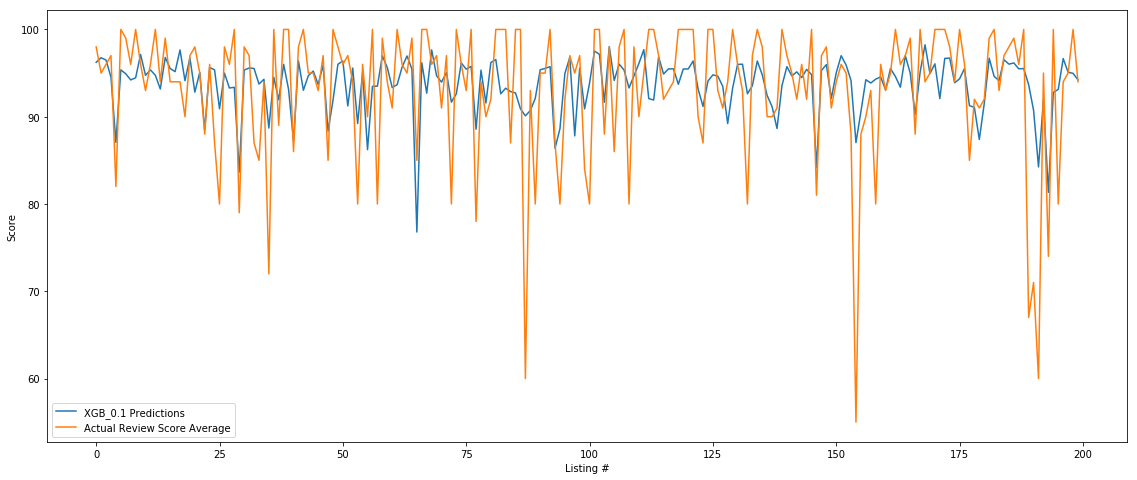

In [23]:
fig5 = plt.figure(figsize=(15,6))
ax5 = fig5.add_axes([0,0,1,1])
ax5.plot(yhat_test[0:200], label='XGB_0.1 Predictions')
ax5.plot(y_test[0:200].reset_index().drop('index',axis=1),label='Actual Review Score Average')
ax5.legend()
ax5.set_ylabel('Score')
ax5.set_xlabel('Listing #')
## Save figure
fig5.savefig('png/Yhat_xgbvsactual.png', bbox_inches='tight');